# Exploration and Chart Development for Suspension Project Training Set

## 1. Load Packages

In [211]:
########## Load Packages
import warnings
warnings.simplefilter("ignore")

import importlib
import pandas as pd
import numpy as np
import re
from io import StringIO
import itertools
import os 
import time
import datetime

from io import StringIO # python3; python2: BytesIO 
import boto3

import random 
import math

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import seaborn as sns

import nltk 
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, TfidfModel

import spacy
import fasttext

from hanziconv import HanziConv

import datetime as dt
import pytz

import langcodes
from langcodes import *
import language_data
from langdetect import detect

from snownlp import SnowNLP
import emoji

In [212]:
path = 'simhei/SimHei.ttf'
fontprop = fm.FontProperties(fname=path, size=13)

## 2. Set parameters

In [213]:
# Set Parameters 
########## Set Parameters

# Indicate how many rows to skip before columns
# Note: Python uses zero-based indexing, so skiprow=0 begins at the first row of file,
# while skiprow=1 begins at the second row.
skiprow=0

# Indicate name of column that contains text data for analysis
text_column = "text"

import_bucket = "data/s3_data/full_clean_2/"

results_bucket = 'data/s3_data/eda_output/' # already created on S3

original_data = "data/s3_data/processed/"

lda_data = "data/s3_data/full_wemojis_text/"

## 3. Load in Data

In [214]:
#### Load in data from S3

# Import Train and Measure Balance
# Import Flattened Data
df_train = pd.read_csv(import_bucket + "df_train_full_cleaned_pe.csv", error_bad_lines=False, encoding='utf-8')
len(df_train)

115766

In [215]:
df_valid = pd.read_csv(import_bucket + "df_valid_full_cleaned_pe.csv", error_bad_lines=False, encoding='utf-8')
len(df_valid)

35120

In [216]:
df_test = pd.read_csv(import_bucket + "df_test_full_cleaned_pe.csv", error_bad_lines=False, encoding='utf-8')
len(df_test)

34839

In [217]:
print("full train:", len(df_train), "unique ids train:", len(df_train['id'].unique()))

full train: 115766 unique ids train: 115766


# 4. Create Outputs 

## Create Account Level Dataset

In [218]:
pd.set_option('display.max_columns', None)
df_train.head(3)

,id,created_at,text,retweet_count,favorite_count,quoted_status_id,user.id,user.created_at,user.description,user.favourites_count,user.followers_count,user.friends_count,user.listed_count,user.location,user.name,user.screen_name,user.statuses_count,quoted_status.user.followers_count,quoted_status.user.friends_count,retweeted_status.user.followers_count,retweeted_status.user.friends_count,user_age,tweets_per_day,since_last_tweet_mins,since_last_tweet_mins_min,since_last_tweet_mins_max,since_last_tweet_mins_mean,avg_tweets_per_hr,avg_tweets_per_day,no_hashtags,no_mentions,no_urls,tw_len,followers_per_followees,containsURL,user.urls_per_tweet,no_hashtags_per_tweet,no_mentions_per_tweet,no_urls_per_tweet,user.followers_countdailychange,user.friends_countdailychange,user.friend_rate,user.followers_rate,user.has_url,user.has_location,user.screen_name.digit_length,user.screen_name.length,is_reply,suspended,split,source_ Round Year Fun!,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ 「モンストからツイート」,source_Affinitweet.com,source_BIGO LIVE,source_Blog2Social APP,source_CallApp,source_Etsy,source_Instagram,source_Joinfsocial,source_Mobile Web (M2),source_Nintendo Switch Share,source_Paper.li,source_Peing,source_SocialPilot.co,source_TeamSight Publisher,source_TweetDeck,source_Twibbon,source_Twitter Web App,source_Twitter Web Client,source_Twitter for Android,source_Twitter for Mac,source_Twitter for iPad,source_Twitter for iPhone,source_WShare,source_WordPress.com,source_漫威超級戰爭（MARVEL Super War）,lang_False,lang_am,lang_ar,lang_bg,lang_bn,lang_bo,lang_ca,lang_ckb,lang_cs,lang_cy,lang_da,lang_de,lang_el,lang_en,lang_es,lang_et,lang_eu,lang_fa,lang_fi,lang_fr,lang_gu,lang_hi,lang_ht,lang_hu,lang_hy,lang_in,lang_is,lang_it,lang_iw,lang_ja,lang_km,lang_ko,lang_lt,lang_lv,lang_ml,lang_mr,lang_my,lang_ne,lang_nl,lang_no,lang_pl,lang_ps,lang_pt,lang_ro,lang_ru,lang_sd,lang_si,lang_sl,lang_sr,lang_sv,lang_ta,lang_th,lang_tl,lang_tr,lang_uk,lang_und,lang_ur,lang_vi,lang_zh,withheld_in_countries_['DE'],withheld_in_countries_['IN'],withheld_in_countries_['TR'],place.country_Finland,place.country_Hong Kong,place.country_India,place.country_Indonesia,place.country_Italy,place.country_Mongolia,place.country_Pakistan,place.country_People's Republic of China,place.country_Portugal,place.country_Republic of Korea,place.country_Russia,place.country_Singapore,place.country_Sri Lanka,place.country_United Arab Emirates,place.country_United States,user.geo_enabled_False,user.geo_enabled_True,user.verified_False,user.has_extended_profile_False,user.has_extended_profile_True,user.protected_False,user.verified_False.1,user.default_profile_True,is_quote_status_False,is_quote_status_True
0,'1.278734441767207e+18',1.593709e+09,@ImranKhanPTI me mazor adme ho,0.0,0.0,0,1.278130e+18,1.593565e+09,m munir,5.0,1.0,60.0,0.0,NaN,M Munir,MMunir50647063,1.0,0.0,0.0,0.0,0.0,1,1.0,NaN,0.0,0.000000,0.0000,2.000000,2.0,0,1,0,30,0.016667,0,0.000000,0.000000,1.000000,0.000000,NaN,NaN,60.0,1.0,0,0,8,14,0,0,train,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,1,1,0
1,'1.278717951009411e+18',1.593705e+09,@SatoshiLite @litecoin face_with_monocle face_...,0.0,0.0,0,1.278132e+18,1.593565e+09,3QEX professional blockchain asset trading pla...,9.0,31.0,33.0,0.0,NaN,3QEX,3qex2,38.0,0.0,0.0,0.0,0.0,1,38.0,0.966667,0.0,1321.633333,152.8504,3.818182,6.3,0,2,0,29,0.939394,0,0.428571,0.777778,1.238095,0.555556,40.131579,0.184211,33.0,31.0,1,0,2,5,1,0,train,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,0
2,'1.278717966213722e+18',1.593705e+09,RT @SatoshiLite: Litecoin Core 0.18.1 final re.

In [219]:
df_train_accounts = df_train.groupby(
   ['user.id', 'user.screen_name'], as_index=False
).agg(
    {
         'id': 'count',
         'created_at': 'mean',    
         'retweet_count': ['sum', 'mean'],  
         'favorite_count': ['sum', 'mean'],  
         'user.created_at': 'mean', 
         'user.favourites_count': ['mean', 'max'],  
         'user.followers_count': ['mean', 'max'], 
         'user.friends_count': ['mean', 'max'],  
         'user.listed_count': ['mean', 'max'],  
         'user.statuses_count': ['mean', 'max'],  
         'user_age': ['mean', 'max'],  
         'tweets_per_day': 'max',  
         'since_last_tweet_mins': ['min', 'mean', 'max'], 
         'avg_tweets_per_hr': 'mean',  
         'avg_tweets_per_day': 'mean',  
         'followers_per_followees': ['mean', 'min', 'max'],  
         'containsURL': 'sum',  
         'no_urls_per_tweet': 'mean', 
         'no_hashtags_per_tweet': 'mean',
         'no_mentions_per_tweet': 'mean',
         'user.followers_countdailychange': ['mean', 'max'], # Mean and max daily difference 
         'user.friends_countdailychange': ['mean', 'max'], # Mean and max daily difference 
         'user.friend_rate': ['mean', 'max'], # Friend count over age
         'user.followers_rate': ['mean', 'max'], # Follower count over age 
         'user.has_url': 'mean',
         'user.has_location': 'mean',
         'user.screen_name.digit_length': 'mean',
         'user.screen_name.length': 'mean',
         'is_reply': 'sum',
         'suspended': 'mean'
    }
)
df_train_accounts.columns = df_train_accounts.columns.map('_'.join)
df_train_accounts['suspended_mean'] = df_train_accounts['suspended_mean'].map({0:'Not Suspended',1:'Suspended'})
df_train_accounts.head(3)

,user.id_,user.screen_name_,id_count,created_at_mean,retweet_count_sum,retweet_count_mean,favorite_count_sum,favorite_count_mean,user.created_at_mean,user.favourites_count_mean,user.favourites_count_max,user.followers_count_mean,user.followers_count_max,user.friends_count_mean,user.friends_count_max,user.listed_count_mean,user.listed_count_max,user.statuses_count_mean,user.statuses_count_max,user_age_mean,user_age_max,tweets_per_day_max,since_last_tweet_mins_min,since_last_tweet_mins_mean,since_last_tweet_mins_max,avg_tweets_per_hr_mean,avg_tweets_per_day_mean,followers_per_followees_mean,followers_per_followees_min,followers_per_followees_max,containsURL_sum,no_urls_per_tweet_mean,no_hashtags_per_tweet_mean,no_mentions_per_tweet_mean,user.followers_countdailychange_mean,user.followers_countdailychange_max,user.friends_countdailychange_mean,user.friends_countdailychange_max,user.friend_rate_mean,user.friend_rate_max,user.followers_rate_mean,user.followers_rate_max,user.has_url_mean,user.has_location_mean,user.screen_name.digit_length_mean,user.screen_name.length_mean,is_reply_sum,suspended_mean
0,1.278130e+18,MMunir50647063,1,1.593709e+09,0.0,0.000000,0.0,0.000000,1.593565e+09,5.000000,5.0,1.000000,1.0,60.000000,60.0,0.000000,0.0,1.000000,1.0,1.000000,1,1.000000,NaN,NaN,NaN,2.000000,2.0,0.016667,0.016667,0.016667,0,0.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,60.000000,60.000000,1.000000,1.0,0.0,0.0,8,14,0,Not Suspended
1,1.278132e+18,3qex2,63,1.595097e+09,1256.0,19.936508,76.0,1.206349,1.593565e+09,14.238095,19.0,829.809524,1556.0,36.666667,40.0,0.238095,1.0,51.095238,63.0,17.349206,55,63.000000,0.066667,308.166129,1321.633333,3.818182,6.3,20.823521,0.939394,38.900000,27,0.555556,0.777778,1.238095,40.131579,40.131579,0.184211,0.184211,11.293454,40.000000,222.766454,1556.0,1.0,0.0,2,5,26,Not Suspended
2,1.278136e+18,SueleWui,1,1.594360e+09,0.0,0.000000,0.0,0.000000,1.593566e+09,7.000000,7.0,0.000000,0.0,20.000000,20.0,0.000000,0.0,1.000000,1.0,9.000000,9,0.111111,NaN,NaN,NaN,2.000000,2.0,0.000000,0.000000,0.000000,1,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,2.222222,2.222222,0.000000,0.0,0.0,0.0,0,8,0,Not Suspended


In [220]:
df_test_accounts = df_test.groupby(
   ['user.id', 'user.screen_name'], as_index=False
).agg(
    {
         'id': 'count',
         'created_at': 'mean',    
         'retweet_count': ['sum', 'mean'],  
         'favorite_count': ['sum', 'mean'],  
         'user.created_at': 'mean', 
         'user.favourites_count': ['mean', 'max'],  
         'user.followers_count': ['mean', 'max'], 
         'user.friends_count': ['mean', 'max'],  
         'user.listed_count': ['mean', 'max'],  
         'user.statuses_count': ['mean', 'max'],  
         'user_age': ['mean', 'max'],  
         'tweets_per_day': 'max',  
         'since_last_tweet_mins': ['min', 'mean', 'max'],
         'avg_tweets_per_hr': 'mean',  
         'avg_tweets_per_day': 'mean',  
         'followers_per_followees': ['mean', 'min', 'max'],  
         'containsURL': 'sum',  
         'no_urls_per_tweet': 'mean', 
         'no_hashtags_per_tweet': 'mean',
         'no_mentions_per_tweet': 'mean',
         'user.followers_countdailychange': ['mean', 'max'], # Mean and max daily difference 
         'user.friends_countdailychange': ['mean', 'max'], # Mean and max daily difference 
         'user.friend_rate': ['mean', 'max'],
         'user.followers_rate': ['mean', 'max'],
         'user.has_url': 'mean',
         'user.has_location': 'mean',
         'user.screen_name.digit_length': 'mean',
         'user.screen_name.length': 'mean',
         'is_reply': 'sum',
         'suspended': 'mean'
    }
)
df_test_accounts.columns = df_test_accounts.columns.map('_'.join)
df_test_accounts['suspended_mean'] = df_test_accounts['suspended_mean'].map({0:'Not Suspended',1:'Suspended'})
df_test_accounts.head(3)

,user.id_,user.screen_name_,id_count,created_at_mean,retweet_count_sum,retweet_count_mean,favorite_count_sum,favorite_count_mean,user.created_at_mean,user.favourites_count_mean,user.favourites_count_max,user.followers_count_mean,user.followers_count_max,user.friends_count_mean,user.friends_count_max,user.listed_count_mean,user.listed_count_max,user.statuses_count_mean,user.statuses_count_max,user_age_mean,user_age_max,tweets_per_day_max,since_last_tweet_mins_min,since_last_tweet_mins_mean,since_last_tweet_mins_max,avg_tweets_per_hr_mean,avg_tweets_per_day_mean,followers_per_followees_mean,followers_per_followees_min,followers_per_followees_max,containsURL_sum,no_urls_per_tweet_mean,no_hashtags_per_tweet_mean,no_mentions_per_tweet_mean,user.followers_countdailychange_mean,user.followers_countdailychange_max,user.friends_countdailychange_mean,user.friends_countdailychange_max,user.friend_rate_mean,user.friend_rate_max,user.followers_rate_mean,user.followers_rate_max,user.has_url_mean,user.has_location_mean,user.screen_name.digit_length_mean,user.screen_name.length_mean,is_reply_sum,suspended_mean
0,1.278122e+18,NJ8f7eaXxguK5os,2,1.593758e+09,0.0,0.0,1.0,0.500000,1.593563e+09,0.000000,0.0,6.0,6.0,52.000000,52.0,0.0,0.0,2.0,2.0,2.000000,4,inf,726.533333,726.533333,726.533333,2.000000,2.000,0.115385,0.115385,0.115385,0,0.000000,0.0,0.500000,0.0,0.0,0.000000,0.000000,inf,inf,inf,inf,0.0,0.0,3,15,1,Not Suspended
1,1.278129e+18,ZhuaHei,35,1.594616e+09,0.0,0.0,17.0,0.485714,1.593565e+09,66.685714,72.0,1.0,1.0,46.171429,47.0,0.0,0.0,33.8,35.0,11.771429,57,inf,1.116667,359.458824,1422.250000,3.684211,4.375,0.021660,0.021277,0.021739,1,0.028571,0.0,2.142857,0.0,0.0,-0.033333,-0.033333,inf,inf,inf,inf,0.0,0.0,0,7,35,Not Suspended
2,1.278131e+18,Benalph97276334,1,1.594446e+09,0.0,0.0,0.0,0.000000,1.593565e+09,2.000000,2.0,0.0,0.0,13.000000,13.0,0.0,0.0,1.0,1.0,10.000000,10,0.1,NaN,NaN,NaN,2.000000,2.000,0.000000,0.000000,0.000000,0,0.000000,0.0,2.000000,NaN,NaN,NaN,NaN,1.3,1.3,0.0,0.0,0.0,0.0,8,15,1,Not Suspended


In [221]:
df_valid_accounts = df_valid.groupby(
   ['user.id', 'user.screen_name'], as_index=False
).agg(
    {
         'id': 'count',
         'created_at': 'mean',    
         'retweet_count': ['sum', 'mean'],  
         'favorite_count': ['sum', 'mean'],  
         'user.created_at': 'mean', 
         'user.favourites_count': ['mean', 'max'],  
         'user.followers_count': ['mean', 'max'], 
         'user.friends_count': ['mean', 'max'],  
         'user.listed_count': ['mean', 'max'],  
         'user.statuses_count': ['mean', 'max'],  
         'user_age': ['mean', 'max'],  
         'tweets_per_day': 'max',  
         'since_last_tweet_mins': ['min', 'mean', 'max'], 
         'avg_tweets_per_hr': 'mean',  
         'avg_tweets_per_day': 'mean',  
         'followers_per_followees': ['mean', 'min', 'max'],  
         'containsURL': 'sum',  
         'no_urls_per_tweet': 'mean', 
         'no_hashtags_per_tweet': 'mean',
         'no_mentions_per_tweet': 'mean',
         'user.followers_countdailychange': ['mean', 'max'], # Mean and max daily difference 
         'user.friends_countdailychange': ['mean', 'max'], # Mean and max daily difference 
         'user.friend_rate': ['mean', 'max'],
         'user.followers_rate': ['mean', 'max'],
         'user.has_url': 'mean',
         'user.has_location': 'mean',
         'user.screen_name.digit_length': 'mean',
         'user.screen_name.length': 'mean',
         'is_reply': 'sum',
         'suspended': 'mean'
    }
)
df_valid_accounts.columns = df_valid_accounts.columns.map('_'.join)
df_valid_accounts['suspended_mean'] = df_valid_accounts['suspended_mean'].map({0:'Not Suspended',1:'Suspended'})
df_valid_accounts.head(3)

,user.id_,user.screen_name_,id_count,created_at_mean,retweet_count_sum,retweet_count_mean,favorite_count_sum,favorite_count_mean,user.created_at_mean,user.favourites_count_mean,user.favourites_count_max,user.followers_count_mean,user.followers_count_max,user.friends_count_mean,user.friends_count_max,user.listed_count_mean,user.listed_count_max,user.statuses_count_mean,user.statuses_count_max,user_age_mean,user_age_max,tweets_per_day_max,since_last_tweet_mins_min,since_last_tweet_mins_mean,since_last_tweet_mins_max,avg_tweets_per_hr_mean,avg_tweets_per_day_mean,followers_per_followees_mean,followers_per_followees_min,followers_per_followees_max,containsURL_sum,no_urls_per_tweet_mean,no_hashtags_per_tweet_mean,no_mentions_per_tweet_mean,user.followers_countdailychange_mean,user.followers_countdailychange_max,user.friends_countdailychange_mean,user.friends_countdailychange_max,user.friend_rate_mean,user.friend_rate_max,user.followers_rate_mean,user.followers_rate_max,user.has_url_mean,user.has_location_mean,user.screen_name.digit_length_mean,user.screen_name.length_mean,is_reply_sum,suspended_mean
0,1.278120e+18,SFAC_TFA_CN,1038,1.598222e+09,887.0,0.854528,1807.0,1.740848,1.593563e+09,17988.138728,27302.0,258.154143,401.0,539.548170,810.0,0.736031,2.0,971.101156,1573.0,53.540462,83,21.196721,0.066667,68.415879,1380.216667,5.091413,36.039216,0.452451,0.278107,0.509934,149,0.145267,0.019587,1.857454,7.08,7.08,12.82,12.82,9.651089,12.081967,4.441555,5.704918,0.0,0.614644,0,11,966,Suspended
1,1.278152e+18,85IFYYgf0GGo5Gb,28,1.594247e+09,1.0,0.035714,22.0,0.785714,1.593570e+09,14.000000,14.0,1.000000,1.0,11.035714,12.0,0.000000,0.0,27.000000,27.0,7.464286,26,13.500000,0.000000,113.795679,1107.016667,6.111111,11.000000,0.090639,0.083333,0.090909,7,0.236364,0.000000,1.581818,0.00,0.00,0.00,0.00,2.019509,5.500000,0.183051,0.500000,0.0,0.000000,4,15,26,Not Suspended
2,1.278155e+18,SamuelHPWong1,2,1.596586e+09,0.0,0.000000,0.0,0.000000,1.593571e+09,4.000000,4.0,0.000000,0.0,19.000000,19.0,0.000000,0.0,1.500000,2.0,34.500000,69,inf,18.483333,18.483333,18.483333,2.000000,2.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,1.000000,0.00,0.00,0.00,0.00,inf,inf,0.000000,0.000000,0.0,0.000000,1,13,2,Not Suspended


## Number of suspended accounts vs. non-suspended (For train, valid, and test just to get statistics) [INCLUDED]

#### Tweet Level

Train

Table

In [12]:
P = df_train.groupby('suspended')['id'].count().reset_index()
P = P.rename(columns = {'suspended':'Suspended', 'id':'Count'})
P['Suspended'] = P['Suspended'].map({0:'Not Suspended',1:'Suspended'})
P['Proportion'] = 100 * P['Count']/P['Count'].sum()
print(P)

       Suspended   Count  Proportion
0  Not Suspended  106870   92.315533
1      Suspended    8896    7.684467


Chart

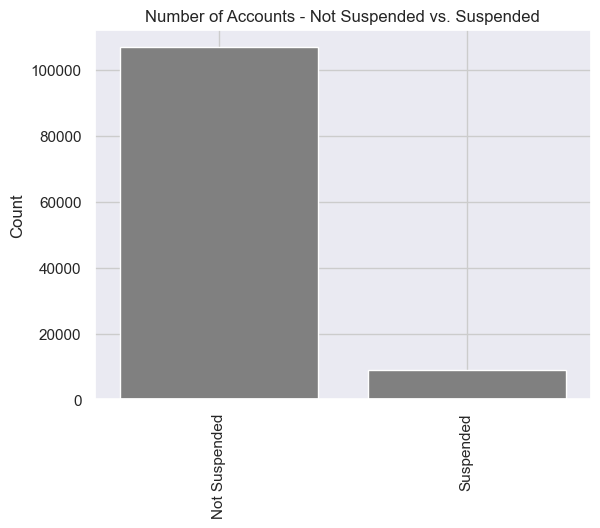

In [13]:


# Some boilerplate to initialise things
sns.set()
plt.figure()

# This is where the actual plot gets made
ax = sns.barplot(data=P, x="Suspended", y="Count", palette=['blue'], saturation=0)

# Customise some display properties
ax.set_title('Number of Accounts - Not Suspended vs. Suspended')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel(None)
ax.set_xticklabels(P["Suspended"].unique().astype(str), rotation='vertical')

# Ask Matplotlib to show it
plt.show()

Valid

In [14]:
P = df_valid.groupby('suspended')['id'].count().reset_index()
P = P.rename(columns = {'suspended':'Suspended', 'id':'Count'})
P['Suspended'] = P['Suspended'].map({0:'Not Suspended',1:'Suspended'})
P['Proportion'] = 100 * P['Count']/P['Count'].sum()
print(P)

       Suspended  Count  Proportion
0  Not Suspended  28923   82.354784
1      Suspended   6197   17.645216


Test

In [15]:
P = df_test.groupby('suspended')['id'].count().reset_index()
P = P.rename(columns = {'suspended':'Suspended', 'id':'Count'})
P['Suspended'] = P['Suspended'].map({0:'Not Suspended',1:'Suspended'})
P['Proportion'] = 100 * P['Count']/P['Count'].sum()
print(P)

       Suspended  Count  Proportion
0  Not Suspended  31795   91.262665
1      Suspended   3044    8.737335


#### Account Level

In [16]:
P = df_train_accounts.groupby('suspended_mean')['user.id_'].count().reset_index()
P = P.rename(columns = {'suspended_mean':'Suspended', 'user.id_':'Count'})
P['Proportion'] = 100 * P['Count']/P['Count'].sum()
print(P)

       Suspended  Count  Proportion
0  Not Suspended   1450   93.367675
1      Suspended    103    6.632325


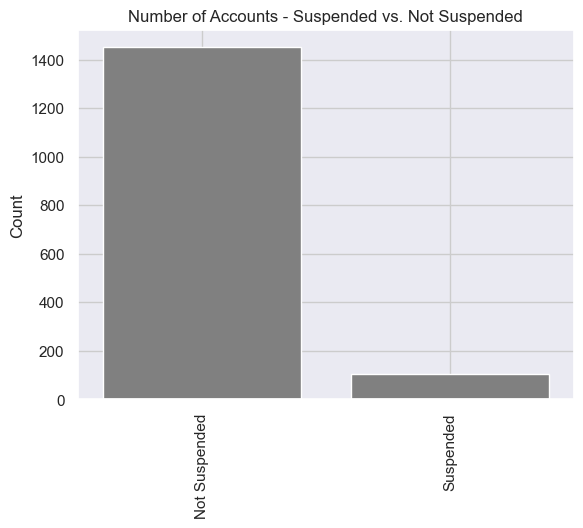

In [17]:
# Some boilerplate to initialise things
sns.set()
plt.figure()

# This is where the actual plot gets made
ax = sns.barplot(data=P, x="Suspended", y="Count", palette=['blue'], saturation=0)

# Customise some display properties
ax.set_title('Number of Accounts - Suspended vs. Not Suspended')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel(None)
ax.set_xticklabels(P["Suspended"].unique().astype(str), rotation='vertical')

# Ask Matplotlib to show it
plt.show()

Valid

In [18]:
P = df_valid_accounts.groupby('suspended_mean')['user.id_'].count().reset_index()
P = P.rename(columns = {'suspended_mean':'Suspended', 'user.id_':'Count'})
P['Proportion'] = 100 * P['Count']/P['Count'].sum()
print(P)

       Suspended  Count  Proportion
0  Not Suspended    509   89.770723
1      Suspended     58   10.229277


Test

In [19]:
P = df_test_accounts.groupby('suspended_mean')['user.id_'].count().reset_index()
P = P.rename(columns = {'suspended_mean':'Suspended', 'user.id_':'Count'})
P['Proportion'] = 100 * P['Count']/P['Count'].sum()
print(P)

       Suspended  Count  Proportion
0  Not Suspended    479    93.37232
1      Suspended     34     6.62768


## Creation date/duration for suspended vs. non-suspended [INCLUDED]

#### Account 

In [20]:
df_train_accounts['user.created_at'] = df_train_accounts['user.created_at_mean'].apply(lambda x: datetime.datetime.fromtimestamp(x))
df_train_accounts['user.created_at_dmy'] = df_train_accounts['user.created_at'].apply(lambda x:datetime.datetime.strftime(x, '%b %d %Y')).tolist()

In [21]:
P = df_train_accounts.groupby(['user.created_at_dmy','suspended_mean'], as_index=False).agg({"user.id_": "count"})
P = P.rename(columns = {'user.created_at_dmy':'Date','suspended_mean':'Suspended', 'user.id_':'Count'})
#P['Suspended'] = P['Suspended'].map({0:'Not Suspended',1:'Suspended'})
P['Date'] = pd.to_datetime(P['Date'], infer_datetime_format=True).dt.date
P = P.sort_values(by=['Date'])
P.head()

,Date,Suspended,Count
51,2020-06-30,Suspended,1
50,2020-06-30,Not Suspended,9
0,2020-07-01,Not Suspended,90
1,2020-07-01,Suspended,4
2,2020-07-02,Not Suspended,93


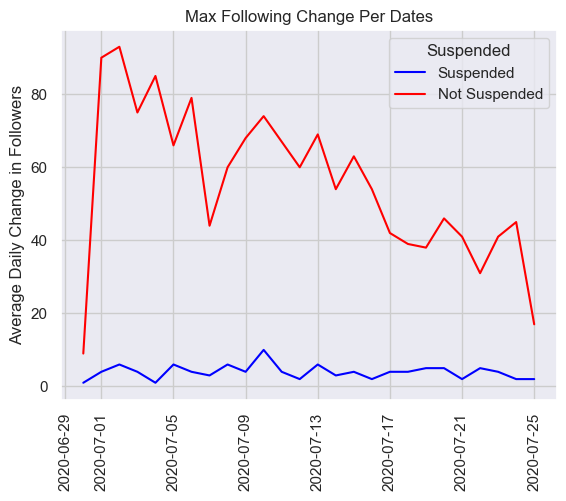

In [22]:
# Some boilerplate to initialise things
sns.set()
plt.figure()

# This is where the actual plot gets made
ax = sns.lineplot(data=P, x="Date", y="Count", hue="Suspended", palette=['blue', 'red'], sort=False)

# Customise some display properties
ax.set_title('Max Following Change Per Dates')
ax.grid(color='#cccccc')
ax.set_ylabel('Average Daily Change in Followers')
ax.set_xlabel(None)
plt.xticks(rotation='vertical')

#plt.savefig(results_bucket+'followers_count_change_daily_susvsns.png', bbox_inches='tight')
# Ask Matplotlib to show it
plt.show()

## Suspension Dates 

Get last tweet date per account

In [23]:
last_tweets = df_train[df_train['suspended'] == 1].groupby(
   ['user.id', 'user.screen_name', 'user.created_at'], as_index=False
).agg(
    {
         'created_at': 'max'
    }
)

last_tweets['created_at'] = last_tweets['created_at'].apply(lambda x: datetime.datetime.fromtimestamp(x))
last_tweets['user.created_at'] = last_tweets['user.created_at'].apply(lambda x: datetime.datetime.fromtimestamp(x))
last_tweets['created_at_dmy'] = last_tweets['created_at'].apply(lambda x:datetime.datetime.strftime(x, '%b %d %Y')).tolist()
last_tweets.head(6)

,user.id,user.screen_name,user.created_at,created_at,created_at_dmy
0,1.278150e+18,AnnaAdachi4,2020-06-30 22:15:14,2020-08-17 03:32:16,Aug 17 2020
1,1.278222e+18,nFA8r89qmAoB5uT,2020-07-01 02:59:48,2020-09-08 07:07:07,Sep 08 2020
2,1.278247e+18,FangWu07049399,2020-07-01 04:41:56,2020-07-24 04:17:58,Jul 24 2020
3,1.278333e+18,AshishS44350553,2020-07-01 10:21:40,2020-09-02 02:10:36,Sep 02 2020
4,1.278492e+18,wXzBIjr7Ep5RRre,2020-07-01 20:52:11,2020-07-27 07:02:05,Jul 27 2020
5,1.278562e+18,Wassily_Hao1,2020-07-02 01:31:57,2020-08-10 03:33:19,Aug 10 2020


How many accounts suspended on each date

In [24]:
P = last_tweets.groupby(['created_at_dmy'], as_index=False).agg({"user.id": "count"})
P = P.rename(columns = {'created_at_dmy':'Date of Last Tweet Before Suspension','user.id':'Count'})
P

,Date of Last Tweet Before Suspension,Count
0,Aug 01 2020,2
1,Aug 04 2020,1
2,Aug 05 2020,1
3,Aug 08 2020,1
4,Aug 10 2020,2
5,Aug 11 2020,1
6,Aug 12 2020,2
7,Aug 13 2020,2
8,Aug 14 2020,9
9,Aug 17 2020,1


In [25]:
b = df_train[df_train['suspended'] == 1].sort_values('created_at').drop_duplicates(['user.id'],keep='last')
b['created_at'] = b['created_at'].apply(lambda x: datetime.datetime.fromtimestamp(x))
b['created_at_dmy'] = b['created_at'].apply(lambda x:datetime.datetime.strftime(x, '%b %d %Y')).tolist()
for_susp_text = b[b['created_at_dmy'] == "Jul 27 2020"]

Bar Plot of suspension dates (Not used)

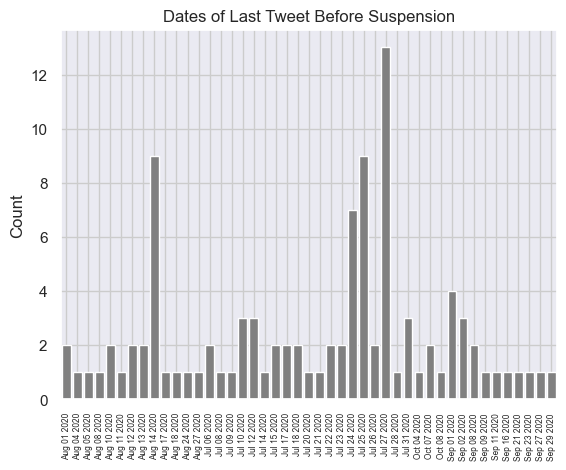

In [26]:
# Some boilerplate to initialise things
sns.set()
plt.figure()

# This is where the actual plot gets made
ax = sns.barplot(data=P, x="Date of Last Tweet Before Suspension", y="Count", palette=['blue'], saturation=0)

# Customise some display properties
ax.set_title('Dates of Last Tweet Before Suspension')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel(None)
ax.set_xticklabels(P["Date of Last Tweet Before Suspension"].unique().astype(str), rotation='vertical', fontsize=6)

# Ask Matplotlib to show it
plt.show()

# Duration of existence for suspended accounts [INCLUDED]

In [27]:
last_tweets['duration_bf_suspension'] = (last_tweets['created_at']-last_tweets['user.created_at']).dt.days

In [28]:
P = last_tweets.groupby(['duration_bf_suspension'], as_index=False).agg({"user.id": "count"})
P = P.rename(columns = {'duration_bf_suspension':'Duration Before Suspension','user.id':'Count'})
P.head()

,Duration Before Suspension,Count
0,0,14
1,1,4
2,2,1
3,3,3
4,4,4


Percent in a day

In [29]:
P[P['Duration Before Suspension'] == 0]['Count'].values/sum(P['Count'])

array([0.13592233])

Percent in a week

In [30]:
sum(P[P['Duration Before Suspension'] < 8]['Count'])/sum(P['Count'])

0.34951456310679613

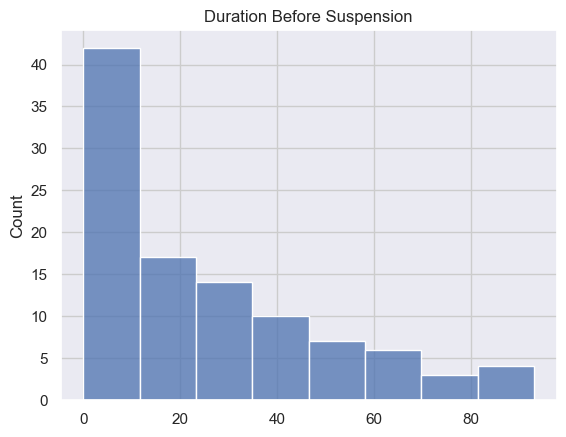

In [31]:
# Some boilerplate to initialise things
sns.set()
plt.figure()

# This is where the actual plot gets made
ax = sns.histplot(data=last_tweets, x='duration_bf_suspension', palette=['blue'])

# Customise some display properties
ax.set_title('Duration Before Suspension')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel(None)
#ax.set_xticklabels(last_tweets["duration_bf_suspension"].unique().astype(str), rotation='vertical', fontsize=8)

# Ask Matplotlib to show it
plt.savefig(results_bucket+'duration_before_suspension.png', bbox_inches='tight')
plt.show()

### Dormancy calculation (time between account creation and first post)

In [228]:
first_tweets = df_train.groupby(
   ['user.id', 'user.screen_name', 'user.created_at', 'suspended'], as_index=False
).agg(
    {
         'created_at': 'max'
    }
)

first_tweets['created_at'] = first_tweets['created_at'].apply(lambda x: datetime.datetime.fromtimestamp(x))
first_tweets['user.created_at'] = first_tweets['user.created_at'].apply(lambda x: datetime.datetime.fromtimestamp(x))
first_tweets['created_at_dmy'] = first_tweets['created_at'].apply(lambda x:datetime.datetime.strftime(x, '%b %d %Y')).tolist()
first_tweets.head(6)

,user.id,user.screen_name,user.created_at,suspended,created_at,created_at_dmy
0,1.278130e+18,MMunir50647063,2020-06-30 20:54:10,0,2020-07-02 12:57:03,Jul 02 2020
1,1.278132e+18,3qex2,2020-06-30 21:04:54,0,2020-08-25 12:08:04,Aug 25 2020
2,1.278136e+18,SueleWui,2020-06-30 21:19:00,0,2020-07-10 01:54:12,Jul 10 2020
3,1.278138e+18,LeoWang72378273,2020-06-30 21:25:44,0,2020-07-02 01:22:50,Jul 02 2020
4,1.278143e+18,o6EOrfNWQkCsWDu,2020-06-30 21:46:27,0,2020-09-06 01:32:29,Sep 06 2020
5,1.278150e+18,AnnaAdachi4,2020-06-30 22:15:14,1,2020-08-17 03:32:16,Aug 17 2020


In [229]:
first_tweets['dormancy_bf'] = (first_tweets['created_at']-first_tweets['user.created_at']).dt.days

In [235]:
first_tweets['week_dormancy'] = (first_tweets['dormancy_bf'] >= 7)
P = first_tweets.groupby(['suspended', 'week_dormancy'])['user.id'].count().reset_index()
P = P.rename(columns = {'suspended':'Suspended', 'user.id':'Count'})
P['Suspended'] = P['Suspended'].map({0:'Not Suspended',1:'Suspended'})
P['Total_sus'] = P.groupby('Suspended')['Count'].transform('sum')
P['Proportion'] = P['Count']/P['Total_sus']
P

,Suspended,week_dormancy,Count,Total_sus,Proportion
0,Not Suspended,False,419,1450,0.288966
1,Not Suspended,True,1031,1450,0.711034
2,Suspended,False,32,103,0.310680
3,Suspended,True,71,103,0.689320


In [236]:
P = first_tweets.groupby(
   ['suspended'], as_index=False
).agg(
    {
         'dormancy_bf': ['mean', 'std'] 
    }
)
P

suspended dormancy_bf           
                   mean        std
0         0   37.488966  33.835374
1         1   25.145631  24.752662

# Number of Tweets for Suspended vs. Not [INCLUDED]

Suspended

In [32]:
P = df_train[df_train['suspended'] == 1].groupby(
   ['user.id', 'user.screen_name'], as_index=False
).agg(
    {
         'id': 'count'
    }
)

P.to_csv(results_bucket+'suso_tweet_vol.csv', index=False, encoding = "utf_8_sig")
P.head(6)

,user.id,user.screen_name,id
0,1.278150e+18,AnnaAdachi4,145
1,1.278222e+18,nFA8r89qmAoB5uT,278
2,1.278247e+18,FangWu07049399,35
3,1.278333e+18,AshishS44350553,93
4,1.278492e+18,wXzBIjr7Ep5RRre,62
5,1.278562e+18,Wassily_Hao1,80


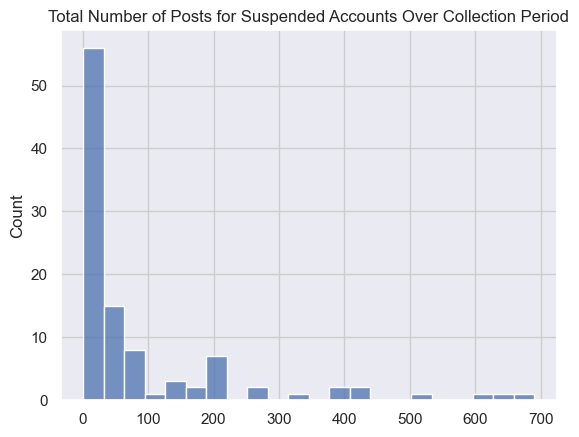

In [33]:
# Some boilerplate to initialise things
sns.set()
plt.figure()

# This is where the actual plot gets made
ax = sns.histplot(data=P, x='id', palette=['blue'])

# Customise some display properties
ax.set_title('Total Number of Posts for Suspended Accounts Over Collection Period')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel(None)
#ax.set_xticklabels(df_train[df_train['suspended'] == 1]["id"].unique().astype(str), rotation='vertical', fontsize=6)

# Ask Matplotlib to show it
plt.savefig(results_bucket+'suso_tweet_vol.png', bbox_inches='tight')
plt.show()

Non Suspended

In [70]:
P = df_train[df_train['suspended'] == 0].groupby(
   ['user.id', 'user.screen_name'], as_index=False
).agg(
    {
         'id': 'count'
    }
)

P.to_csv(results_bucket+'nonsuso_tweet_vol.csv', index=False, encoding = "utf_8_sig")
P.head(6)

,user.id,user.screen_name,id
0,1.278130e+18,MMunir50647063,1
1,1.278132e+18,3qex2,63
2,1.278136e+18,SueleWui,1
3,1.278138e+18,LeoWang72378273,2
4,1.278143e+18,o6EOrfNWQkCsWDu,127
5,1.278154e+18,mr6724444166,82


In [71]:
len(P[P['id'] > 500])

55

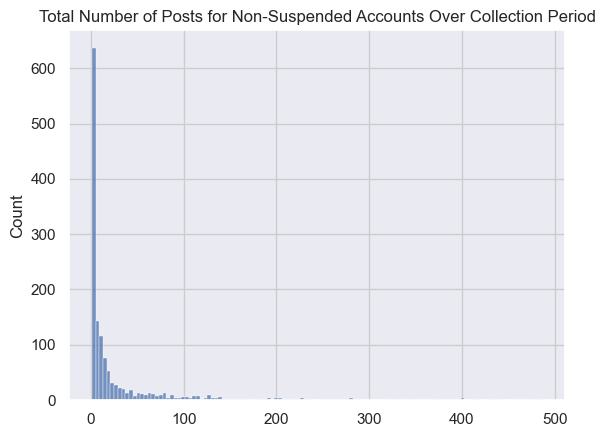

In [72]:
# Some boilerplate to initialise things
sns.set()
plt.figure()

# This is where the actual plot gets made
ax = sns.histplot(data=P[P['id'] < 500], x='id', palette=['blue'])

# Customise some display properties
ax.set_title('Total Number of Posts for Non-Suspended Accounts Over Collection Period')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel(None)
#ax.set_xticklabels(df_train[df_train['suspended'] == 1]["id"].unique().astype(str), rotation='vertical', fontsize=6)

# Ask Matplotlib to show it
plt.savefig(results_bucket+'nonsuso_tweet_vol.png', bbox_inches='tight')
plt.show()

#### All Posts 

In [73]:
df_train_accounts['thousand_posts'] = (df_train_accounts['user.statuses_count_max'] >= 100)
P = df_train_accounts.groupby(['suspended_mean', 'thousand_posts'])['user.id_'].count().reset_index()
P = P.rename(columns = {'suspended_mean':'Suspended', 'user.id_':'Count'})
P['Total_sus'] = P.groupby('Suspended')['Count'].transform('sum')
P['Proportion'] = P['Count']/P['Total_sus']
P

,Suspended,thousand_posts,Count,Total_sus,Proportion
0,Not Suspended,False,1265,1450,0.872414
1,Not Suspended,True,185,1450,0.127586
2,Suspended,False,80,103,0.776699
3,Suspended,True,23,103,0.223301


In [76]:
P = df_train_accounts.groupby(
   ['suspended_mean'], as_index=False
).agg(
    {
         'user.statuses_count_max': ['mean', 'std'] 
    }
)

P.to_csv(results_bucket+'avg_all_statuses_svsns.csv', index=False, encoding = "utf_8_sig")
P.head(6)

suspended_mean user.statuses_count_max            
                                    mean         std
0  Not Suspended              106.358621  498.956823
1      Suspended              200.291262  783.307776

#### Over the Collection Period 

In [77]:
P = df_train_accounts.groupby(
   ['suspended_mean'], as_index=False
).agg(
    {
         'id_count': ['mean', 'std'] 
    }
)

P.to_csv(results_bucket+'avg_collection_statuses_svsns.csv', index=False, encoding = "utf_8_sig")
P.head(6)

suspended_mean   id_count            
                       mean         std
0  Not Suspended  73.703448  252.025351
1      Suspended  86.368932  145.042049

#### Language of posts 

## Avg Tweet Rates for Suspended vs. Not [INCLUDED]

Aggregate Stats - mean

In [78]:
P = df_train_accounts.groupby(
   ['suspended_mean'], as_index=False
).agg(
    {
         'avg_tweets_per_day_mean': 'mean'
    }
)

P.to_csv(results_bucket+'avg_tweets_per_day_svsns.csv', index=False, encoding = "utf_8_sig")
P.head(6)

,suspended_mean,avg_tweets_per_day_mean
0,Not Suspended,7.412514
1,Suspended,14.130200


In [79]:
P = df_train_accounts.groupby(
   ['suspended_mean'], as_index=False
).agg(
    {
         'avg_tweets_per_day_mean': 'max'
    }
)

P.to_csv(results_bucket+'max_avg_tweets_per_day_svsns.csv', index=False, encoding = "utf_8_sig")
P.head(6)

,suspended_mean,avg_tweets_per_day_mean
0,Not Suspended,417.000000
1,Suspended,166.333333


Bin for Visuals

In [80]:
df_train_accounts['avg_tweets_per_day_bins'] = pd.cut(df_train_accounts['avg_tweets_per_day_mean'],bins = pd.interval_range(start=0, end= df_train_accounts['avg_tweets_per_day_mean'].max(), periods=50))

In [81]:
df_train_accounts['avg_tweets_per_day_bins'] = df_train_accounts['avg_tweets_per_day_bins'].apply(lambda x: pd.Interval(left=int(round(x.left)), right=int(round(x.right))))
df_train_accounts['avg_tweets_per_day_bins'] =df_train_accounts['avg_tweets_per_day_bins'].astype('str')

## Min amount of time between tweets [INCLUDED]

Aggregate Statitics - Mean

In [114]:
P = df_train_accounts.groupby(
   ['suspended_mean'], as_index=False
).agg(
    {
         'since_last_tweet_mins_mean': 'mean'
    }
)

P.to_csv(results_bucket+'since_last_tweet_mins_min_mean_svsns.csv', index=False, encoding = "utf_8_sig")
P.head(6)

,suspended_mean,since_last_tweet_mins_mean
0,Not Suspended,342.626589
1,Suspended,261.670396


Aggregate Statistics - Number of less than a minute average

In [116]:
df_train_accounts['fast_tweeting'] = (df_train_accounts['since_last_tweet_mins_min'] < 1)
P = df_train_accounts.groupby(['suspended_mean', 'fast_tweeting'])['user.id_'].count().reset_index()
P = P.rename(columns = {'suspended_mean':'Suspended', 'user.id_':'Count'})
P['Total_sus'] = P.groupby('Suspended')['Count'].transform('sum')
P['Proportion'] = P['Count']/P['Total_sus']
P

,Suspended,fast_tweeting,Count,Total_sus,Proportion
0,Not Suspended,False,754,1450,0.520000
1,Not Suspended,True,696,1450,0.480000
2,Suspended,False,34,103,0.330097
3,Suspended,True,69,103,0.669903


## Avg Tweet Rates for Retweets Only [INCLUDED]

In [118]:
df_train_accounts_retweets = df_train[df_train['is_reply'] == 1].groupby(
   ['user.id', 'user.screen_name'], as_index=False
).agg(
    {
         'id': 'count', 
         'tweets_per_day': 'max',  
         'since_last_tweet_mins_min': 'mean',  
         'since_last_tweet_mins_max': 'mean',  
         'since_last_tweet_mins_mean': 'mean',  
         'avg_tweets_per_hr': 'mean',  
         'avg_tweets_per_day': 'mean',  
         'is_reply': 'sum',
         'suspended': 'mean'
    }
)
df_train_accounts_retweets['suspended'] = df_train_accounts_retweets['suspended'].map({0:'Not Suspended',1:'Suspended'})
df_train_accounts_retweets.head(3)

,user.id,user.screen_name,id,tweets_per_day,since_last_tweet_mins_min,since_last_tweet_mins_max,since_last_tweet_mins_mean,avg_tweets_per_hr,avg_tweets_per_day,is_reply,suspended
0,1.278132e+18,3qex2,26,63.0,0.0,1321.633333,152.850400,3.818182,6.300000,26,Not Suspended
1,1.278138e+18,LeoWang72378273,1,2.0,0.0,215.816667,71.938889,2.000000,2.000000,1,Not Suspended
2,1.278143e+18,o6EOrfNWQkCsWDu,126,inf,0.0,1344.166667,58.797470,5.625000,20.454545,126,Not Suspended


In [119]:
P = df_train_accounts_retweets.groupby(
   ['suspended'], as_index=False
).agg(
    {
         'avg_tweets_per_day': 'mean'
    }
)

P.to_csv(results_bucket+'retweets_avg_tweets_per_day_svsns.csv', index=False, encoding = "utf_8_sig")
P.head(6)

,suspended,avg_tweets_per_day
0,Not Suspended,7.753295
1,Suspended,16.406663


In [120]:
P = df_train_accounts_retweets.groupby(
   ['suspended'], as_index=False
).agg(
    {
         'avg_tweets_per_day': 'max'
    }
)

P.to_csv(results_bucket+'retweets_max_tweets_per_day_svsns.csv', index=False, encoding = "utf_8_sig")
P.head(6)

,suspended,avg_tweets_per_day
0,Not Suspended,145.000000
1,Suspended,166.333333


In [121]:
df_train_accounts_retweets['avg_tweets_per_day_bins'] = pd.cut(df_train_accounts_retweets['avg_tweets_per_day'],bins = pd.interval_range(start=0, end= df_train_accounts['avg_tweets_per_day_mean'].max(), periods=50))

In [122]:
df_train_accounts_retweets['avg_tweets_per_day_bins'] = df_train_accounts_retweets['avg_tweets_per_day_bins'].apply(lambda x: pd.Interval(left=int(round(x.left)), right=int(round(x.right))))
df_train_accounts_retweets['avg_tweets_per_day_bins'] = df_train_accounts_retweets['avg_tweets_per_day_bins'].astype('str')

In [123]:
P = df_train_accounts_retweets.groupby(['avg_tweets_per_day_bins','suspended'], as_index=False).agg({"user.id": "count"})
P = P.rename(columns = {'avg_tweets_per_day_bins':'TweetRates','suspended':'Suspended', 'user.id':'Count'})
P.head()

,TweetRates,Suspended,Count
0,"(0, 8]",Not Suspended,905
1,"(0, 8]",Suspended,52
2,"(100, 108]",Not Suspended,1
3,"(117, 125]",Not Suspended,2
4,"(125, 133]",Suspended,2


## Follower Counts [INCLUDED]

In [153]:
df_train.sort_values(by=['user.id', 'created_at'], inplace=True)

# for this example, with diff, I think this syntax is a bit clunky
# but for more general examples, this should be good.  But can we do better?
df_train['follower_diffs'] = df_train.groupby(['user.id'])['user.followers_count'].transform(lambda x: x.diff()) 

df_train.sort_index(inplace=True)

In [154]:
import matplotlib.dates as mdates

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%B-%Y') #This is a format. Will be clear in Screenshot

#### Max Followers Change Per Day

In [ ]:
df_train['created_at'] = df_train['created_at'].apply(lambda x: datetime.datetime.fromtimestamp(x))
df_train['created_at_dmy'] = df_train['created_at'].apply(lambda x:datetime.datetime.strftime(x, '%b %d %Y')).tolist()

In [187]:
P = df_train.groupby(['created_at_dmy','suspended'], as_index=False).agg({"follower_diffs": "mean"})
P = P.rename(columns = {'created_at_dmy':'Date','suspended':'Suspended', 'follower_diffs':'Count'})
P['Suspended'] = P['Suspended'].map({0:'Not Suspended',1:'Suspended'})
P['Date'] = pd.to_datetime(P['Date'], infer_datetime_format=True).dt.date
P = P.sort_values(by=['Date'])
P.head()

,Date,Suspended,Count
125,2020-06-30,Suspended,0.000000
124,2020-06-30,Not Suspended,0.000000
63,2020-07-01,Suspended,0.000000
62,2020-07-01,Not Suspended,0.020408
64,2020-07-02,Not Suspended,-2.443564


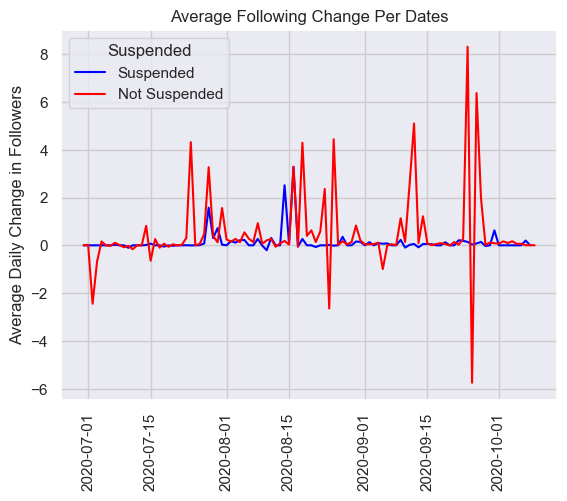

In [188]:
# Some boilerplate to initialise things
sns.set()
plt.figure()

# This is where the actual plot gets made
ax = sns.lineplot(data=P, x="Date", y="Count", hue="Suspended", palette=['blue', 'red'], sort=False)

# Customise some display properties
ax.set_title('Average Following Change Per Dates')
ax.grid(color='#cccccc')
ax.set_ylabel('Average Daily Change in Followers')
ax.set_xlabel(None)
plt.xticks(rotation='vertical')

plt.savefig(results_bucket+'followers_count_change_daily_susvsns.png', bbox_inches='tight')
# Ask Matplotlib to show it
plt.show()

#### Max followers 

In [160]:
P2 = df_train.groupby(['suspended'], as_index=False).agg({"user.followers_count": "max"})
P2 = P2.rename(columns = {'suspended':'Suspended', 'user.followers_count':'Count'})
P2['Suspended'] = P2['Suspended'].map({0:'Not Suspended',1:'Suspended'})
P2.head()

,Suspended,Count
0,Not Suspended,27177.0
1,Suspended,777.0


Max Followers Jump

In [161]:
P2 = df_train.groupby(['suspended'], as_index=False).agg({"follower_diffs": "max"})
P2 = P2.rename(columns = {'suspended':'Suspended', 'follower_diffs':'Count'})
P2['Suspended'] = P2['Suspended'].map({0:'Not Suspended',1:'Suspended'})
P2.head()

,Suspended,Count
0,Not Suspended,11193.0
1,Suspended,721.0


In [189]:
t = df_train[df_train['follower_diffs'] == P2['Count'].iloc[0]]
t = t[['user.screen_name', 'created_at', 'text', 'user.followers_count', 'user.followers_countdailychange', 'follower_diffs']].sort_values(by=['created_at'], ascending=True)
t

,user.screen_name,created_at,text,user.followers_count,user.followers_countdailychange,follower_diffs
38337,ZouYueTweets,2020-09-24 10:31:17,But there is a tendency in America and Europe ...,27177.0,300.111111,11193.0


In [191]:
q = df_train[df_train['user.id'] == df_train[df_train['follower_diffs'] == P2['Count'].iloc[0]]['user.id'].iloc[0]]
q = q[['user.screen_name', 'created_at', 'text', 'user.followers_count', 'user.followers_countdailychange', 'follower_diffs']].sort_values(by=['created_at'], ascending=True)

In [164]:
pd.set_option('display.max_rows', None)
t = df_train[df_train['user.id'] == df_train[df_train['follower_diffs'] == P2['Count'].iloc[0]]['user.id'].iloc[0]]
#t[['user.screen_name', 'created_at', 'text', 'user.followers_count', 'user.followers_countdailychange', 'follower_diffs']].sort_values(by=['created_at'], ascending=True)

In [165]:
t = df_train[df_train['follower_diffs'] == P2['Count'].iloc[1]]
t = t[['user.screen_name', 'created_at', 'text', 'user.followers_count', 'user.followers_countdailychange', 'follower_diffs']].sort_values(by=['created_at'], ascending=True)
t

,user.screen_name,created_at,text,user.followers_count,user.followers_countdailychange,follower_diffs
55793,FiazAhm43415669,2020-08-14 03:07:59,#MyPakistan \nہم تو مٹ جائیں گے اے ارض وطن لیک...,777.0,48.066667,721.0


In [166]:
pd.set_option('display.max_rows', None)
t = df_train[df_train['user.id'] == df_train[df_train['follower_diffs'] == P2['Count'].iloc[1]]['user.id'].iloc[0]]
#t[['id','user.screen_name', 'created_at', 'text', 'user.followers_count', 'user.followers_countdailychange', 'follower_diffs']].sort_values(by=['created_at'], ascending=True)

In [169]:
df_train_accounts.head()

,user.id_,user.screen_name_,id_count,created_at_mean,retweet_count_sum,retweet_count_mean,favorite_count_sum,favorite_count_mean,user.created_at_mean,user.favourites_count_mean,user.favourites_count_max,user.followers_count_mean,user.followers_count_max,user.friends_count_mean,user.friends_count_max,user.listed_count_mean,user.listed_count_max,user.statuses_count_mean,user.statuses_count_max,user_age_mean,user_age_max,tweets_per_day_max,since_last_tweet_mins_min,since_last_tweet_mins_mean,since_last_tweet_mins_max,avg_tweets_per_hr_mean,avg_tweets_per_day_mean,followers_per_followees_mean,followers_per_followees_min,followers_per_followees_max,containsURL_sum,no_urls_per_tweet_mean,no_hashtags_per_tweet_mean,no_mentions_per_tweet_mean,user.followers_countdailychange_mean,user.followers_countdailychange_max,user.friends_countdailychange_mean,user.friends_countdailychange_max,user.friend_rate_mean,user.friend_rate_max,user.followers_rate_mean,user.followers_rate_max,user.has_url_mean,user.has_location_mean,user.screen_name.digit_length_mean,user.screen_name.length_mean,is_reply_sum,suspended_mean
0,1.278130e+18,MMunir50647063,1,1.593709e+09,0.0,0.000000,0.0,0.000000,1.593565e+09,5.000000,5.0,1.000000,1.0,60.000000,60.0,0.000000,0.0,1.000000,1.0,1.000000,1,1.000000,NaN,NaN,NaN,2.000000,2.000000,0.016667,0.016667,0.016667,0,0.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,60.000000,60.000000,1.000000,1.0,0.0,0.0,8,14,0,Not Suspended
1,1.278132e+18,3qex2,63,1.595097e+09,1256.0,19.936508,76.0,1.206349,1.593565e+09,14.238095,19.0,829.809524,1556.0,36.666667,40.0,0.238095,1.0,51.095238,63.0,17.349206,55,63.000000,0.066667,308.166129,1321.633333,3.818182,6.300000,20.823521,0.939394,38.900000,27,0.555556,0.777778,1.238095,40.131579,40.131579,0.184211,0.184211,11.293454,40.000000,222.766454,1556.0,1.0,0.0,2,5,26,Not Suspended
2,1.278136e+18,SueleWui,1,1.594360e+09,0.0,0.000000,0.0,0.000000,1.593566e+09,7.000000,7.0,0.000000,0.0,20.000000,20.0,0.000000,0.0,1.000000,1.0,9.000000,9,0.111111,NaN,NaN,NaN,2.000000,2.000000,0.000000,0.000000,0.000000,1,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,2.222222,2.222222,0.000000,0.0,0.0,0.0,0,8,0,Not Suspended
3,1.278138e+18,LeoWang72378273,2,1.593618e+09,0.0,0.000000,0.0,0.000000,1.593567e+09,3.000000,3.0,1.000000,1.0,46.000000,46.0,0.000000,0.0,2.000000,2.0,0.500000,1,inf,215.816667,215.816667,215.816667,2.000000,2.000000,0.021739,0.021739,0.021739,0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,inf,inf,inf,inf,0.0,0.0,8,15,1,Not Suspended
4,1.278143e+18,o6EOrfNWQkCsWDu,127,1.593933e+09,1.0,0.007874,144.0,1.133858,1.593568e+09,228.267717,245.0,1.000000,1.0,29.000000,29.0,0.000000,0.0,107.031496,109.0,3.881890,67,inf,0.000000,104.528836,1344.166667,5.625000,20.454545,0.034483,0.034483,0.034483,34,0.253333,0.000000,2.480000,0.000000,0.000000,0.000000,0.000000,inf,inf,inf,inf,0.0,0.0,1,15,126,Not Suspended


#### Zero Followers comparison

In [177]:
df_train_accounts['zero_foll'] = (df_train_accounts['user.followers_count_max'] == 0)
P = df_train_accounts.groupby(['suspended_mean', 'zero_foll'])['user.id_'].count().reset_index()
P = P.rename(columns = {'suspended_mean':'Suspended', 'user.id_':'Count'})
P['Total_sus'] = P.groupby('Suspended')['Count'].transform('sum')
P['Proportion'] = P['Count']/P['Total_sus']
P

,Suspended,zero_foll,Count,Total_sus,Proportion
0,Not Suspended,False,979,1450,0.675172
1,Not Suspended,True,471,1450,0.324828
2,Suspended,False,79,103,0.766990
3,Suspended,True,24,103,0.233010


#### Follower Daily Jumps 

Histograms of Follower rate jumps

Max

Suspended

In [178]:
P1 = df_train[df_train['suspended'] == 1].groupby(
   ['user.id', 'user.screen_name'], as_index=False
).agg(
    {
         'user.followers_countdailychange': 'max'
    }
).dropna(subset=['user.followers_countdailychange']).sort_values(by=['user.followers_countdailychange'], ascending=False)

P1['user.followers_countdailychange'] = P1['user.followers_countdailychange'].round().astype('int')

P1.to_csv(results_bucket+'susp_max_follower_count_dailychange.csv', index=False, encoding = "utf_8_sig")
P1.head(6)

,user.id,user.screen_name,user.followers_countdailychange
40,1.281465e+18,FiazAhm43415669,48
51,1.282021e+18,Azee84757895,27
48,1.281774e+18,3wuyong9065,6
75,1.284548e+18,jackson40661935,6
11,1.278975e+18,BABA54973782,2
49,1.281953e+18,Eahinson1,1


Suspended

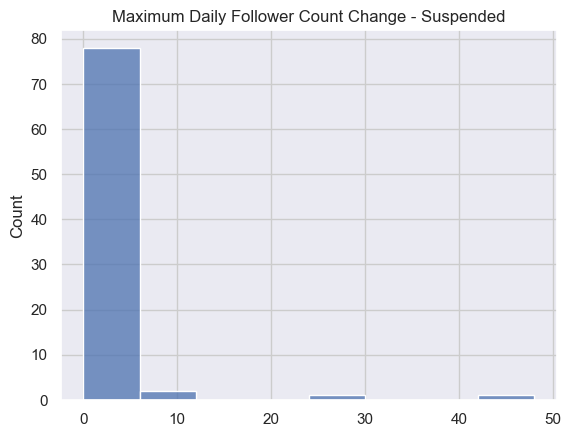

In [179]:
# Some boilerplate to initialise things
sns.set()
plt.figure()

# This is where the actual plot gets made
ax = sns.histplot(data=P1, x='user.followers_countdailychange', palette=['blue'])

# Customise some display properties
ax.set_title('Maximum Daily Follower Count Change - Suspended')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel(None)

# Ask Matplotlib to show it
plt.savefig(results_bucket+'suspended_max_followers_count_change_daily.png', bbox_inches='tight')
plt.show()

Non-Suspended

In [180]:
P = df_train[df_train['suspended'] == 0].groupby(
   ['user.id', 'user.screen_name'], as_index=False
).agg(
    {
         'user.followers_countdailychange': 'max'
    }
).dropna(subset=['user.followers_countdailychange']).sort_values(by=['user.followers_countdailychange'], ascending=False)

P['user.followers_countdailychange'] = P['user.followers_countdailychange'].round().astype('int')

P.to_csv(results_bucket+'susp_max_follower_count_dailychange.csv', index=False, encoding = "utf_8_sig")
P.head(6)

,user.id,user.screen_name,user.followers_countdailychange
457,1.280110e+18,ZouYueTweets,300
1194,1.284729e+18,reborn_pandora,231
712,1.281591e+18,CouncilCricket,51
1,1.278132e+18,3qex2,40
869,1.282521e+18,Salmana55622220,34
1227,1.285058e+18,sunarghanashya3,34


In [181]:
len(P[P['user.followers_countdailychange'] > P1['user.followers_countdailychange'].max()])

3

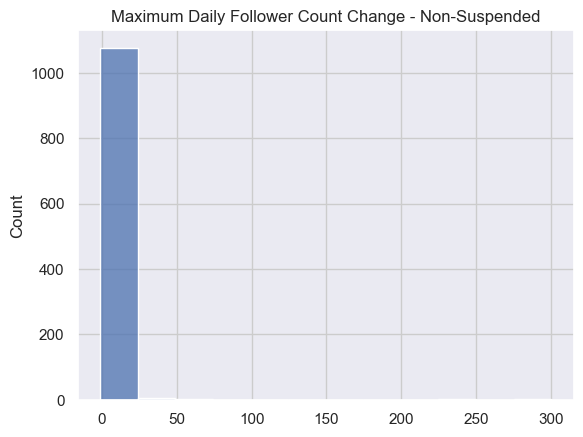

In [182]:
# Some boilerplate to initialise things
sns.set()
plt.figure()

# This is where the actual plot gets made
ax = sns.histplot(data=P, x='user.followers_countdailychange', palette=['blue'])

# Customise some display properties
ax.set_title('Maximum Daily Follower Count Change - Non-Suspended')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel(None)

# Ask Matplotlib to show it
plt.savefig(results_bucket+'non_suspended_max_followers_count_change_daily.png', bbox_inches='tight')
plt.show()

## Friend Counts [INCLUDED]

In [183]:
df_train.sort_values(by=['user.id', 'created_at'], inplace=True)

# for this example, with diff, I think this syntax is a bit clunky
# but for more general examples, this should be good.  But can we do better?
df_train['friend_diffs'] = df_train.groupby(['user.id'])['user.friends_count'].transform(lambda x: x.diff()) 

df_train.sort_index(inplace=True)

In [184]:
P = df_train_accounts.groupby(['suspended_mean'], as_index=False).agg({"user.friends_count_max": ["mean", "std"]})
P.head()

suspended_mean user.friends_count_max            
                                   mean         std
0  Not Suspended             135.677241  309.528849
1      Suspended             132.786408  181.781255

In [185]:
P = df_train.groupby(['created_at_dmy','suspended'], as_index=False).agg({"friend_diffs": "mean"})
P = P.rename(columns = {'created_at_dmy':'Date','suspended':'Suspended', 'friend_diffs':'Count'})
P['Suspended'] = P['Suspended'].map({0:'Not Suspended',1:'Suspended'})
P['Date'] = pd.to_datetime(P['Date'], infer_datetime_format=True).dt.date
P = P.sort_values(by=['Date'])
P.head()

,Date,Suspended,Count
125,2020-06-30,Suspended,0.000000
124,2020-06-30,Not Suspended,0.000000
63,2020-07-01,Suspended,0.000000
62,2020-07-01,Not Suspended,-0.005102
64,2020-07-02,Not Suspended,1.601980


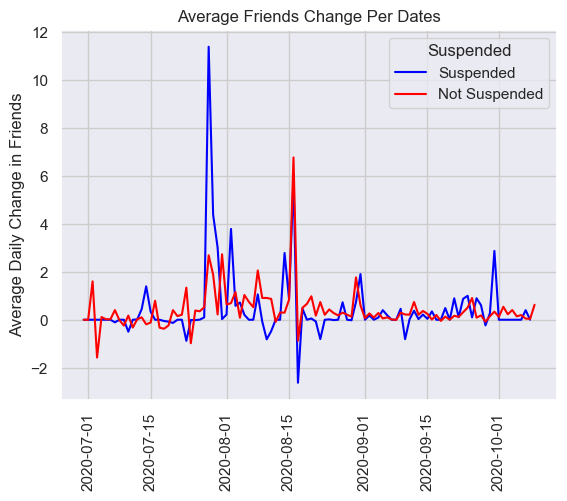

In [186]:
# Some boilerplate to initialise things
sns.set()
plt.figure()

# This is where the actual plot gets made
ax = sns.lineplot(data=P, x="Date", y="Count", hue="Suspended", palette=['blue', 'red'], sort=False)

# Customise some display properties
ax.set_title('Average Friends Change Per Dates')
ax.grid(color='#cccccc')
ax.set_ylabel('Average Daily Change in Friends')
ax.set_xlabel(None)
plt.xticks(rotation='vertical')

plt.savefig(results_bucket+'friends_count_change_daily_susvsns.png', bbox_inches='tight')
# Ask Matplotlib to show it
plt.show()

#### Max Friends

In [192]:
P2 = df_train.groupby(['suspended'], as_index=False).agg({"friend_diffs": "max"})
P2 = P2.rename(columns = {'suspended':'Suspended', 'friend_diffs':'Count'})
P2['Suspended'] = P2['Suspended'].map({0:'Not Suspended',1:'Suspended'})
P2.head()

,Suspended,Count
0,Not Suspended,2217.0
1,Suspended,801.0


In [193]:
t = df_train[df_train['friend_diffs'] == P2['Count'].iloc[0]]
t = t[['user.screen_name', 'created_at', 'text', 'user.friends_count', 'user.friends_countdailychange', 'friend_diffs']].sort_values(by=['created_at'], ascending=True)
t

,user.screen_name,created_at,text,user.friends_count,user.friends_countdailychange,friend_diffs
76906,Salmana55622220,2020-08-16 14:41:34,@sadiasnoor Ameen,3855.0,67.180556,2217.0


In [194]:
t = df_train[df_train['friend_diffs'] == P2['Count'].iloc[1]]
t = t[['user.screen_name', 'created_at', 'text', 'user.friends_count', 'user.friends_countdailychange', 'friend_diffs']].sort_values(by=['created_at'], ascending=True)
t

,user.screen_name,created_at,text,user.friends_count,user.friends_countdailychange,friend_diffs
55793,FiazAhm43415669,2020-08-14 03:07:59,#MyPakistan \nہم تو مٹ جائیں گے اے ارض وطن لیک...,894.0,53.4,801.0


#### Zero Friends comparison

In [498]:
df_train_accounts['zero_friend'] = (df_train_accounts['user.friends_count_max'] == 0)
P = df_train_accounts.groupby(['suspended_mean', 'zero_friend'])['user.id_'].count().reset_index()
P = P.rename(columns = {'suspended_mean':'Suspended', 'user.id_':'Count'})
P['Total_sus'] = P.groupby('Suspended')['Count'].transform('sum')
P['Proportion'] = P['Count']/P['Total_sus']
P

,Suspended,zero_friend,Count,Total_sus,Proportion
0,Not Suspended,False,1437,1440,0.997917
1,Not Suspended,True,3,1440,0.002083
2,Suspended,False,109,110,0.990909
3,Suspended,True,1,110,0.009091


#### Max Daily Friends Increase Range of Acounts

Suspended

In [285]:
P1 = df_train[df_train['suspended'] == 1].groupby(
   ['user.id', 'user.screen_name'], as_index=False
).agg(
    {
         'user.friends_countdailychange': 'max'
    }
).dropna(subset=['user.friends_countdailychange']).sort_values(by=['user.friends_countdailychange'], ascending=False)

P1['user.friends_countdailychange'] = P1['user.friends_countdailychange'].round().astype('int')

P1.to_csv(results_bucket+'susp_max_friend_count_dailychange.csv', index=False, encoding = "utf_8_sig")
P1.head(6)

,user.id,user.screen_name,user.friends_countdailychange
43,1.281465e+18,FiazAhm43415669,53
81,1.284548e+18,jackson40661935,38
49,1.282021e+18,Azee84757895,34
47,1.281774e+18,3wuyong9065,16
0,1.278120e+18,SFAC_TFA_CN,13
87,1.285184e+18,rh2452015,10


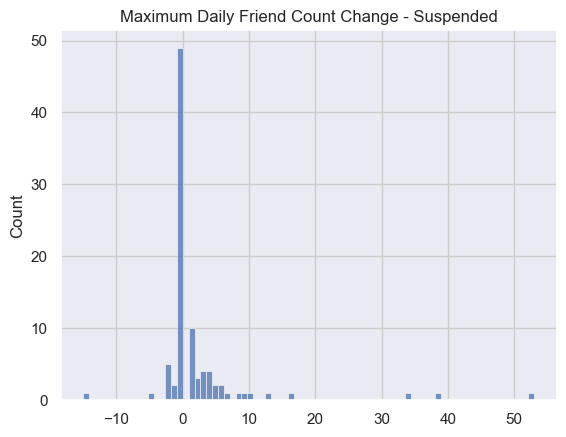

In [286]:
# Some boilerplate to initialise things
sns.set()
plt.figure()

# This is where the actual plot gets made
ax = sns.histplot(data=P1, x='user.friends_countdailychange', palette=['blue'])

# Customise some display properties
ax.set_title('Maximum Daily Friend Count Change - Suspended')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel(None)

# Ask Matplotlib to show it
plt.savefig(results_bucket+'suspended_max_friends_count_change_daily.png', bbox_inches='tight')
plt.show()

Non-Suspended

In [287]:
P = df_train[df_train['suspended'] == 0].groupby(
   ['user.id', 'user.screen_name'], as_index=False
).agg(
    {
         'user.friends_countdailychange': 'max'
    }
).dropna(subset=['user.friends_countdailychange']).sort_values(by=['user.friends_countdailychange'], ascending=False)

P['user.friends_countdailychange'] = P['user.friends_countdailychange'].round().astype('int')

P.to_csv(results_bucket+'non_susp_max_friend_count_dailychange.csv', index=False, encoding = "utf_8_sig")
P.head(6)

,user.id,user.screen_name,user.friends_countdailychange
1254,1.285265e+18,Goosegi37187708,281
1424,1.286862e+18,omEr0qi8un0ZCBG,263
276,1.279271e+18,Ankit13168056,198
1406,1.286691e+18,mouse_song,181
1422,1.286839e+18,0TnE5IV0T2ELXU1,160
749,1.281825e+18,MalakShoaibNaw1,146


In [288]:
len(P[P['user.friends_countdailychange'] > P1['user.friends_countdailychange'].max()])

20

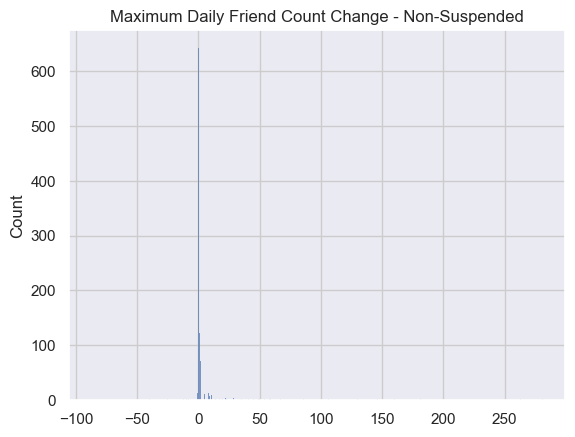

In [289]:
# Some boilerplate to initialise things
sns.set()
plt.figure()

# This is where the actual plot gets made
ax = sns.histplot(data=P, x='user.friends_countdailychange', palette=['blue'])

# Customise some display properties
ax.set_title('Maximum Daily Friend Count Change - Non-Suspended')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel(None)

# Ask Matplotlib to show it
plt.savefig(results_bucket+'non_suspended_max_friends_count_change_daily.png', bbox_inches='tight')
plt.show()

#### Followers/Friends Ratio Calculation

In [247]:
P = df_train_accounts.replace([np.inf, 0], np.nan).groupby(
   ['suspended_mean'], as_index=False
).agg(
    {
         'followers_per_followees_mean': ['mean', 'std'] 
    }
)

P.to_csv(results_bucket+'followers_per_followee.csv', index=False, encoding = "utf_8_sig")
P

suspended_mean followers_per_followees_mean           
                                         mean        std
0  Not Suspended                     0.399804  10.285743
1      Suspended                     0.159463   0.274397

In [251]:
df_train_accounts['inf_ratio'] = (np.isinf(df_train_accounts['followers_per_followees_mean']))

In [259]:
P = df_train_accounts.groupby(['suspended_mean', 'inf_ratio'])['user.id_'].count().reset_index()
P = P.rename(columns = {'suspended_mean':'Suspended', 'user.id_':'Count'})
P['Total_sus'] = P.groupby('Suspended')['Count'].transform('sum')
P['Proportion'] = P['Count']/P['Total_sus']
P

,Suspended,inf_ratio,Count,Total_sus,Proportion
0,Not Suspended,False,1448,1450,0.998621
1,Not Suspended,True,2,1450,0.001379
2,Suspended,False,94,103,0.912621
3,Suspended,True,9,103,0.087379


# Topic Modeling 

In [21]:
df_train = df_train.drop(['lang_False'], axis=1)
df_train['lang'] = pd.get_dummies(df_train.iloc[:,80:138]).idxmax(1).str[5:]

Remove Emoji Text

In [22]:
#### Load in data from S3

# Import Train and Measure Balance
# Import Flattened Data
lda_train = pd.read_csv(lda_data + "train_withemojis.csv", error_bad_lines=False, encoding='utf-8')
len(df_train)

115766

Bring in Mallet

In [34]:
# Note: To run this script, you'll need to download the Mallet library here:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python
# See Section 16 for the mallet download link.
# You'll need to rename the mallet package from 'mallet-2.0.8' to 'mallet' and save directly under your C drive (C:)
# Please note that as mallet is written in Java, you'll need Java installed on your computer as well
# https://www.java.com/en/download/ 
mallet_path='/Users/christian.conroy/Documents/suspension_project/mallet/bin/mallet'
os.environ.update({'MALLET_PATH':r'/Users/christian.conroy/Documents/suspension_project/mallet/'})

Set Parmeters

In [27]:
# Add output path for script results
output_path_suspended = 'data/s3_data/eda_output/topicmodeling/suspended/'
output_path_english = 'data/s3_data/eda_output/topicmodeling/suspended_english/'
output_path_chinese= 'data/s3_data/eda_output/topicmodeling/suspended_chinese/'
output_path_not_suspended = 'data/s3_data/eda_output/topicmodeling/not_suspended/'
output_path_not_suspended_english = 'data/s3_data/eda_output/topicmodeling/not_suspended_english/'
output_path_not_suspended_chinese = 'data/s3_data/eda_output/topicmodeling/not_suspended_chinese/'
output_path_suspended_last_tweet = 'data/s3_data/eda_output/topicmodeling/suspended_last_tweet/'
output_path_suspended_last_tweet_english = 'data/s3_data/eda_output/topicmodeling/suspended_last_tweet_english/'
output_path_suspended_last_tweet_chinese = 'data/s3_data/eda_output/topicmodeling/suspended_last_tweet_chinese/'

# Add additional stopwords for removal as needed 
customstopwords = []

# The k_list indicates how many "number of topics" the model will try.
# List can be updated depending on the size/complexity of the dataset.
# Note: While 1 and 2 topics typically don't produce significant results, their inclusion
# assists when inpretating the coherence graph with the elbow method.
k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Indicate whether you would like to filter by TF-IDF. 
# This will filter out terms that are common across the dataset. 
# Effectiveness of TF-IDF filtering on social media data is limited.
filter_TF_IDF = True

text_column = "text"
mentions_column = "no_mentions"

Clean text documents and identify languages

In [36]:
def normalize(txt):
    '''Removes web links, usernames, punctuation, and most special characters from a text document.'''
    reg_link = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    reg_punc = re.compile("""[`\!#$%&'()*\+,\-\«\•\»\_\.\/\:\;\"\“\”\<\=\>\?\@\[\]^`{|}~…]""")
    reg_num = re.compile('[0-9]+')
    reg_user = re.compile('\@\w+')
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           #u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    try:
        nolink = str(txt)
        # Remove links
        nolink = reg_link.sub('', nolink.lower())
        nolink = re.sub(r'bit.ly/\S+', '', nolink) # rempve bitly links
        nolink = nolink.replace('nan','')
        # Remove usernames
        nolink = reg_user.sub('', nolink)
        # Remove ampersands
        nolink = nolink.replace('&amp;', '')
        nolink = nolink.replace("'", '')
        # Remove punctuation
        nolink = reg_punc.sub(' ', nolink)
        # Remove emjois 
        nolink = emoji_pattern.sub(' ', nolink)
        # Remove raw numbers
        nolink = reg_num.sub('', nolink)
        # Remove spacing 
        nolink = re.sub('\s+', ' ', nolink) #remove double spacing
        # Verify punctuation removed
        nolink = reg_punc.sub(' ', nolink)
        nolink = nolink.lstrip(' ')
    except:
        nolink = ""
    return nolink

#def strip_mens(text, mens):
   # nolink = re.compile('\#').sub('', re.compile('RT ').sub('', text, count=1).strip())
    #nolink = ' '.join(nolink.split(' ')[int(mens):])
    #return nolink

def clean_and_find_lang(df):
    '''Creates new column with cleaned text documents. Creates new column with identified language for each document.'''

    # Apply normalize function to each text document. Add results to new column.
    #df['cleantext'] = df.apply(lambda x: strip_mens(x[text_column], x[mentions_column]), axis=1)
    documents = df[text_column].apply(lambda x: normalize(x)) #Previously clean_text
    df['cleantext'] = documents
    empties = [x for x in df['cleantext'] if x == ""]
    emps = len(empties)
    print(f'There are {emps} empty rows after text cleaning')
    
    # Iterate through cleaned text and identify language with langdetect. Add results to new column.
    #lang_result = []
    #for i, text in enumerate(df.cleantext):
     #   try:
      #      lang_result.append(str(model.predict(text)[0][0]).replace("__label__", ""))
       # except:
        #    lang_result.append('unknown')
    #df['langdetected'] = lang_result

    # Iterate through cleaned text and identify language with langdetect. Add results to new column.
    lang_result = []
    for i, text in enumerate(df.cleantext):
        try:
            lang_result.append(detect(text))
        except:
            lang_result.append('unknown')
    df['langdetected'] = lang_result
    

    
    return df

In [214]:
start_time = time.time()

df = clean_and_find_lang(lda_train)

print("--- %s seconds ---" % (time.time() - start_time))

There are 7228 empty rows after text cleaning
--- 554.9436511993408 seconds ---


In [215]:
df.head(3)

,created_at,id,text,lang,user.created_at,user.id,user.screen_name,suspended,cleantext,langdetected
0,1.594984e+09,1.284081e+18,I just deployed a high performance cloud serve...,en,1.594900e+09,1.283731e+18,pioodxt,0.0,i just deployed a high performance cloud serve...,en
1,1.595855e+09,1.287736e+18,@Huawei @GuoPing_Huawei 顶顶顶顶顶顶顶顶,ja,1.594042e+09,1.280132e+18,MrZha999,0.0,顶顶顶顶顶顶顶顶,zh-cn
2,1.595855e+09,1.287736e+18,@XflJasmine 台独：她是大陆嫁过来的,zh,1.594042e+09,1.280132e+18,MrZha999,0.0,台独：她是大陆嫁过来的,zh-cn


Save

In [216]:
df.to_csv(results_bucket+'lang_detect_preprocessed.csv', index=False, encoding = "utf_8_sig")

Load back in

In [217]:
df = pd.read_csv(results_bucket + "lang_detect_preprocessed.csv", error_bad_lines=False, encoding='utf-8')

In [218]:
from hanziconv import HanziConv
df['cleantext'] = df.apply(lambda x: HanziConv.toSimplified(x['cleantext']) if x['langdetected'] == "zh-tw" else x['cleantext'], axis = 1)

In [222]:
df['langdetected'] = df['lang']

Load in Chinese Stopwords

In [223]:
chst = pd.read_csv("https://raw.githubusercontent.com/stopwords-iso/stopwords-zh/master/stopwords-zh.txt", error_bad_lines=False, encoding='utf-8', header = None)

In [224]:
# Dictionary of languages supported by langdetect and their NLTK equivalent:
detected_lang_to_stopwords = {'ar' : 'arabic', 'da' : 'danish', 'nl' : 'dutch', 'en' : 'english', 'fi' : 'finnish', 'de' : 'german', 'el' : 'greek', 'hu' : 'hungarian',
                              'id' : 'indonesian', 'it' : 'italian', 'ne' : 'nepali', 'no' : 'norwegian', 'pt' : 'portuguese', 'ro' : 'romanian', 'ru' : 'russian', 'sl' : 'slovene',
                              'es' : 'spanish', 'sv' : 'swedish', 'tr' : 'turkish', 'zh-cn' : 'chinese'}

# Manually added Chinese to path from here: https://raw.githubusercontent.com/stopwords-iso/stopwords-zh/master/stopwords-zh.txt

def identify_stopwords(lang_abrv):
    ''' Convert langdetect results of ISO 639-1 codes to full language names, 
    which is interpretable by the NLTK package '''
    try:
        lang = detected_lang_to_stopwords.get(lang_abrv)
    except:
        pass
    return lang

def remove_stopwords(text, lang, stopword_set):
    ''' Remove stopwords from each text documents '''
    if lang == 'zh':
        tokens = SnowNLP(text).words 
    elif lang == 'ja':
        tokens = SnowNLP(text).words
    else: 
        tokens = text.split()
    nostopwrd = [word for word in tokens if word not in stopword_set]    
    return nostopwrd

def tokenize_docs(text, lang):
    ''' Tokenize each text document into a bag of words '''
    if lang == 'zh':
        tokens = SnowNLP(text)
        token_list = tokens.words
    elif lang == 'ja':
        tokens = SnowNLP(text)
        token_list = tokens.words
    else: 
        tokens = text.split()
        token_list = [word for word in tokens]
    return token_list

def make_bigrams(text, bigram_mod):
    ''' Identify and make bigrams using the gensim Phraser model
    Inputs: Text document as a bag of words, bigram model
    Output: Text document as a bag of words with bigrams
    '''
    return bigram_mod[text]

# Note: Snowball Stemmer also available in 
# Danish, Dutch, Hungarian, Italian, Norwegian, Portuguese, Romanian, and Swedish
def get_stemmer(lang):
    ''' Convert langdetect results (uses ISO 639-1 codes) to full language names, 
    which is interpretable by the Snowball Stemmer '''
    if lang == 'en':
        stemmer = SnowballStemmer("english")
    elif lang == 'es':
        stemmer = SnowballStemmer("spanish")
    elif lang == 'fr':
        stemmer = SnowballStemmer("french")
    elif lang == 'de':
        stemmer = SnowballStemmer("german")
    elif lang == 'ru':
        stemmer = SnowballStemmer("russian")
    else:
        stemmer = 'notfound'
    return stemmer

def stemming(text, lang):
    ''' Stem each text document. If stemmer not defined in get_stemmer function, 
    text document will remain unstemmed.
    Inputs: Text document as a bag of words, identified language
    Output: Stemmed text document as a bag of words stemmed
    '''
    processed_content = []
    stemmer = get_stemmer(lang)
    
    if stemmer == 'notfound':
        return text
    else:
        for word in text:
            stemmed_word = stemmer.stem(word)
            processed_content.append(stemmed_word)    
        return processed_content


In [225]:
def preprocessing(df):
    ''' Remove stopwords based on detected languages, make bigrams, and stem words 
    using the above defined helper functions.
    Input: Dataframe
    Output: Dateframe with three additional columns: no_stopwords, with_bi_grams, stemmed_docs
    '''
    stopword_set = set()
    count_df = (df.groupby('langdetected')
                .size()
                .sort_values(ascending = False)
                .reset_index())
    count_df.rename(columns={0:'counts'}, inplace=True)
    count_df['percentage'] = count_df.counts/count_df.counts.sum()
    count_df2 = count_df.where(count_df.percentage > 0.02).dropna()
    print(count_df2.drop(columns=['counts']))

    # Identify stopwords from langauges
    lang_list = [identify_stopwords(x) for x in count_df2['langdetected']]
    for lang in lang_list:
        temp_stopwords = set(stopwords.words(lang))
        stopword_set.update(temp_stopwords)
    stopword_set.update(['rt'], customstopwords)
    stopword_set.update(['rt'], chst[0].tolist())
    
    # Remove stopwords - Consider taking out if it does not add anything since not using it anyways
    nostopwords = df.apply(lambda x: remove_stopwords(x['cleantext'], x['langdetected'], stopword_set), axis=1)
    df['no_stopwords'] = nostopwords
    print('Stopwords removed')
    
    # Stem words
    stemmed_docs = []
    for i, text in enumerate(df.no_stopwords):
        stemmed_docs.append(stemming(text, df.langdetected[i]))
    df['stemmed_docs'] = stemmed_docs
    print('Stemming complete')
    
    # Prepare bigram models
    docs_tokens = docs_tokens = df.apply(lambda x: tokenize_docs(x['cleantext'], x['langdetected']), axis=1)
    # docs_tokens = [tokenize_docs(doc) for doc in df['cleantext'].astype("str")]
    bigram = gensim.models.Phrases(docs_tokens, min_count=5, threshold=100)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    
    # Identify bigrams
    bi_grams = df['stemmed_docs'].apply(lambda x: make_bigrams(x, bigram_mod))
    df['with_bigrams'] = bi_grams
    print('Bigrams identified')   

    return df, stopword_set

###




In [226]:
df['cleantext'] = df['cleantext'].astype('str')
df, stopword_set = preprocessing(df)

  langdetected  percentage
0           en    0.346380
1           zh    0.272387
2           ur    0.127691
3          und    0.085234
4           ja    0.045161
5        False    0.025450
6           hi    0.022601
Stopwords removed
Stemming complete
Bigrams identified


In [227]:
df = df.dropna(subset=['cleantext'])
df.head(3)

,created_at,id,text,lang,user.created_at,user.id,user.screen_name,suspended,cleantext,langdetected,no_stopwords,stemmed_docs,with_bigrams
0,1.594984e+09,1.284081e+18,I just deployed a high performance cloud serve...,en,1.594900e+09,1.283731e+18,pioodxt,0.0,i just deployed a high performance cloud serve...,en,"[deployed, high, performance, cloud, server, i...","[deploy, high, perform, cloud, server, ilovevu...","[deploy, high, perform, cloud, server, ilovevu..."
1,1.595855e+09,1.287736e+18,@Huawei @GuoPing_Huawei 顶顶顶顶顶顶顶顶,ja,1.594042e+09,1.280132e+18,MrZha999,0.0,顶顶顶顶顶顶顶顶,ja,"[顶顶, 顶顶, 顶顶, 顶顶]","[顶顶, 顶顶, 顶顶, 顶顶]","[顶顶, 顶顶, 顶顶, 顶顶]"
2,1.595855e+09,1.287736e+18,@XflJasmine 台独：她是大陆嫁过来的,zh,1.594042e+09,1.280132e+18,MrZha999,0.0,台独：她是大陆嫁过来的,zh,"[台独, 大陆, 嫁, 过来]","[台独, 大陆, 嫁, 过来]","[台独, 大陆, 嫁, 过来]"


In [228]:
df.to_csv(results_bucket+'lang_detect_preprocessed_final.csv', index=False, encoding = "utf_8_sig")

In [49]:
df = pd.read_csv(results_bucket + "lang_detect_preprocessed_final.csv", error_bad_lines=False, encoding='utf-8')

In [50]:
from ast import literal_eval
df['with_bigrams'] = df['with_bigrams'].apply(lambda x: literal_eval(x))
df['no_stopwords'] = df['no_stopwords'].apply(lambda x: literal_eval(x))
df['stemmed_docs'] = df['stemmed_docs'].apply(lambda x: literal_eval(x))

Run LDA model

Suspended

In [51]:
df_suspended = df[df['suspended'] == 1]
df_suspended.head(3)

,created_at,id,text,lang,user.created_at,user.id,user.screen_name,suspended,cleantext,langdetected,no_stopwords,stemmed_docs,with_bigrams
431,1.594039e+09,1.280119e+18,你可拉倒吧，川建国同志 https://t.co/TiQ7VFCQDv,ja,1.594038e+09,1.280116e+18,neverla84324958,1.0,你可拉倒吧，川建国同志,ja,"[可拉, 倒, 川, 建国, 同志]","[可拉, 倒, 川, 建国, 同志]","[可拉, 倒, 川_建国, 同志]"
1689,1.595745e+09,1.287273e+18,@waytofreedomhk 最尾一句改為其實你哋係隻狗，有冇得諗？,zh,1.594004e+09,1.279972e+18,FreeHK74146631,1.0,最尾一句改為其實你哋係隻狗，有冇得諗？,zh,"[最尾, 句, 改, 為, 實, 哋, 係, 隻, 狗, 冇得, 諗]","[最尾, 句, 改, 為, 實, 哋, 係, 隻, 狗, 冇得, 諗]","[最尾, 句, 改, 為, 實, 哋, 係, 隻, 狗, 冇得, 諗]"
1690,1.595683e+09,1.287015e+18,@scarlet38556495 其實，英國也對中國很好。他說中英聯合聲明是過時文件。英國便...,zh,1.594004e+09,1.279972e+18,FreeHK74146631,1.0,其实，英国也对中国很好。他说中英联合声明是过时文件。英国便给bno人事入借机会。大家都太宠中...,zh,"[其实, 英国, 中国, 英, 联合, 声明, 过时, 文件, 英国, 便, bno, 人事...","[其实, 英国, 中国, 英, 联合, 声明, 过时, 文件, 英国, 便, bno, 人事...","[其实, 英国, 中国, 英, 联合, 声明, 过时, 文件, 英国, 便, bno, 人事..."


In [233]:
def run_model(df):
    ''' Using the preprocessed text documents, create dictionary and corpus. 
    Filter by TF-IDF if requested. Run LDA mallet model.
    Input: Dataframe
    Outputs: List of model results and corresponding coherence scores
    '''
    # Create Dictionary. Assigns each word in dataset a number
    processed_docs = df['with_bigrams']
    dictionary = corpora.Dictionary(processed_docs)

    # Create Corpus. Marks how many times each word occurs in the dataset
    corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

    # Filter by low TF-IDF values
    if filter_TF_IDF == True:
        tfidf = TfidfModel(corpus, id2word=dictionary)
        low_value = 0.04
        low_value_words = []
        for bow in corpus:
            low_value_words += [id for id, value in tfidf[bow] if value < low_value]

        dictionary.filter_tokens(bad_ids=low_value_words)
        corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
    
    coherence_values = []
    model_list = []
    
    # Run LDA model for each number of topics provided in the k_list
    for num_topics in k_list:
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary, random_seed=123)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    
    return model_list, coherence_values 

In [244]:
model_list, coherence_values = run_model(df_suspended)

Select number of topics

In [245]:
def plot_coherence(coherence_values):
    ''' Plot coherence score for each model result '''
    plt.plot(k_list, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    return

def select_topic_number(model_list, coherence_values):
    ''' Request user input on coherence graph. Display top words for selected model choice.
    Inputs: Model list and coherence scores
    Outputs: User's choice for number of topics
    '''
    # Print out coherence scores
    for k in range(0,len(k_list)):
        print("# of Topics: " + str(k_list[k]) + " Coherence Score: " + str(coherence_values[k]))

    # Request input from user
    number_of_topics_str = input("\n Select the number of topics that best fit the dataset. Choose from the following: " + str(list(k_list)) + "\n")
    number_of_topics = int(number_of_topics_str)
    
    # Validate user input 
    if number_of_topics not in k_list:
        raise ValueError("Your choice of k was not in " + str(list(k_list)))
        return
    else:
        # Retrieve model results for the selected number of topics
        index_of_model = k_list.index(number_of_topics)
        optimal_model = model_list[index_of_model]
        num_topics = optimal_model.num_topics
        if number_of_topics != num_topics:
            raise ValueError("The model doesn't have the number of topics you requested")
        
        # Display top words for each topic
        else:
            top_words = optimal_model.show_topics(num_topics = number_of_topics, formatted=True, num_words = 10)
            print("\n-------------------- Top Words per Topic --------------------")
            for w in top_words:
                temp_list = re.findall(r'"(.*?)"', w[1])
                print("Topic " + str(w[0]+1) + ": " + str(temp_list))
            print("\n***Review top words. The most relevant words are listed first. You may rerun this cell and try a different number of topics.")
        return number_of_topics

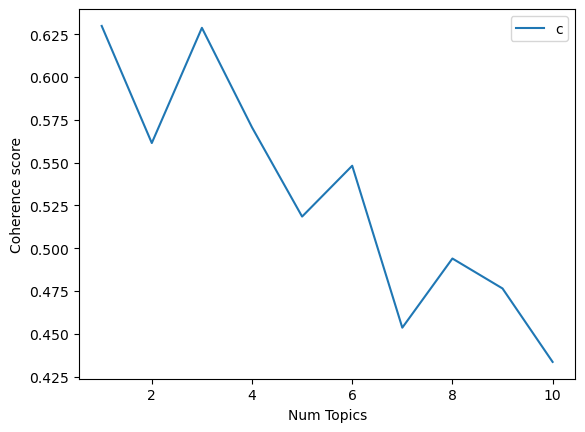

# of Topics: 1 Coherence Score: 0.629899084056672
# of Topics: 2 Coherence Score: 0.5614741771949131
# of Topics: 3 Coherence Score: 0.6287898816244978
# of Topics: 4 Coherence Score: 0.5706380919389344
# of Topics: 5 Coherence Score: 0.5185053555975684
# of Topics: 6 Coherence Score: 0.5482081182383252
# of Topics: 7 Coherence Score: 0.4535931415063903
# of Topics: 8 Coherence Score: 0.4940033547422057
# of Topics: 9 Coherence Score: 0.47651155779884746
# of Topics: 10 Coherence Score: 0.4335859779691578



 Select the number of topics that best fit the dataset. Choose from the following: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
 6



-------------------- Top Words per Topic --------------------
Topic 1: ['美国', '中国', '没有', '国家', '知道', '现在', '人民', '美', '应该', '世界']
Topic 2: ['nan', '香港', '搞', '支持', '越', '國', '万', '出', '子', '新']
Topic 3: ['bl_bl', '没', '狗', '太', '真', '想', '死', 'کھپ_ناڈالو', 'رسیدیں_نکالو', '你妈']
Topic 4: ['pakistan', 'india', 'mypakistan', 'china', 'countri', 'chines', 'day', 'pleas', 'today', 'year']
Topic 5: ['کے', 'کی', 'میں', 'کا', 'کو', 'ہے', 'سے', 'اور', 'نے', 'پاکستان']
Topic 6: ['indian', 'kashmir', 'peopl', 'ye', 'ka', 'bhi', 'nhi', 'time', 'kr', 'allah']

***Review top words. The most relevant words are listed first. You may rerun this cell and try a different number of topics.


In [246]:
plot_coherence(coherence_values)
number_of_topics = select_topic_number(model_list, coherence_values)

In [249]:
def get_topic_weight(x):
    ''' Retrive topic weight from model results '''
    return x[1]

def get_top_topic(row, new_column_names):
    ''' Compare results for each topic and return topic with highest max value. Indicate if tie occurred. '''
    if row['cleantext'] == "":
        return 'no_content'
    else:
        maxval = row['MaxValue']
        topic_cells = row[new_column_names]
        how_many = len([x for x in topic_cells if x==maxval])
        if how_many == 1:
            return row['possible_top_topic']
        else:
            return 'tie'

def export_results(number_of_topics, output_path):
    ''' Add model results to original dataframe. Export as excel. 
    Export top words and their respective weights in separate excel.
    Input: User input for number of topics.
    Outputs: LDA_Results.xlsx, Top_Words.xlsx
    '''
    # Retrieve model results for the selected number of topics
    index_of_model = k_list.index(number_of_topics)
    optimal_model = model_list[index_of_model]
    all_topics_tup = pd.DataFrame(optimal_model.load_document_topics())
    all_topics = all_topics_tup.applymap(get_topic_weight)

    # Rename columns to reflect number of topics (1 indexed instead of 0 indexed)
    new_column_names = ["topic_{t}".format(t=t) for t in range(1,all_topics.shape[1]+1)]
    all_topics.columns = new_column_names

    # Retrieve the weight of the max topic
    all_topics['MaxValue']=all_topics.max(axis=1)

    # Get topic(s) with max weight and assign it
    all_topics['possible_top_topic'] = all_topics.idxmax(axis=1)
    
    # Add top topic, max value results to original dataframe
    df_c = pd.concat([df.reset_index(drop=True), all_topics], axis=1)
    df_c['Topic'] = df_c.apply(get_top_topic, axis=1, args=(new_column_names,))
    df_c.insert(0, 'Topic result', df_c['Topic'])
    df_c.insert(1, 'Max Value', df_c['MaxValue'])
    df_c = df_c.drop(['Topic', 'MaxValue'], axis=1)
        
    # Prepare filenames 
    filename_1 = 'LDA_Results_' + str(number_of_topics) + '-topics.xlsx'
    filename_2 = 'Top_Words_' + str(number_of_topics) + '-topics.xlsx'

    # Export original dataframe with LDA results in first column
    writer = pd.ExcelWriter(output_path+filename_1, options={'strings_to_urls': False})
    df_c.to_excel(writer, index=False)
    writer.save()
    
    # Export list of top words for each topic and their weights
    top_words_per_topic = []
    for t in range(optimal_model.num_topics):
        top_words_per_topic.extend([(t, ) + x for x in optimal_model.show_topic(t, topn = 10)])
    topics = pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'Weight'])
    topics['Topic'] = topics['Topic']+1
    topics.to_excel(output_path+filename_2, index=False)
    
    return df_c

In [248]:
df_final = export_results(number_of_topics, output_path_suspended)
df_final.groupby('Topic result').size().sort_values(ascending = False)

Topic result
tie        113199
topic_4      1308
topic_6      1265
topic_1      1151
topic_3      1008
topic_5       958
topic_2       839
dtype: int64

English Suspended

In [250]:
model_list, coherence_values = run_model(df_suspended[df_suspended['langdetected'] == 'en']) 

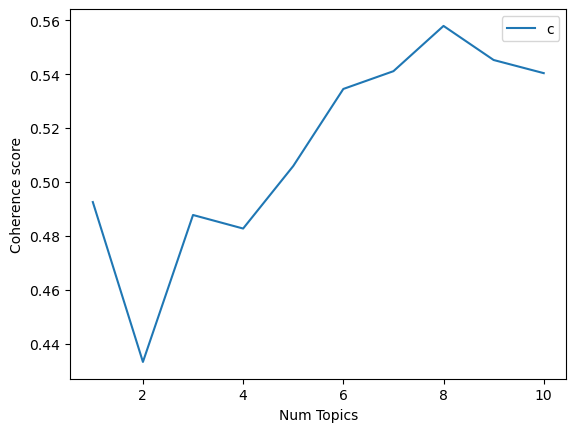

# of Topics: 1 Coherence Score: 0.4925325117860907
# of Topics: 2 Coherence Score: 0.4331634116908384
# of Topics: 3 Coherence Score: 0.48772883862202415
# of Topics: 4 Coherence Score: 0.4826992614225243
# of Topics: 5 Coherence Score: 0.5059038740854441
# of Topics: 6 Coherence Score: 0.5345391693257909
# of Topics: 7 Coherence Score: 0.5411368158202933
# of Topics: 8 Coherence Score: 0.5579464828323384
# of Topics: 9 Coherence Score: 0.5452899904502898
# of Topics: 10 Coherence Score: 0.5404073493816242



 Select the number of topics that best fit the dataset. Choose from the following: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
 8



-------------------- Top Words per Topic --------------------
Topic 1: ['chines', 'work', 'thing', 'everi', 'make', "you'r", 'guy', 'person', 'follow', 'anoth']
Topic 2: ['india', 'day', 'year', 'muslim', 'state', 'great', 'independ', 'kashmiri', 'live', 'happi']
Topic 3: ['mypakistan', 'countri', 'world', 'presid', 'turkey', 'updat', 'pm', 'imran_khan', 'beauti', 'read']
Topic 4: ['china', "don't", 'ladakh', 'pakistani', 'develop', 'usa', 'talk', 'start', 'big', 'america']
Topic 5: ['pleas', 'agre', 'dont', 'student', 'watch', 'exam', 'cancel', 'pla', 'readi', 'compart']
Topic 6: ['pakistan', 'indian', 'kashmir', 'minist', 'today', 'armi', 'prime', 'covid', 'tweet', 'unit']
Topic 7: ['peopl', 'give', 'good', 'made', 'back', 'allah', 'parti', 'case', 'support', 'million']
Topic 8: ['nation', 'time', 'govern', 'کھپ_ناڈالو', 'رسیدیں_نکالو', 'call', 'kill', 'love', 'news', 'balochistan']

***Review top words. The most relevant words are listed first. You may rerun this cell and try a dif

In [251]:
plot_coherence(coherence_values)
number_of_topics = select_topic_number(model_list, coherence_values)

In [252]:
df_final = export_results(number_of_topics, output_path_english)
df_final.groupby('Topic result').size().sort_values(ascending = False)

Topic result
tie        118055
topic_4       232
topic_6       213
topic_7       211
topic_5       211
topic_8       210
topic_3       204
topic_1       198
topic_2       194
dtype: int64

Chinese Suspended

In [253]:
model_list, coherence_values = run_model(df_suspended[df_suspended['langdetected'] == 'zh']) 

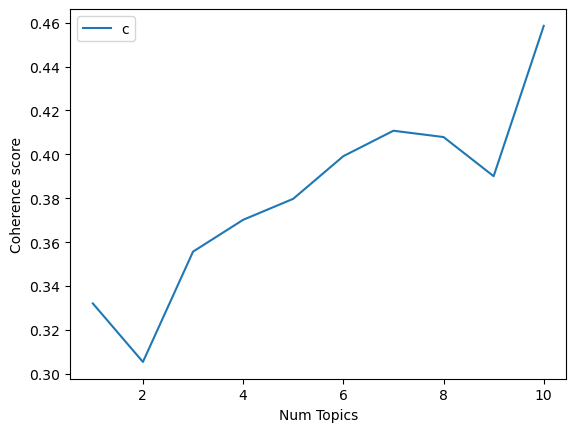

# of Topics: 1 Coherence Score: 0.33207737843445995
# of Topics: 2 Coherence Score: 0.30541034711762316
# of Topics: 3 Coherence Score: 0.35566804551773606
# of Topics: 4 Coherence Score: 0.37017565731458496
# of Topics: 5 Coherence Score: 0.37975074738117554
# of Topics: 6 Coherence Score: 0.3991830986849349
# of Topics: 7 Coherence Score: 0.4107796794929775
# of Topics: 8 Coherence Score: 0.40790100083008535
# of Topics: 9 Coherence Score: 0.3900604597471471
# of Topics: 10 Coherence Score: 0.4585456392060053



 Select the number of topics that best fit the dataset. Choose from the following: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
 8



-------------------- Top Words per Topic --------------------
Topic 1: ['美国', '人民', '搞', '特朗_普', '国', '总统', '政府', '疫情', '已经', '万']
Topic 2: ['香港', '國', '出', '新', '全', '嘅', '家', '政治', '名', '民']
Topic 3: ['中国', '美国', '世界', '问题', '美_爹', '支持', '人权', '天', '敢', '黑人']
Topic 4: ['没', '太', '死', '干', '应该', '相信', '英国', '东西', '走', '不要']
Topic 5: ['没有', '国家', '现在', '民主_自由', '感觉', '很多', '老', '关心', '共产党', '种族']
Topic 6: ['哈萨克', '这种', '钱', '逼', '一下', '维族', '历史', '生活', '觉得', '民族']
Topic 7: ['知道', '真', '想', '你妈', '吃', '话', '印度', '子', '懂', '哈哈哈']
Topic 8: ['狗', '美', '台湾', '里', '看看', '美_國', '。。', '可能', '希望', '快']

***Review top words. The most relevant words are listed first. You may rerun this cell and try a different number of topics.


In [254]:
plot_coherence(coherence_values)
number_of_topics = select_topic_number(model_list, coherence_values)

In [255]:
df_final = export_results(number_of_topics, output_path_chinese)
df_final.groupby('Topic result').size().sort_values(ascending = False)

Topic result
tie        117516
topic_7       342
topic_4       307
topic_3       298
topic_8       276
topic_1       263
topic_6       251
topic_5       243
topic_2       232
dtype: int64

Suspended last tweet 

In [160]:
last_tweets = df_suspended.loc[df_suspended.groupby('user.id').created_at.idxmax()]
last_tweets.head()

,created_at,id,text,lang,user.created_at,user.id,user.screen_name,suspended,cleantext,langdetected,no_stopwords,stemmed_docs,with_bigrams
69486,1.597650e+09,1.295262e+18,人生ってタイミングだね。タイミングがぴったりとあうと、色んなものがある。,ja,1.593570e+09,1.278150e+18,AnnaAdachi4,1.0,人生ってタイミングだね。タイミングがぴったりとあうと、色んなものがある。,ja,"[生, ってタイミングだね。タイミングがぴったりとあうと、, 色, んなものがある。]","[生, ってタイミングだね。タイミングがぴったりとあうと、, 色, んなものがある。]","[生, ってタイミングだね。タイミングがぴったりとあうと、, 色, んなものがある。]"
88206,1.599563e+09,1.303289e+18,@kuomintang 百年烂党没有救了，你要还有点雄心就喊两句反攻大陆呀，没这个胆子了，现...,zh,1.593587e+09,1.278222e+18,nFA8r89qmAoB5uT,1.0,百年烂党没有救了，你要还有点雄心就喊两句反攻大陆呀，没这个胆子了，现在连民进党都骑你们头上尿...,zh,"[百年, 烂, 党, 没有, 救, 有点, 雄心, 喊, 两, 句, 反攻, 大陆, 没, ...","[百年, 烂, 党, 没有, 救, 有点, 雄心, 喊, 两, 句, 反攻, 大陆, 没, ...","[百年_烂, 党, 没有, 救, 有点, 雄心, 喊, 两, 句, 反攻_大陆, 没, 胆子..."
15214,1.595579e+09,1.286576e+18,犯我中华者虽远必诛！！！！ https://t.co/h6MlZK4Fvk,zh,1.593593e+09,1.278247e+18,FangWu07049399,1.0,犯我中华者虽远必诛！！！！,zh,"[犯, 中华, 虽远, 必诛, ！！！！]","[犯, 中华, 虽远, 必诛, ！！！！]","[犯, 中华, 虽远_必诛, ！！！！]"
75268,1.599240e+09,1.301934e+18,RT @ROUSHAN73196917: It will be very interesti...,NaN,1.593613e+09,1.278333e+18,AshishS44350553,1.0,rt it will be very interesting to see whether ...,NaN,"[interesting, see, whether, successor, pm, abe...","[interesting, see, whether, successor, pm, abe...","[interesting, see, whether, successor, pm, abe..."
24314,1.595848e+09,1.287705e+18,香港疫情已几乎稳定，但反对派不顾市民生命安全，为了政治私利，将香港疫情推到风口浪尖上，连续三...,zh,1.593651e+09,1.278492e+18,wXzBIjr7Ep5RRre,1.0,香港疫情已几乎稳定，但反对派不顾市民生命安全，为了政治私利，将香港疫情推到风口浪尖上，连续三...,zh,"[香港, 疫情, 几乎, 稳定, 反对派, 不顾, 市民, 生命, 安全, 政治, 私利, ...","[香港, 疫情, 几乎, 稳定, 反对派, 不顾, 市民, 生命, 安全, 政治, 私利, ...","[香港, 疫情, 几乎, 稳定, 反对派, 不顾, 市民, 生命, 安全, 政治, 私利, ..."


In [257]:
model_list, coherence_values = run_model(last_tweets)

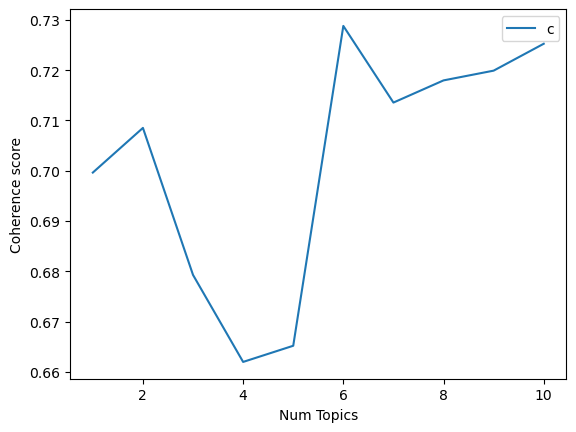

# of Topics: 1 Coherence Score: 0.699637616886796
# of Topics: 2 Coherence Score: 0.7085209866703199
# of Topics: 3 Coherence Score: 0.6792826654664625
# of Topics: 4 Coherence Score: 0.6619841405889582
# of Topics: 5 Coherence Score: 0.6651983396259125
# of Topics: 6 Coherence Score: 0.7288007284039009
# of Topics: 7 Coherence Score: 0.7135583020236028
# of Topics: 8 Coherence Score: 0.7179687367559511
# of Topics: 9 Coherence Score: 0.7199067625412494
# of Topics: 10 Coherence Score: 0.7252565618433623



 Select the number of topics that best fit the dataset. Choose from the following: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
 8



-------------------- Top Words per Topic --------------------
Topic 1: ['chines', '现在', 'captain', '基本', 'の', '哥哥', '出', 'معاشی', '起来', 'بھی']
Topic 2: ['香港', '疫情', 'china', 'に', '提供', '同志', '団体', 'case', '次元', '忠']
Topic 3: ['抗疫', '非洲', '出现', '中方', 'کے', '嗨', '鎖', '年前', '开展', 'する']
Topic 4: ['次', '老人', '国安_法', '火烧_活人', '翻墙', 'کو', '川_建国', '中非', 'today', '煞_笔']
Topic 5: ['nan', '美国', '没有', 'law', '事', '成都_总领馆', 'gen', 'someon', 'understand', 'journalist']
Topic 6: ['死', '中国', 'が', '新', '狗', '吃_屎', '问题', 'xijinp', '演讲', 'nan']
Topic 7: ['time', '王', '代表', 'justic', '希天', '必须', '国家', '🤭', '找', '改变']
Topic 8: ['نہ', '防空', '共产党', '呼吁', '乱', '辆', '中国', '求', '他口', '位置']

***Review top words. The most relevant words are listed first. You may rerun this cell and try a different number of topics.


In [258]:
plot_coherence(coherence_values)
number_of_topics = select_topic_number(model_list, coherence_values)

In [259]:
df_final = export_results(number_of_topics, output_path_suspended_last_tweet)
df_final.groupby('Topic result').size().sort_values(ascending = False)

Topic result
tie        119679
topic_4         9
topic_8         7
topic_5         7
topic_7         6
topic_3         6
topic_2         6
topic_6         5
topic_1         3
dtype: int64

English Last Tweet

In [260]:
model_list, coherence_values = run_model(last_tweets[last_tweets['langdetected'] == 'en'])

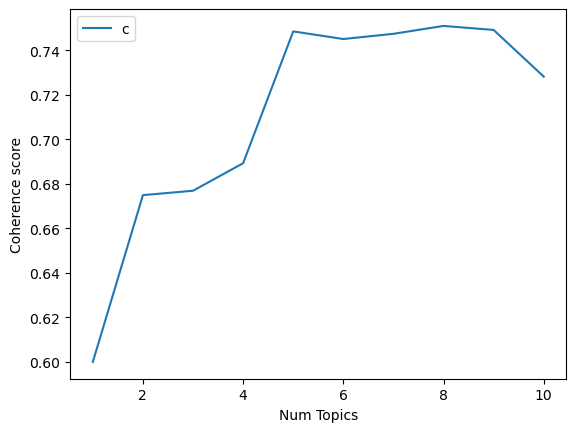

# of Topics: 1 Coherence Score: 0.5999560614751775
# of Topics: 2 Coherence Score: 0.6748746441168323
# of Topics: 3 Coherence Score: 0.6768450239001439
# of Topics: 4 Coherence Score: 0.6892138239370476
# of Topics: 5 Coherence Score: 0.7484081433433994
# of Topics: 6 Coherence Score: 0.7449915481579118
# of Topics: 7 Coherence Score: 0.7473306114000352
# of Topics: 8 Coherence Score: 0.7508746611018526
# of Topics: 9 Coherence Score: 0.7490718037741584
# of Topics: 10 Coherence Score: 0.7281095113557926



 Select the number of topics that best fit the dataset. Choose from the following: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
 8



-------------------- Top Words per Topic --------------------
Topic 1: ['chines', 'peopl', 'babi', 'negoti', 'long', 'person', 'follow', 'lucki', 'nightmar', 'ground']
Topic 2: ['time', 'law', 'captain', 'ive', 'apologet', 'religion', 'fuck', 'august', 'pla', 'sleep']
Topic 3: ['proud', 'countri', 'congratul', 'damag', 'provinc', 'sound', 'underestim', 'virus', 'everyon', 'histori']
Topic 4: ['justic', 'idk', 'bad', 'structur', 'caselaw', 'bling', 'sector', 'someon', 'giveaway', 'unit']
Topic 5: ['day', 'govern', 'realiti', 'peopl', 'elect', 'point', 'bec', 'state', 'forgot', 'china']
Topic 6: ['peac', 'nation', 'hagu', 'inherit', 'realiti', 'save', 'mypakistan', 'oper', 'state', 'ambassador']
Topic 7: ['presid', 'tea', 'find', 'univers', 'awsl', 'indian', 'commonlaw', 'point', 'woj', 'fair']
Topic 8: ['china', 'privat', 'anoth', 'import', 'even_though', 'big', 'dispens', 'analysi', 'hope', 'teameurop']

***Review top words. The most relevant words are listed first. You may rerun this

In [261]:
plot_coherence(coherence_values)
number_of_topics = select_topic_number(model_list, coherence_values)

In [262]:
df_final = export_results(number_of_topics, output_path_suspended_last_tweet_english)
df_final.groupby('Topic result').size().sort_values(ascending = False)

Topic result
tie        119712
topic_8         2
topic_7         2
topic_6         2
topic_5         2
topic_4         2
topic_3         2
topic_2         2
topic_1         2
dtype: int64

Chinese Last Tweet

In [264]:
model_list, coherence_values = run_model(last_tweets[last_tweets['langdetected'] == 'zh'])

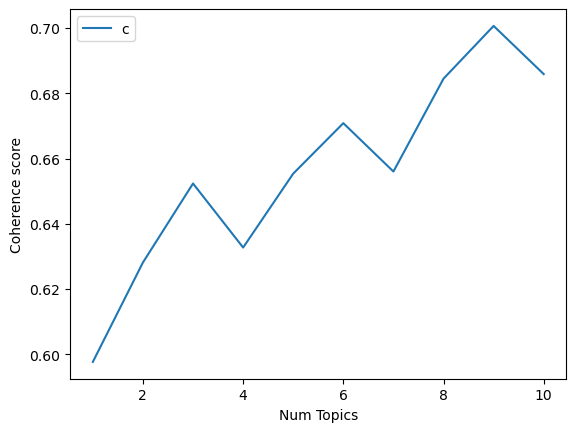

# of Topics: 1 Coherence Score: 0.5977023384723044
# of Topics: 2 Coherence Score: 0.6281504578983046
# of Topics: 3 Coherence Score: 0.6523426136725574
# of Topics: 4 Coherence Score: 0.6327318289976791
# of Topics: 5 Coherence Score: 0.6553722201502339
# of Topics: 6 Coherence Score: 0.6708218844954215
# of Topics: 7 Coherence Score: 0.656007928305444
# of Topics: 8 Coherence Score: 0.6844567478286148
# of Topics: 9 Coherence Score: 0.7006052822183413
# of Topics: 10 Coherence Score: 0.6858502581702377



 Select the number of topics that best fit the dataset. Choose from the following: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
 8



-------------------- Top Words per Topic --------------------
Topic 1: ['死', '出现', '品种', '已经', '设施', '做个', '暴露', '川_建国', '马夫', '系统']
Topic 2: ['防空', '尿', '世界_各国', '次', '改变', '辆', '次元', '滚', '累', '分散']
Topic 3: ['疫情', '非洲', '吃_屎', '爱国', '跑', '忠', '您算', '想', '口_嗨', '原则']
Topic 4: ['香港', '装甲', '国安_法', '鎖', '老人', '中秋', '连续', '错', '习', '垃圾']
Topic 5: ['狗', '没有', '怕', '直播', '出', '直接', '地下', '是定', '经历', '團']
Topic 6: ['中国', '现在', '提供', '翻墙', '共产党', '事件', '法_治', '毛', '乔夫', '至少']
Topic 7: ['美国', '市民', '国家', '必须', '呼吁', '根本', '智障', '年前', '欢庆', '快乐']
Topic 8: ['抗疫', '中方', '开展', '演讲', '问题', '指导', '推到', '总数', '发出', '培训']

***Review top words. The most relevant words are listed first. You may rerun this cell and try a different number of topics.


In [265]:
plot_coherence(coherence_values)
number_of_topics = select_topic_number(model_list, coherence_values)

In [266]:
df_final = export_results(number_of_topics, output_path_suspended_last_tweet_chinese)
df_final.groupby('Topic result').size().sort_values(ascending = False)

Topic result
tie        119701
topic_4         6
topic_7         5
topic_6         4
topic_5         4
topic_1         3
topic_3         2
topic_2         2
topic_8         1
dtype: int64

Not suspended

In [52]:
df_not_suspended = df[df['suspended'] == 0]
len(df_not_suspended)

110683

In [268]:
model_list, coherence_values = run_model(df_not_suspended)

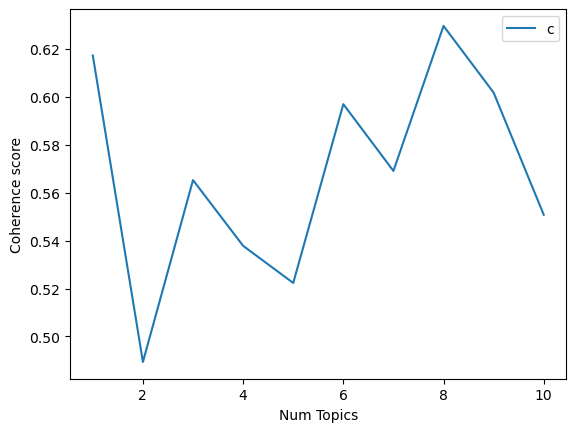

# of Topics: 1 Coherence Score: 0.6172697707751265
# of Topics: 2 Coherence Score: 0.48934528217566975
# of Topics: 3 Coherence Score: 0.5652701791311537
# of Topics: 4 Coherence Score: 0.537820452979428
# of Topics: 5 Coherence Score: 0.5223109673158367
# of Topics: 6 Coherence Score: 0.596978774880159
# of Topics: 7 Coherence Score: 0.5690978914540789
# of Topics: 8 Coherence Score: 0.629642185327002
# of Topics: 9 Coherence Score: 0.6017994562191136
# of Topics: 10 Coherence Score: 0.5507816867276504



 Select the number of topics that best fit the dataset. Choose from the following: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
 8



-------------------- Top Words per Topic --------------------
Topic 1: ['china', 'peopl', 'chines', 'countri', 'world', 'time', 'good', 'dont', 'love', 'make']
Topic 2: ['没有', '国家', '台湾', '人民', '政府', '世界', '印度', '现在', '美_爹', '中共']
Topic 3: ['pakistan', 'india', 'indian', 'day', 'nation', 'today', 'polic', 'video', 'call', 'armi']
Topic 4: ['nan', 'pleas', 'design', 'check', 'profession', 'cartoon', 'illustr', 'portrait', 'vector_portrait', 'children_book']
Topic 5: ['کی', 'کو', 'کا', 'سے', 'نے', 'پر', 'پاکستان', 'آج', 'عمران_خان', 'کر']
Topic 6: ['ہے', 'سے', 'تو', 'یہ', 'اس', 'کہ', 'کو', 'ایک', 'کر', 'کی']
Topic 7: ['香港', '日本', '出', '事', '️', 'の', '美', '🤣', '成', '先']
Topic 8: ['没', '想', '知道', '真', '死', '太', '吃', '这种', '干', '里']

***Review top words. The most relevant words are listed first. You may rerun this cell and try a different number of topics.


In [269]:
plot_coherence(coherence_values)
number_of_topics = select_topic_number(model_list, coherence_values)

In [270]:
df_final = export_results(number_of_topics, output_path_not_suspended)
df_final.groupby('Topic result').size().sort_values(ascending = False)

Topic result
tie        38268
topic_1    16821
topic_3    11512
topic_8    11500
topic_4    10449
topic_2     9677
topic_6     8789
topic_5     6688
topic_7     6024
dtype: int64

English non-suspended

In [271]:
model_list, coherence_values = run_model(df_not_suspended[df_not_suspended['langdetected'] == 'en'])

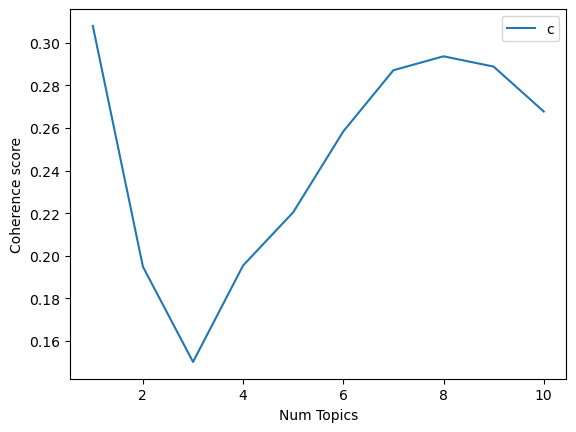

# of Topics: 1 Coherence Score: 0.30796496949347446
# of Topics: 2 Coherence Score: 0.19485534228809354
# of Topics: 3 Coherence Score: 0.15013341111782988
# of Topics: 4 Coherence Score: 0.19545369800112716
# of Topics: 5 Coherence Score: 0.2204420945963219
# of Topics: 6 Coherence Score: 0.25843095901749086
# of Topics: 7 Coherence Score: 0.28715865603150964
# of Topics: 8 Coherence Score: 0.2936942511645949
# of Topics: 9 Coherence Score: 0.28885189644935283
# of Topics: 10 Coherence Score: 0.26776479189608954



 Select the number of topics that best fit the dataset. Choose from the following: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
 8



-------------------- Top Words per Topic --------------------
Topic 1: ['pleas', 'design', 'check', 'profession', 'cartoon', 'illustr', 'portrait', 'vector_portrait', 'children_book', 'work']
Topic 2: ['peopl', 'chines', 'dont', 'govern', 'live', 'mani', 'talk', 'parti', 'stop', 'give']
Topic 3: ['american', 'make', 'trump', 'presid', 'thing', 'america', 'polit', 'lol', "don't", 'virus']
Topic 4: ['day', 'good', 'love', 'watch', 'great', 'alway', 'happi', 'human', 'minist', 'everi']
Topic 5: ['pakistan', 'india', 'indian', 'time', 'support', 'armi', 'news', 'power', 'forc', 'kashmir']
Topic 6: ['nation', 'today', 'polic', 'call', 'hong_kong', 'arrest', 'report', 'media', 'pm', 'freedom']
Topic 7: ['video', 'show', 'muslim', 'peac', 'kill', 'follow', 'beauti', 'start', 'order', 'place']
Topic 8: ['china', 'countri', 'world', 'state', 'covid', 'unit', 'year', 'case', 'million', 'develop']

***Review top words. The most relevant words are listed first. You may rerun this cell and try a d

In [272]:
plot_coherence(coherence_values)
number_of_topics = select_topic_number(model_list, coherence_values)

In [273]:
df_final = export_results(number_of_topics, output_path_not_suspended_english)
df_final.groupby('Topic result').size().sort_values(ascending = False)

Topic result
tie        95879
topic_4     3236
topic_2     3098
topic_8     3076
topic_6     3042
topic_3     2986
topic_5     2897
topic_1     2824
topic_7     2690
dtype: int64

Chinese non-suspended

In [274]:
model_list, coherence_values = run_model(df_not_suspended[df_not_suspended['langdetected'] == 'zh'])

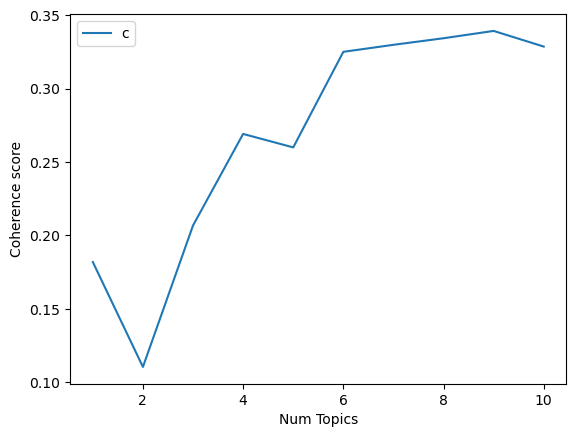

# of Topics: 1 Coherence Score: 0.18190789665225043
# of Topics: 2 Coherence Score: 0.1104579280299524
# of Topics: 3 Coherence Score: 0.20681013059617567
# of Topics: 4 Coherence Score: 0.2691816937074648
# of Topics: 5 Coherence Score: 0.26000017330593905
# of Topics: 6 Coherence Score: 0.32510731600106807
# of Topics: 7 Coherence Score: 0.3298897480752351
# of Topics: 8 Coherence Score: 0.3343644538965901
# of Topics: 9 Coherence Score: 0.3393513287543858
# of Topics: 10 Coherence Score: 0.3286926232545301



 Select the number of topics that best fit the dataset. Choose from the following: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
 8



-------------------- Top Words per Topic --------------------
Topic 1: ['国家', '人民', '世界', '两', '共产党', '历史', '新', '今天', '次', '国']
Topic 2: ['政府', '自由', '病毒', '疫情', '新_冠', '总统', '美', '万', '政治', '学生']
Topic 3: ['没', '想', '死', '太', '吃', '干', '需要', '话', '傻_逼', '老']
Topic 4: ['天', '这种', '支持', '希望', '可能', '发', '事', '很多', '国内', '东西']
Topic 5: ['爱', '觉得', '看到', '知道', '一下', '群', '找', '推', '带', '直接']
Topic 6: ['台湾', '没有', '现在', '美_爹', '中共', '问题', '日本', '敢', '大陆', '笑_死']
Topic 7: ['没有', '知道', '印度', '搞', '钱', '不要', '看看', '民主', '黑', '西方']
Topic 8: ['出', '美', '國', '成', '「', '名', '為', '生', '高', '家']

***Review top words. The most relevant words are listed first. You may rerun this cell and try a different number of topics.


In [275]:
plot_coherence(coherence_values)
number_of_topics = select_topic_number(model_list, coherence_values)

In [276]:
df_final = export_results(number_of_topics, output_path_not_suspended_chinese)
df_final.groupby('Topic result').size().sort_values(ascending = False)

Topic result
tie        100623
topic_3      2877
topic_6      2583
topic_5      2575
topic_2      2342
topic_7      2330
topic_4      2286
topic_1      2123
topic_8      1989
dtype: int64

### NER

In [42]:
!pip install fasttext
!wget -O /tmp/lid.176.bin https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin

/bin/bash: wget: command not found


In [41]:
import matplotlib.font_manager
matplotlib.font_manager._rebuild()
[f for f in matplotlib.font_manager.fontManager.ttflist if 'Heiti' in f.name]

Matplotlib is building the font cache; this may take a moment.


[<Font 'Heiti TC' (STHeitiTC-Medium-01.ttf) normal normal 400 normal>,
 <Font 'Heiti SC' (STHeitiSC-Medium-02.ttf) normal normal 400 normal>,
 <Font 'Heiti TC' (STHeiti Medium.ttc) normal normal 400 normal>,
 <Font 'Heiti TC' (STHeiti Light.ttc) normal normal 300 normal>]

In [14]:
# Must be downloaded - https://fasttext.cc/docs/en/language-identification.html
PRETRAINED_MODEL_PATH = 'lid.176.bin'
model = fasttext.load_model(PRETRAINED_MODEL_PATH)

In [15]:
#!python -m spacy download en_core_web_sm
#!python -m spacy download zh_core_web_sm

In [3]:
import es_core_news_sm
nlp_es = spacy.load("es_core_news_sm")

import da_core_news_sm
nlp_da = spacy.load('da_core_news_sm')

import nl_core_news_sm
nlp_nl = spacy.load('nl_core_news_sm')

import fr_core_news_sm
nlp_fr = spacy.load('fr_core_news_sm')

import de_core_news_sm
nlp_de = spacy.load('de_core_news_sm')

import pt_core_news_sm
nlp_pt = spacy.load('pt_core_news_sm')

import ja_core_news_sm
nlp_ja = spacy.load("ja_core_news_sm")

import it_core_news_sm
nlp_it = spacy.load('it_core_news_sm')

import el_core_news_sm
nlp_el = spacy.load('el_core_news_sm')

import ro_core_news_sm
nlp_ro = spacy.load('ro_core_news_sm')

import en_core_web_trf
nlp_en = spacy.load('en_core_web_trf')

import zh_core_web_sm
nlp_zh = spacy.load('zh_core_web_sm')

In [4]:
####### Spacy

# Load in appropriate parsers for each language - Chinese for now but come back and add control structure for other languages
def multi_lang_parser(df):
    ''' Convert langdetect results (uses ISO 639-1 codes) to full language names, 
    which is interpretable by the Snowball Stemmer '''

    mylist = list()
    # English
    df_en = df[df['langdetected'] == 'en']
    for doc, i in zip(nlp_en.pipe(df_en['cleantext']), range(0,len(df_en['cleantext']))):
        mylist.append((df_en['cleantext'].iloc[i], df_en['counts'].iloc[i], [(ent.text, ent.label_) for ent in doc.ents]))
    # Chinese    
    df_zh = df[df['langdetected'] == 'zh']
    df_zh['cleantext'] = df_zh['cleantext'].apply(lambda x: HanziConv.toSimplified(x))
    for doc, i in zip(nlp_zh.pipe(df_zh['cleantext'], disable=["tagger", "parser"]), range(0,len(df_zh['cleantext']))):
        mylist.append((df_zh['cleantext'].iloc[i], df_zh['counts'].iloc[i], [(ent.text, ent.label_) for ent in doc.ents]))
    # French
    df_fr = df[df['langdetected'] == 'fr']
    for doc, i in zip(nlp_fr.pipe(df_fr['cleantext'], disable=["tagger", "parser"]), range(0,len(df_fr['cleantext']))):
        mylist.append((df_fr['cleantext'].iloc[i], df_fr['counts'].iloc[i], [(ent.text, ent.label_) for ent in doc.ents]))
    # Portuguese   
    df_pt = df[df['langdetected'] == 'pt']
    for doc, i in zip(nlp_pt.pipe(df_pt['cleantext'], disable=["tagger", "parser"]), range(0,len(df_pt['cleantext']))):
        mylist.append((df_pt['cleantext'].iloc[i], df_pt['counts'].iloc[i], [(ent.text, ent.label_) for ent in doc.ents]))
    # Spanish  
    df_es = df[df['langdetected'] == 'es']
    for doc, i in zip(nlp_es.pipe(df_es['cleantext'], disable=["tagger", "parser"]), range(0,len(df_es['cleantext']))):
        mylist.append((df_es['cleantext'].iloc[i], df_es['counts'].iloc[i], [(ent.text, ent.label_) for ent in doc.ents]))
    # Japanese
    df_ja = df[df['langdetected'] == 'ja']
    for doc, i in zip(nlp_ja.pipe(df_ja['cleantext'], disable=["tagger", "parser"]), range(0,len(df_ja['cleantext']))):
        mylist.append((df_ja['cleantext'].iloc[i], df_ja['counts'].iloc[i], [(ent.text, ent.label_) for ent in doc.ents]))
    # Italian  
    df_it = df[df['langdetected'] == 'it']
    for doc, i in zip(nlp_it.pipe(df_it['cleantext'], disable=["tagger", "parser"]), range(0,len(df_it['cleantext']))):
        mylist.append((df_it['cleantext'].iloc[i], df_it['counts'].iloc[i], [(ent.text, ent.label_) for ent in doc.ents]))
    # Greek
    df_el = df[df['langdetected'] == 'el']
    for doc, i in zip(nlp_el.pipe(df_el['cleantext'], disable=["tagger", "parser"]), range(0,len(df_el['cleantext']))):
        mylist.append((df_el['cleantext'].iloc[i], df_el['counts'].iloc[i], [(ent.text, ent.label_) for ent in doc.ents]))
    # Romanian
    df_ro = df[df['langdetected'] == 'ro']
    for doc, i in zip(nlp_ro.pipe(df_ro['cleantext'], disable=["tagger", "parser"]), range(0,len(df_ro['cleantext']))):
        mylist.append((df_ro['cleantext'].iloc[i], df_ro['counts'].iloc[i], [(ent.text, ent.label_) for ent in doc.ents]))
    # German
    df_de = df[df['langdetected'] == 'de']
    for doc, i in zip(nlp_de.pipe(df_de['cleantext'], disable=["tagger", "parser"]), range(0,len(df_de['cleantext']))):
        mylist.append((df_de['cleantext'].iloc[i], df_de['counts'].iloc[i], [(ent.text, ent.label_) for ent in doc.ents]))
    # Danish
    df_da = df[df['langdetected'] == 'da']
    for doc, i in zip(nlp_da.pipe(df_da['cleantext'], disable=["tagger", "parser"]), range(0,len(df_da['cleantext']))):
        mylist.append((df_da['cleantext'].iloc[i], df_da['counts'].iloc[i], [(ent.text, ent.label_) for ent in doc.ents]))
    # Dutch
    df_nl = df[df['langdetected'] == 'nl']
    for doc, i in zip(nlp_nl.pipe(df_da['cleantext'], disable=["tagger", "parser"]), range(0,len(df_nl['cleantext']))):
        mylist.append((df_nl['cleantext'].iloc[i], df_nl['counts'].iloc[i], [(ent.text, ent.label_) for ent in doc.ents]))
    
    return mylist

In [5]:
# Pretty long to do entity extraction even without language identification 
def ner_loop_multi_lang(df):
    # Parse by language 
    mylist = multi_lang_parser(df)
        
    no_ents = 0
    ners = list()
    
    for i in range(0,len(mylist)):
        doc = mylist[i][2]
        try:
            #mylist = [(X.text, X.label_) for X in doc.ents]
            df_2 = pd.DataFrame(doc, columns=['word','entity'])
            b = df_2.groupby(['entity'])['word'].apply(lambda x: ','.join(x)).reset_index()
            b = b.set_index('entity').T
            a = pd.DataFrame([[mylist[i][0], mylist[i][1]]], columns=['text', 'count'])
            full = pd.concat([a.reset_index(drop=True), b.reset_index(drop=True)], axis=1)
            ners.append(full)
        except:
            no_ents = no_ents + 1
            
    q = pd.concat(ners)
    return q

Suspended

In [55]:
df_flat_suspended = df_suspended.groupby(['cleantext', 'langdetected']).size()\
                    .reset_index(name='counts')\
                    .sort_values('counts', ascending=False)\
                    .reset_index(drop=True)


In [58]:
df_flat_suspended['cleantext'] = df_flat_suspended['cleantext'].apply(lambda x: emoji.demojize(x, delimiters=("", " ")) if pd.notnull(x) else x)
df_flat_suspended.head()

,cleantext,langdetected,counts
0,waxpar 口充電器 互換充電器 dcrd マキタ v v バッテリ 対応 bl bl b...,ja,20
1,rt,und,20
2,waxpar dcrc 互換充電器 対応 マキタ v v リチウムイオンバッテリ用 マキタ ...,ja,18
3,waxpar 最新互換マキタ 口充電器dcrd v v バッテリー bl bl bl bl ...,ja,18
4,itni economy to kisi aur ki nahi giri dismal p...,in,15


In [59]:
df_train.columns

Index(['id', 'created_at', 'text', 'retweet_count', 'favorite_count',
       'quoted_status_id', 'user.id', 'user.created_at', 'user.description',
       'user.favourites_count',
       ...
       'user.geo_enabled_False', 'user.geo_enabled_True',
       'user.verified_False', 'user.has_extended_profile_False',
       'user.has_extended_profile_True', 'user.protected_False',
       'user.verified_False.1', 'user.default_profile_True',
       'is_quote_status_False', 'is_quote_status_True'],
      dtype='object', length=167)

In [60]:
start_time = time.time()

df3 = ner_loop_multi_lang(df_flat_suspended)

print("--- %s seconds ---" % (time.time() - start_time))

# 460 rows in 2.9 seconds | Down to 108 rows and 2.5 seconds when collapsing to counts | 121 and 1.22 seconds when using fasttext (Winner)
# 40,823 rows in 538 seconds (8.9 min) - Full dataset was 43,154, so 5% without entities | 
    # Down to 10960 rows and 214 seconds when collapsing to counts (3.5 min)
    # Down to 11530 rows and 98 seconds when collapsing to counts and using fasttext (1.63 min) [Seems to range btwn 98 and 158 seconds]

--- 144.7969090938568 seconds ---


In [107]:
print(df3.columns)

Index(['text', 'count', 'PERSON', 'DATE', 'ORDINAL', 'TIME', 'GPE', 'NORP',
       'CARDINAL', 'ORG', 'LOC', 'FAC', 'LAW', 'MONEY', 'QUANTITY',
       'WORK_OF_ART', 'LANGUAGE', 'EVENT', 'PRODUCT', 'PERCENT', 'MISC',
       'TITLE_AFFIX', 'ALL', 'All'],
      dtype='object')


Functions to Look at Correlation over Time and Output Heatmap - Using Spacy - come back and compare with polyglot

With Countries, Nationalities, or Languages

In [129]:
inc_cols = ['GPE', 'NORP', 'ORG', 'PERSON', 'ORDINAL', 'LOC', 'FAC', 'PRODUCT', 'EVENT', 'LANGUAGE', 'MISC', 'WORK_OF_ART', 'LAW']

In [183]:
def countmath(x,y):
    b = ",".join([x]*y)
    return b

def top_entities_corr(entities_frame,output_path, inc_cols):
    #First we will select the column of entities from the dataframe, and take only the rows where there actually entities
    entities_frame['ALL'] = entities_frame[inc_cols].apply(lambda x: ','.join(x.dropna()), axis=1)
    #entities_frame['ALL'] = entities_frame[['GPE', 'NORP', 'LOC', 'PERSON', 'ORG', 'FAC', 'EVENT']].apply(lambda x: ','.join(x.dropna()), axis=1)
    entities_frame['All'] = entities_frame[['ALL','count']].apply(lambda x: countmath(*x), axis=1)
    
    # AFTER RUNNING, RUN AGAIN WITH THE MANUAL TRANSLATIONS 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("美国", "usa", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("中国", "china", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("香港", "hong kong", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("台湾", "taiwan", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("china人", "chinese", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("usa人", "american", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("哈萨克", "kazakh", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("第一", "first", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("中文", "chinese", case = False) 
    
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("中共", "chinese communist party", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("维族", "uyghur", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("印度", "india", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("英国", "england", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("德国", "germany", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("日本", "japan", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("反共", "anti-communist", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("共产党", "chinese communist party", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("特朗普", "trump", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("成都", "chengdu", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("川普", "trump", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("蒙古", "mongolia", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("郭文贵", "guo wengui", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("澳洲", "australia", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("共党", "chinese communist party", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("汉族", "han", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("大陆", "mainland", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("华人", "chinese", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("反华", "anti-chinese", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("新疆", "xinjiang", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("中华", "chinese", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("哈萨克斯坦", "kazakhstan", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("英语", "english", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("国民党", "kuomintang", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("japan人", "japanese", case = False) 
  
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("彭猪", "pengzhu", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("立法会", "legislative council of hong kong", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("哈哈哈", "hahaha", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("中国chinese communist party", "chinese communist party", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("白宫", "white house", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("联合国", "un", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("纽约时报", "new york times", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("china外交部", "chinese mfa", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("mongolia人", "mongol", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("解放军", "chinese pla", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("欧洲", "europe", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("美军", "us military", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("潘多拉", "pandora", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("蔡英文", "tsai ying-wen", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("南海", "south china sea", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("欧盟", "eu", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("非洲", "africa", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("文革", "cultural revolution", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("穆斯林", "muslim", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("美国之音", "voice of america", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("习近平", "xi jinping", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("二战", "world war 2", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("川建国", "trump", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("地球", "globe", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("北京", "beijing", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("民进党", "democratic progressive party", case = False) 
    
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("议会", "uk parliament", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("联谊 总会", "friendship association", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("林郑月娥", "carrie lam", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("月日", "date", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("戈尔巴乔夫", "gorbachev", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("拜＃反对派纵纵煽风暴", "the opposition", case = False)
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("孝子贤孙", "filial", case = False)
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("中非患难与共", "china-africa", case = False)
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("你可", "you", case = False)
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("中央", "central", case = False)
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("hahaha我", "hahaha", case = False)
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("黄严忠", "yan zhonghuang", case = False)
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("中方", "eastern", case = False)
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("中途", "midway", case = False)
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("江西", "jiangxi", case = False)
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("华", "chinese", case = False)
  
    # Take the rows from the hashtag columns where there are actually hashtags
    entities_list_df = entities_frame.loc[
        entities_frame.ALL.apply(
            lambda all_list: all_list !=[]
        ),['ALL']]
    
    # Flatten out dataframe to get counts per words - this is the most computationally intense part
    # The module standardizes a core set of fast, memory efficient tools that are useful by themselves or in combination. 
        # Together, they form an “iterator algebra” making it possible to construct specialized tools succinctly and efficiently in pure Python
    flattened_entities_df = pd.DataFrame(
        list(itertools.chain.from_iterable([entity.split(",") for entity in entities_list_df.ALL])),
        columns=['entity'])
    
    # Like before lets look at the top entities by their frequency of appearance. You can do this using count of appearances of each entity
    popular_entities = flattened_entities_df.groupby('entity').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
    
    # The date chartacter keeps getting wrapped up in the NER, so manually drop here 
    popular_entities = popular_entities[popular_entities.entity != "日"]
    popular_entities = popular_entities[popular_entities.entity != "周一起"]
    popular_entities = popular_entities[popular_entities.entity != "美"]
    popular_entities = popular_entities[popular_entities.entity != "中"]
    popular_entities = popular_entities[popular_entities.entity != "俄"]

    popular_entities = popular_entities[popular_entities.entity != "奥周四"]
    popular_entities = popular_entities[popular_entities.entity != "求互fo"]
    popular_entities = popular_entities[popular_entities.entity != ""]
    popular_entities = popular_entities[popular_entities.entity != " "]
    
    popular_entities.to_csv(output_path+'spac_GPE_popular_entities.csv', index=False, encoding = "utf_8_sig")
    
    popular_entities_sub = popular_entities.head(15) # Would want to manually take out obvious ones perhaps, but we can build the counts from here 

    # Top 10 Entities by Volume
    matplotlib.rcParams['font.family'] = ['Heiti TC']
    matplotlib.rc('xtick', labelsize=20)
    matplotlib.rc('ytick', labelsize=20)
    plt.figure(figsize=(100, 10))
    
    plt.subplot(131)
    plt.bar(popular_entities_sub ['entity'], popular_entities_sub ['counts'])
    plt.xlabel('Entity', fontsize=20)
    plt.ylabel('Volume', fontsize=20)
    plt.xticks(rotation=45, ha='right')
    plt.savefig(output_path+'spac_GPE_top_entities.png', bbox_inches='tight')
    
    # take entities which appear at least this amount of times
    min_appearance = 1
    popular_entities = popular_entities[:20]
    # find popular entities - make into python set for efficiency
    popular_entities_set = set(popular_entities[
                           popular_entities.counts>=min_appearance
                           ]['entity'])
    
    # Next we are going to create a new column in hashtags_df which filters the hashtags to only the popular hashtags. We will also drop the rows where no popular hashtags appear.
    # Make a new column with only the popular hashtags
    entities_list_df['popular_entities'] = entities_list_df.ALL.apply(
            lambda entities_list: [entity for entity in entities_list.split(",")
                                  if entity in popular_entities_set])
    
    # drop rows without popular entities
    popular_entities_list_df = entities_list_df.loc[
            entities_list_df.popular_entities.apply(lambda entities_list: entities_list !=[])]
    
    #Next we want to vectorise our the entities in each tweet like mentioned above. We do this using the following block of code to create a dataframe where the hashtags contained in each row are in vector form.
    # make new dataframe
    entities_vector_df = popular_entities_list_df.loc[:, ['popular_entities']]
    
    for entity in popular_entities_set:
        # make columns to encode presence of hashtags
        entities_vector_df['{}'.format(entity)] = entities_vector_df.popular_entities.apply(
            lambda entities_list: int(entity in entities_list))
        
    # Now satisfied we will drop the popular_hashtags column from the dataframe. We don’t need it.
    entities_matrix = entities_vector_df.drop('popular_entities', axis=1)
        
    # calculate the correlation matrix
    correlations = entities_matrix.corr()
    
    # plot the correlation matrix
    matplotlib.rc('xtick', labelsize=16)
    matplotlib.rc('ytick', labelsize=16)
    plt.figure(figsize=(20,20))
    sns.heatmap(correlations,
                cmap='RdBu',
                vmin=-1,
                vmax=1,
                square = True,
                cbar_kws={'label':'correlation'})
    plt.savefig(output_path+'spac_GPE_heat_map.png', bbox_inches='tight')
    
    

--- 2.3537399768829346 seconds ---


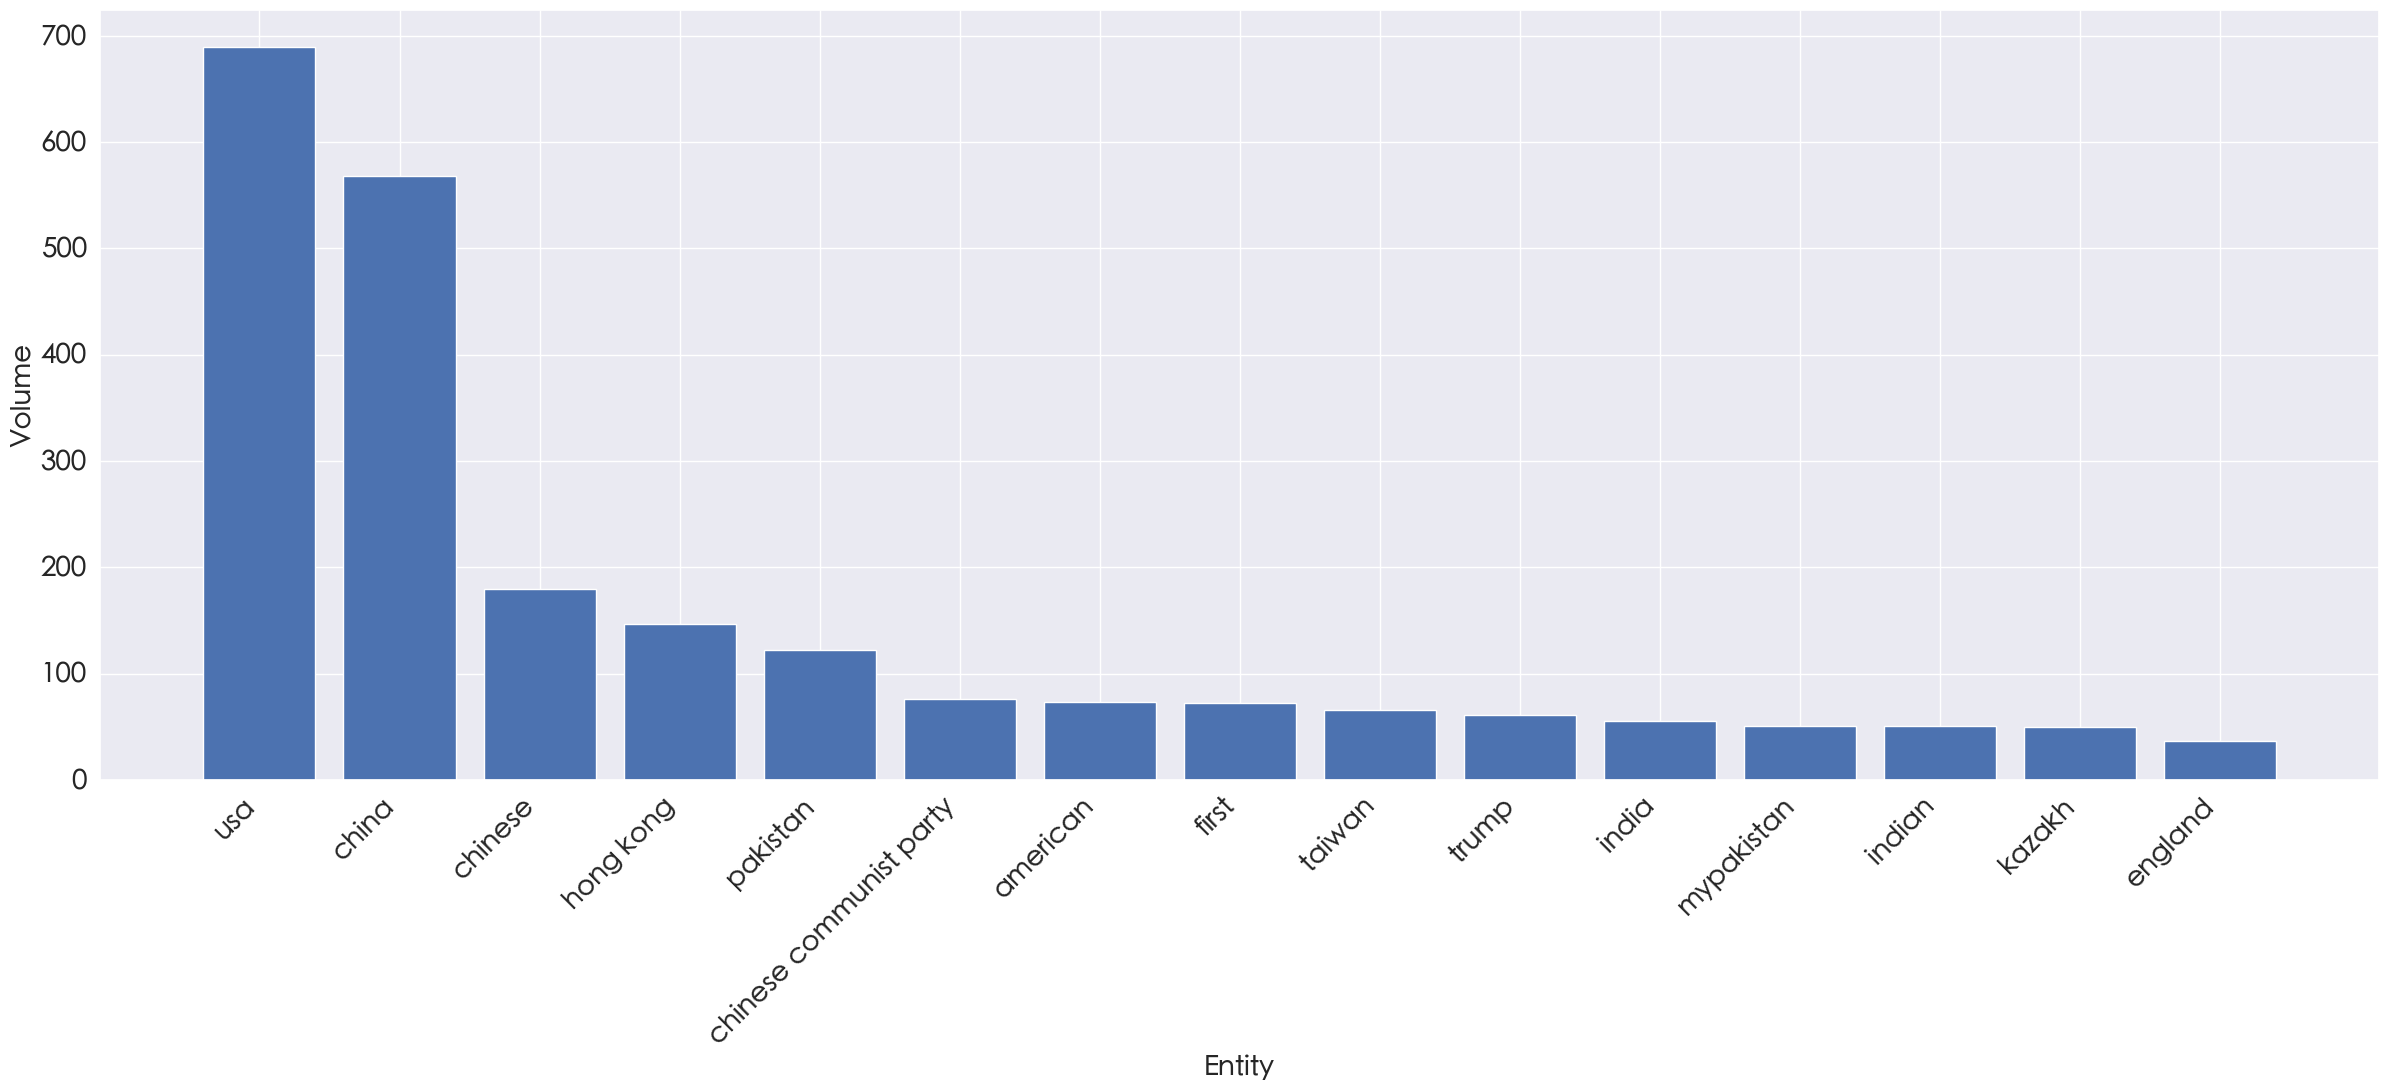

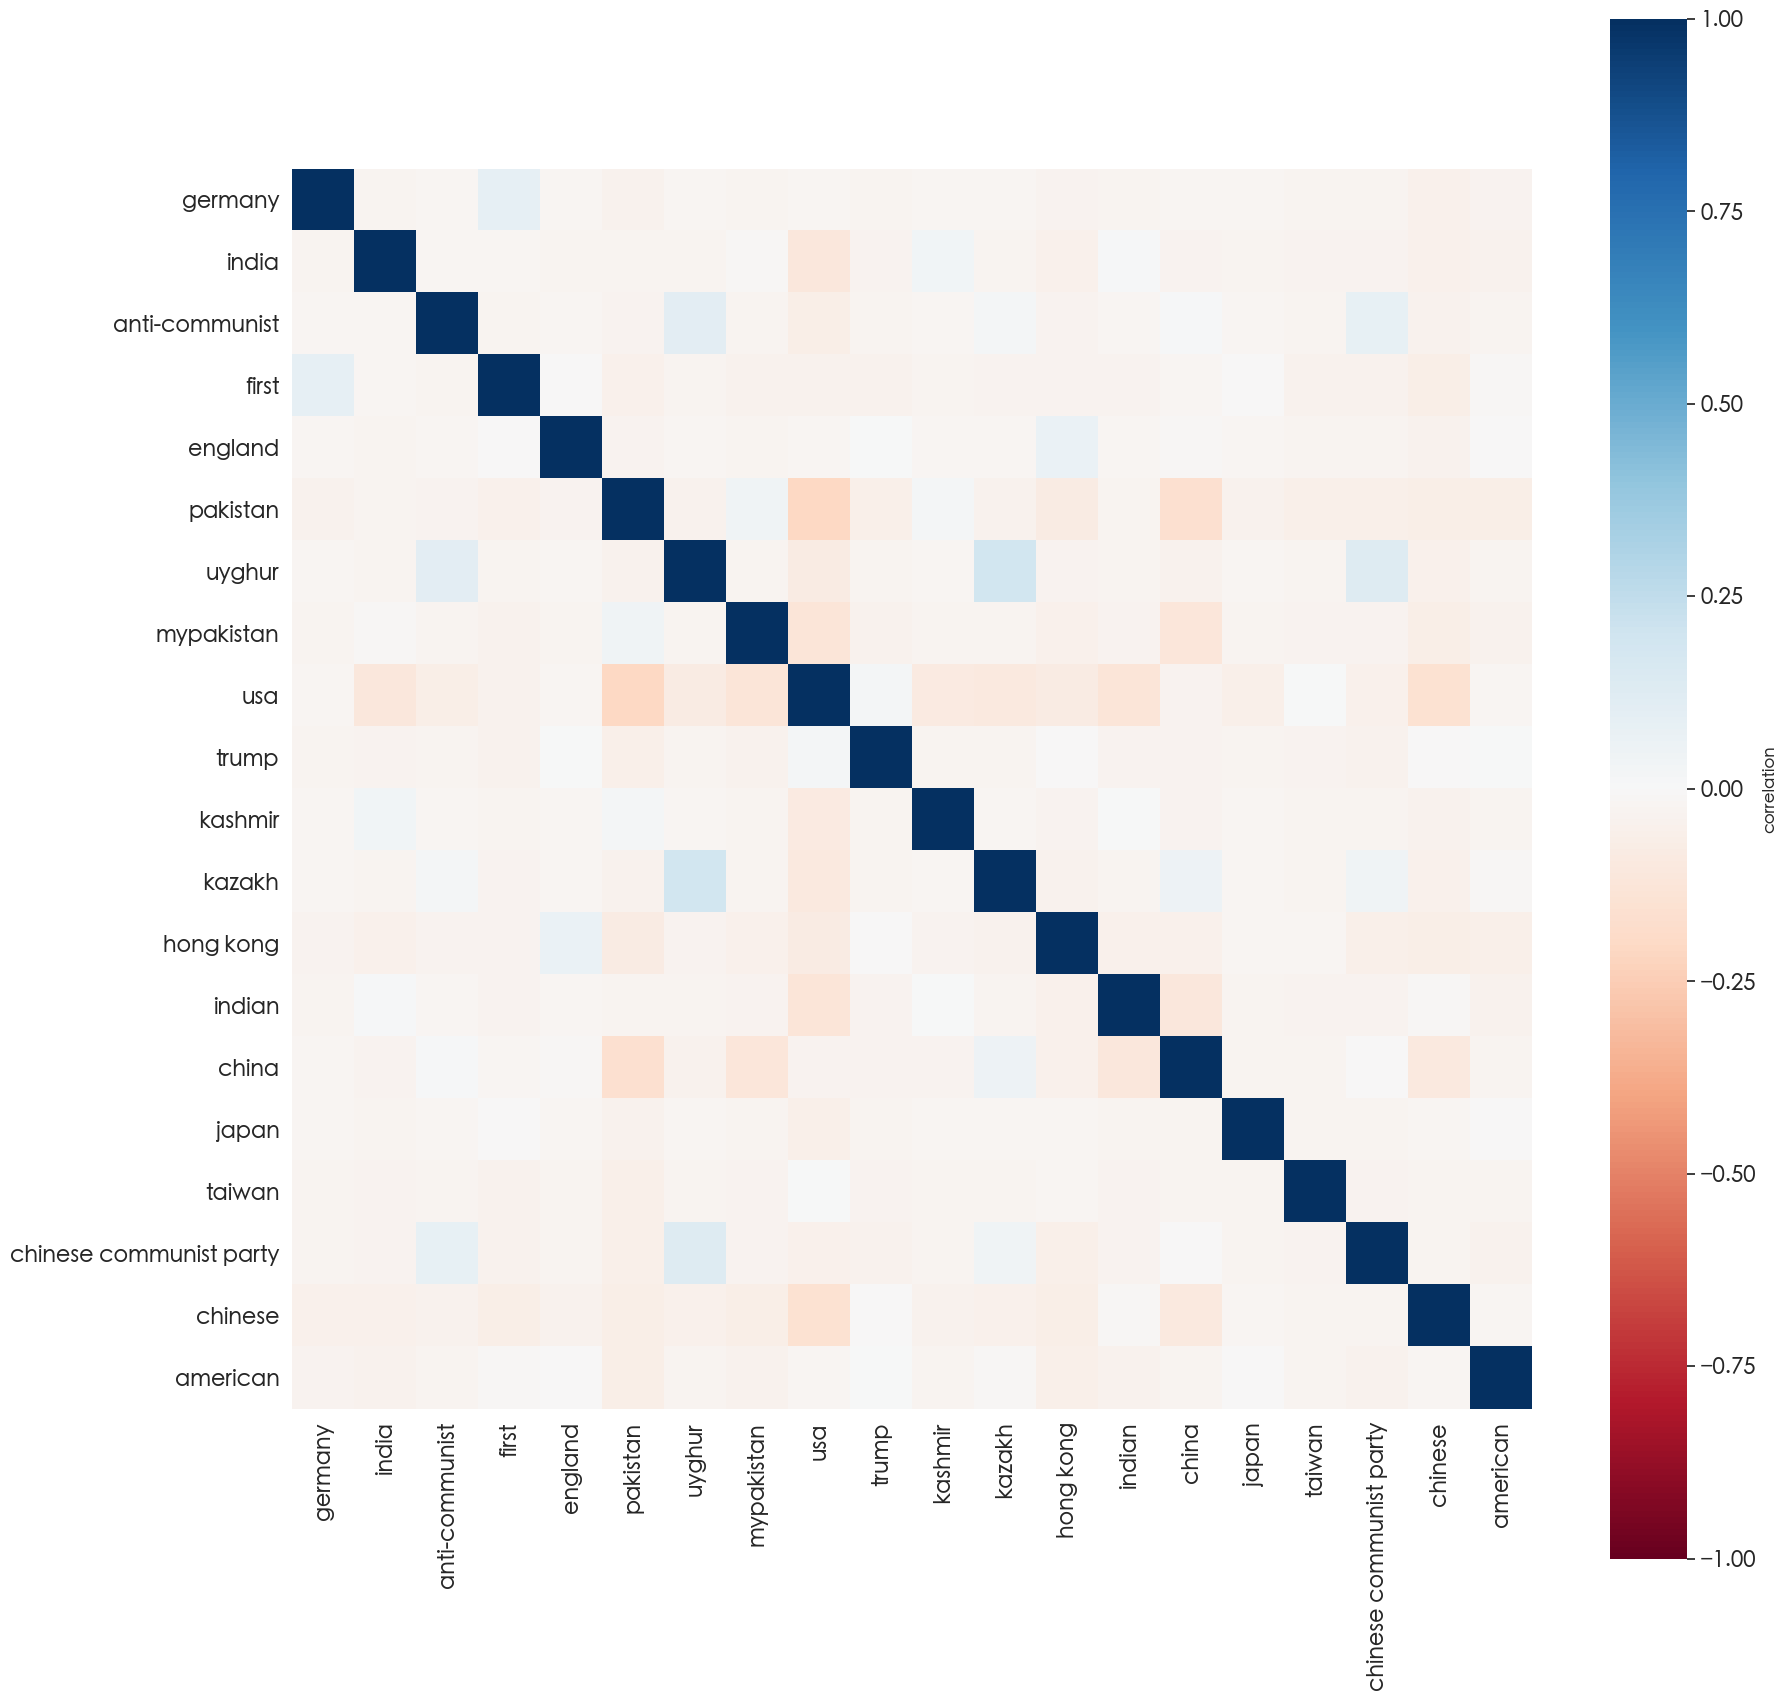

In [131]:
start_time = time.time()

top_entities_corr(df3, output_path_suspended, inc_cols)

print("--- %s seconds ---" % (time.time() - start_time))

# Ran in 1.36 seconds on 460 rows original dataset
# Ran i 4.2 seconds on the larger 43,154 row dataset

Without countries, nationalities, languages

In [132]:
inc_cols.remove('GPE')
inc_cols.remove('NORP')
inc_cols.remove('ORDINAL')
inc_cols.remove('LANGUAGE')

In [182]:
def top_entities_corr_noGPE(entities_frame, output_path, inc_cols):
    # Get ride of entities 
    #entities_frame['ALL'] = entities_frame[['LOC', 'PERSON', 'ORG', 'FAC', 'LANGUAGE', 'WORK_OF_ART', 'LAW' ,'MISC', 'EVENT', "PRODUCT", "MOVEMENT"]].apply(lambda x: ','.join(x.dropna()), axis=1)
    entities_frame['ALL'] = entities_frame[inc_cols].apply(lambda x: ','.join(x.dropna()), axis=1)
    entities_frame['All'] = entities_frame[['ALL','count']].apply(lambda x: countmath(*x), axis=1)
    
    #First we will select the column of entities from the dataframe, and take only the rows where there actually entities
        
       # AFTER RUNNING, RUN AGAIN WITH THE MANUAL TRANSLATIONS 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("美国", "usa", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("中国", "china", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("香港", "hong kong", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("台湾", "taiwan", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("china人", "chinese", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("usa人", "american", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("哈萨克", "kazakh", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("第一", "first", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("中文", "chinese", case = False) 
    
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("中共", "chinese communist party", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("维族", "uyghur", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("印度", "india", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("英国", "england", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("德国", "germany", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("日本", "japan", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("反共", "anti-communist", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("共产党", "chinese communist party", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("特朗普", "trump", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("成都", "chengdu", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("川普", "trump", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("蒙古", "mongolia", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("郭文贵", "guo wengui", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("澳洲", "australia", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("共党", "chinese communist party", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("汉族", "han", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("大陆", "mainland", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("华人", "chinese", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("反华", "anti-chinese", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("新疆", "xinjiang", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("中华", "chinese", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("哈萨克斯坦", "kazakhstan", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("英语", "english", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("国民党", "kuomintang", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("japan人", "japanese", case = False)
  
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("彭猪", "pengzhu", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("立法会", "legislative council of hong kong", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("哈哈哈", "hahaha", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("中国chinese communist party", "chinese communist party", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("白宫", "white house", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("联合国", "un", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("纽约时报", "new york times", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("china外交部", "chinese mfa", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("mongolia人", "mongol", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("解放军", "chinese pla", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("欧洲", "europe", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("美军", "us military", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("潘多拉", "pandora", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("蔡英文", "tsai ying-wen", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("南海", "south china sea", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("欧盟", "eu", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("非洲", "africa", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("文革", "cultural revolution", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("穆斯林", "muslim", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("美国之音", "voice of america", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("习近平", "xi jinping", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("二战", "world war 2", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("川建国", "trump", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("地球", "globe", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("北京", "beijing", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("民进党", "democratic progressive party", case = False) 
    
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("议会", "uk parliament", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("联谊 总会", "friendship association", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("林郑月娥", "carrie lam", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("月日", "date", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("戈尔巴乔夫", "gorbachev", case = False) 
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("拜＃反对派纵纵煽风暴", "the opposition", case = False)
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("孝子贤孙", "filial", case = False)
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("中非患难与共", "china-africa", case = False)
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("你可", "you", case = False)
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("中央", "central", case = False)
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("hahaha我", "hahaha", case = False)
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("黄严忠", "yan zhonghuang", case = False)
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("中方", "eastern", case = False)
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("中途", "midway", case = False)
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("江西", "jiangxi", case = False)
    entities_frame["ALL"]= entities_frame["ALL"].str.replace("华", "chinese", case = False)
    
    
    # Take the rows from the hashtag columns where there are actually hashtags
    entities_list_df = entities_frame.loc[
        entities_frame.ALL.apply(
            lambda all_list: all_list !=[]
        ),['ALL']]
    
    flattened_entities_df = pd.DataFrame(
        list(itertools.chain.from_iterable([entity.split(",") for entity in entities_list_df.ALL])),
        columns=['entity'])
    
    # Like before lets look at the top entities by their frequency of appearance. You can do this using count of appearances of each entity
    popular_entities = flattened_entities_df.groupby('entity').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
    
    # The date chartacter keeps getting wrapped up in the NER, so manually drop here 
    popular_entities = popular_entities[popular_entities.entity != "日"]
    popular_entities = popular_entities[popular_entities.entity != "周一起"]
    popular_entities = popular_entities[popular_entities.entity != "美"]
    popular_entities = popular_entities[popular_entities.entity != "中"]
    popular_entities = popular_entities[popular_entities.entity != "俄"]
   
    popular_entities = popular_entities[popular_entities.entity != "奥周四"]
    popular_entities = popular_entities[popular_entities.entity != "求互fo"]
    popular_entities = popular_entities[popular_entities.entity != ""]
    popular_entities = popular_entities[popular_entities.entity != " "]
    
    popular_entities.to_csv(output_path+'spac_NoGPE_popular_entities.csv', index=False, encoding = "utf_8_sig")
    
    popular_entities_sub = popular_entities.head(15) # Would want to manually take out obvious ones perhaps, but we can build the counts from here 

    # Top 10 Entities by Volume
    matplotlib.rcParams['font.family'] = ['Heiti TC']
    matplotlib.rc('xtick', labelsize=20)
    matplotlib.rc('ytick', labelsize=20)
    plt.figure(figsize=(100, 10))
    
    plt.subplot(131)
    plt.bar(popular_entities_sub ['entity'], popular_entities_sub ['counts'])
    plt.xlabel('Entity', fontsize=16)
    plt.ylabel('Volume', fontsize=16)
    plt.xticks(rotation=45, ha="right") 
    plt.title('Top Entities Included in Posts', fontsize=20, fontweight='bold', y=1.05)
    plt.savefig(output_path+'spac_NoGPE_top_entities.png', bbox_inches='tight')
    
    # take entities which appear at least this amount of times
    min_appearance = 1
    popular_entities = popular_entities[:20]
    # find popular entities - make into python set for efficiency
    popular_entities_set = set(popular_entities[
                           popular_entities.counts>=min_appearance
                           ]['entity'])
    
    # Next we are going to create a new column in hashtags_df which filters the hashtags to only the popular hashtags. We will also drop the rows where no popular hashtags appear.
    # Make a new column with only the popular hashtags
    entities_list_df['popular_entities'] = entities_list_df.ALL.apply(
            lambda entities_list: [entity for entity in entities_list.split(",")
                                  if entity in popular_entities_set])
    
    # drop rows without popular entities
    popular_entities_list_df = entities_list_df.loc[
            entities_list_df.popular_entities.apply(lambda entities_list: entities_list !=[])]
    
    #Next we want to vectorise our the entities in each tweet like mentioned above. We do this using the following block of code to create a dataframe where the hashtags contained in each row are in vector form.
    # make new dataframe
    entities_vector_df = popular_entities_list_df.loc[:, ['popular_entities']]
    
    for entity in popular_entities_set:
        # make columns to encode presence of hashtags
        entities_vector_df['{}'.format(entity)] = entities_vector_df.popular_entities.apply(
            lambda entities_list: int(entity in entities_list))
        
    # Now satisfied we will drop the popular_hashtags column from the dataframe. We don’t need it.
    entities_matrix = entities_vector_df.drop('popular_entities', axis=1)
        
    # calculate the correlation matrix
    correlations = entities_matrix.corr()
    
    # plot the correlation matrix
    matplotlib.rcParams['font.family'] = ['Heiti TC']
    matplotlib.rc('xtick', labelsize=16)
    matplotlib.rc('ytick', labelsize=16)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    ax.set_title('Entity Correlation Heat Map', pad=20, fontsize =16, fontweight = 'bold')
    fig.subplots_adjust(top=0.85)
    #fig.title('Media - Entity Correlation Heat Map', fontsize=16, fontweight='bold', y=1)
    sns.heatmap(correlations,
                cmap='RdBu',
                vmin=-1,
                vmax=1,
                square = True,
                cbar_kws={'label':'correlation'})
    fig.savefig(output_path+'spac_NoGPE_heat_map.png', bbox_inches='tight')

--- 2.201547861099243 seconds ---


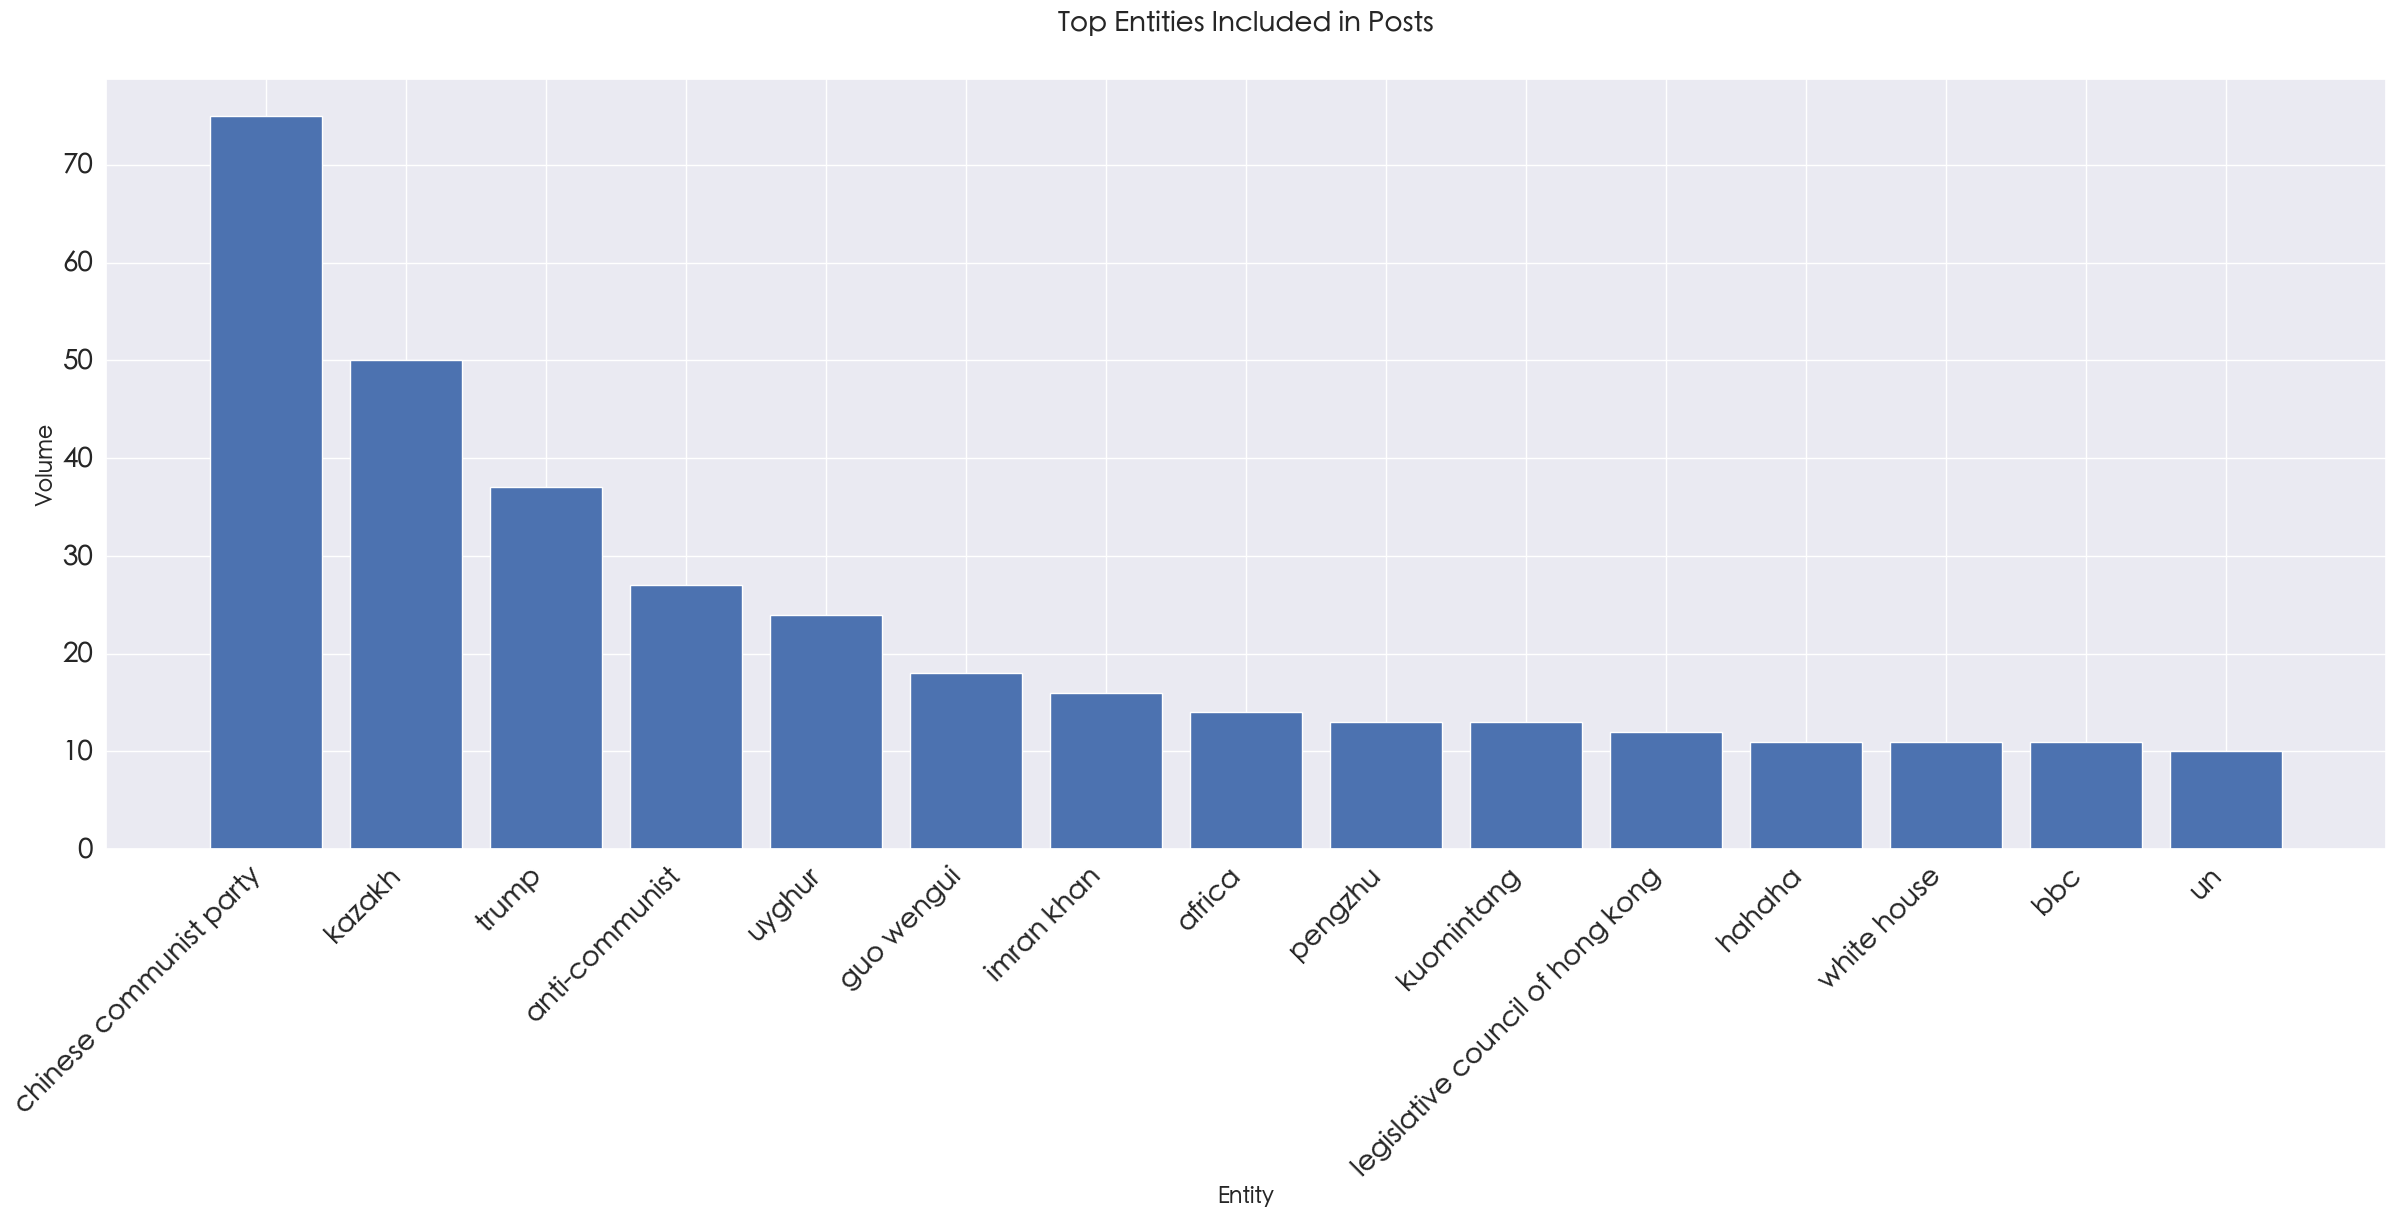

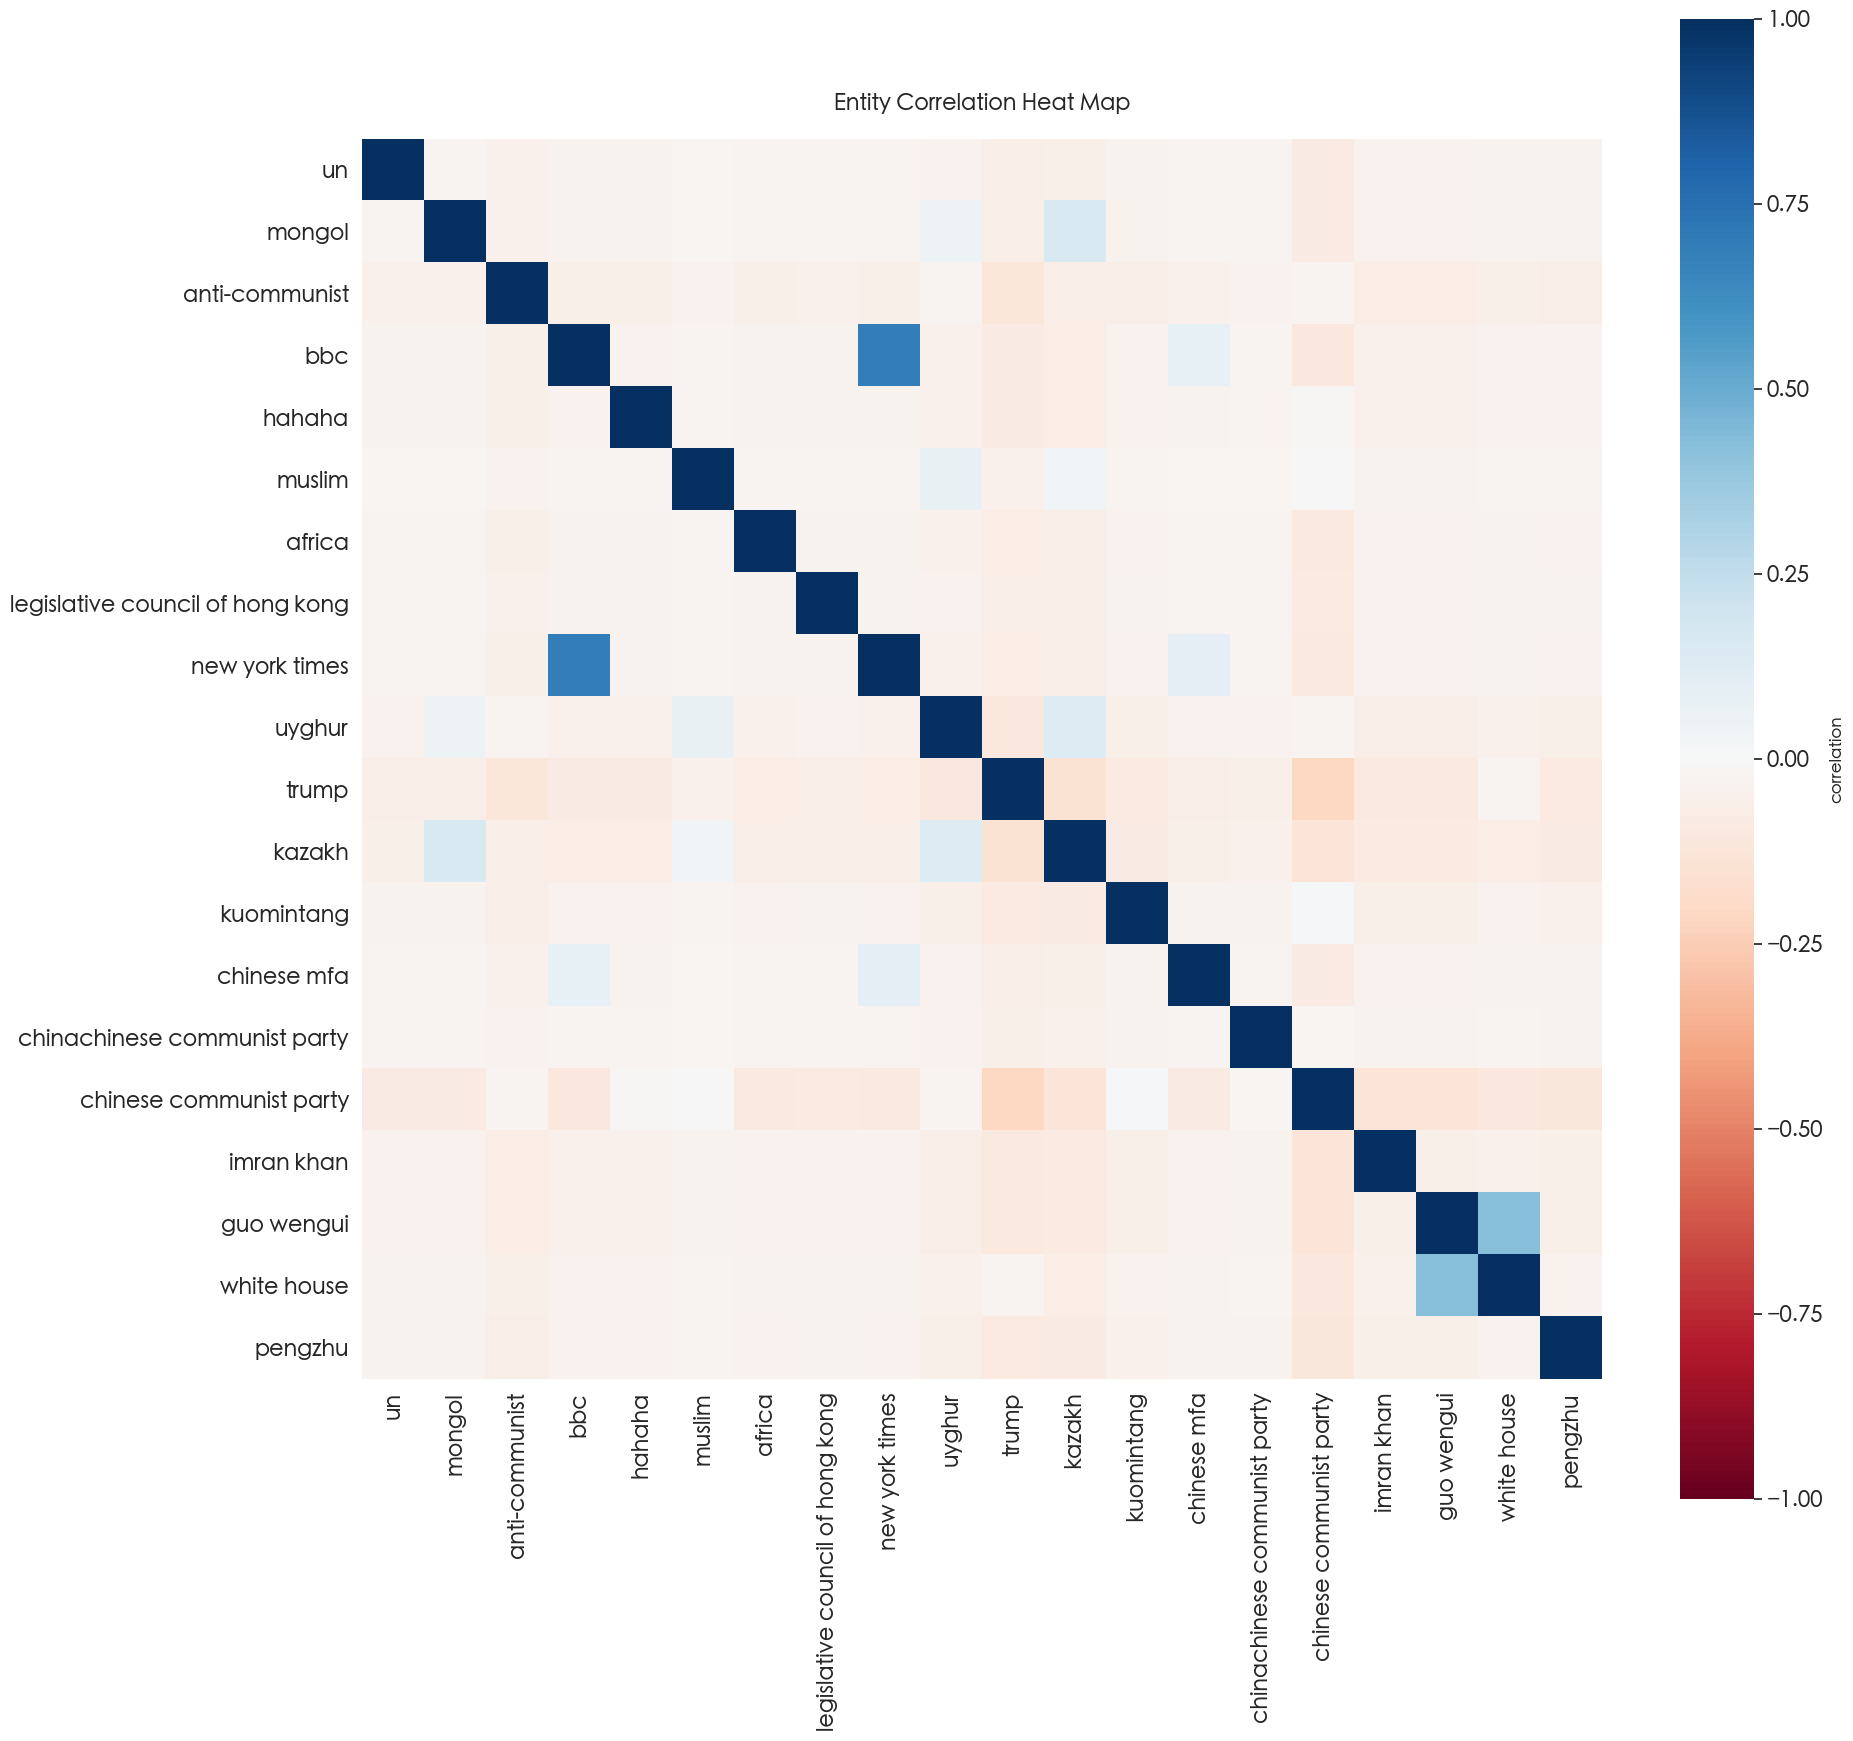

In [134]:
start_time = time.time()

top_entities_corr_noGPE(df3, output_path_suspended, inc_cols)

print("--- %s seconds ---" % (time.time() - start_time))

# Ran in 1.5 seconds on 460 rows 
# Ran in 5.02 seconsds on larger 43,154 row dataset

Not Suspended

In [135]:
df_flat_not_suspended = df_not_suspended.groupby(['cleantext', 'langdetected']).size()\
                    .reset_index(name='counts')\
                    .sort_values('counts', ascending=False)\
                    .reset_index(drop=True)
df_flat_not_suspended.head()

,cleantext,langdetected,counts
0,hello i m professional vector portrait cartoon...,en,1041
1,rt,und,708
2,check out my gig on fiverr i will do unique mo...,en,141
3,newprofilepic,und,89
4,ahpcouncilourright,und,88


In [136]:
df_flat_not_suspended['cleantext'] = df_flat_not_suspended['cleantext'].apply(lambda x: emoji.demojize(x, delimiters=("", " ")) if pd.notnull(x) else x)
df_flat_not_suspended.head()

,cleantext,langdetected,counts
0,hello i m professional vector portrait cartoon...,en,1041
1,rt,und,708
2,check out my gig on fiverr i will do unique mo...,en,141
3,newprofilepic,und,89
4,ahpcouncilourright,und,88


In [137]:
df_flat_not_suspended.to_csv(results_bucket + 'df_flat_not_suspended_forNER.csv', index=False, encoding = "utf_8_sig")

In [138]:
df_flat_not_suspended = pd.read_csv(results_bucket + "df_flat_not_suspended_forNER.csv", error_bad_lines=False, encoding='utf-8')

In [139]:
start_time = time.time()

df3_ns = ner_loop_multi_lang(df_flat_not_suspended)

print("--- %s seconds ---" % (time.time() - start_time))

# 460 rows in 2.9 seconds | Down to 108 rows and 2.5 seconds when collapsing to counts | 121 and 1.22 seconds when using fasttext (Winner)
# 40,823 rows in 538 seconds (8.9 min) - Full dataset was 43,154, so 5% without entities | 
    # Down to 10960 rows and 214 seconds when collapsing to counts (3.5 min)
    # Down to 11530 rows and 98 seconds when collapsing to counts and using fasttext (1.63 min) [Seems to range btwn 98 and 158 seconds]

--- 2036.1079640388489 seconds ---


In [145]:
print(df3_ns.columns)

Index(['text', 'count', 'PERSON', 'GPE', 'NORP', 'TIME', 'ORG', 'DATE',
       'ORDINAL', 'CARDINAL', 'LOC', 'FAC', 'EVENT', 'QUANTITY', 'WORK_OF_ART',
       'PRODUCT', 'MONEY', 'LANGUAGE', 'LAW', 'PERCENT', 'MISC', 'PER',
       'TITLE_AFFIX', 'MOVEMENT', 'PET_NAME', 'FACILITY', 'NAT_REL_POL',
       'ORGANIZATION', 'DATETIME', 'NUMERIC_VALUE', 'ALL', 'All'],
      dtype='object')


In [146]:
inc_cols = ['GPE', 'NORP', 'ORG', 'ORGANIZATION', 'PERSON', 'ORDINAL', 'LOC', 'FAC', 'PRODUCT', 'EVENT', 'LANGUAGE', 'MISC', 'PER','NAT_REL_POL', 'WORK_OF_ART', 'LAW', 'MOVEMENT', 'PET_NAME', 'FACILITY', 'PER']

--- 11.713964223861694 seconds ---


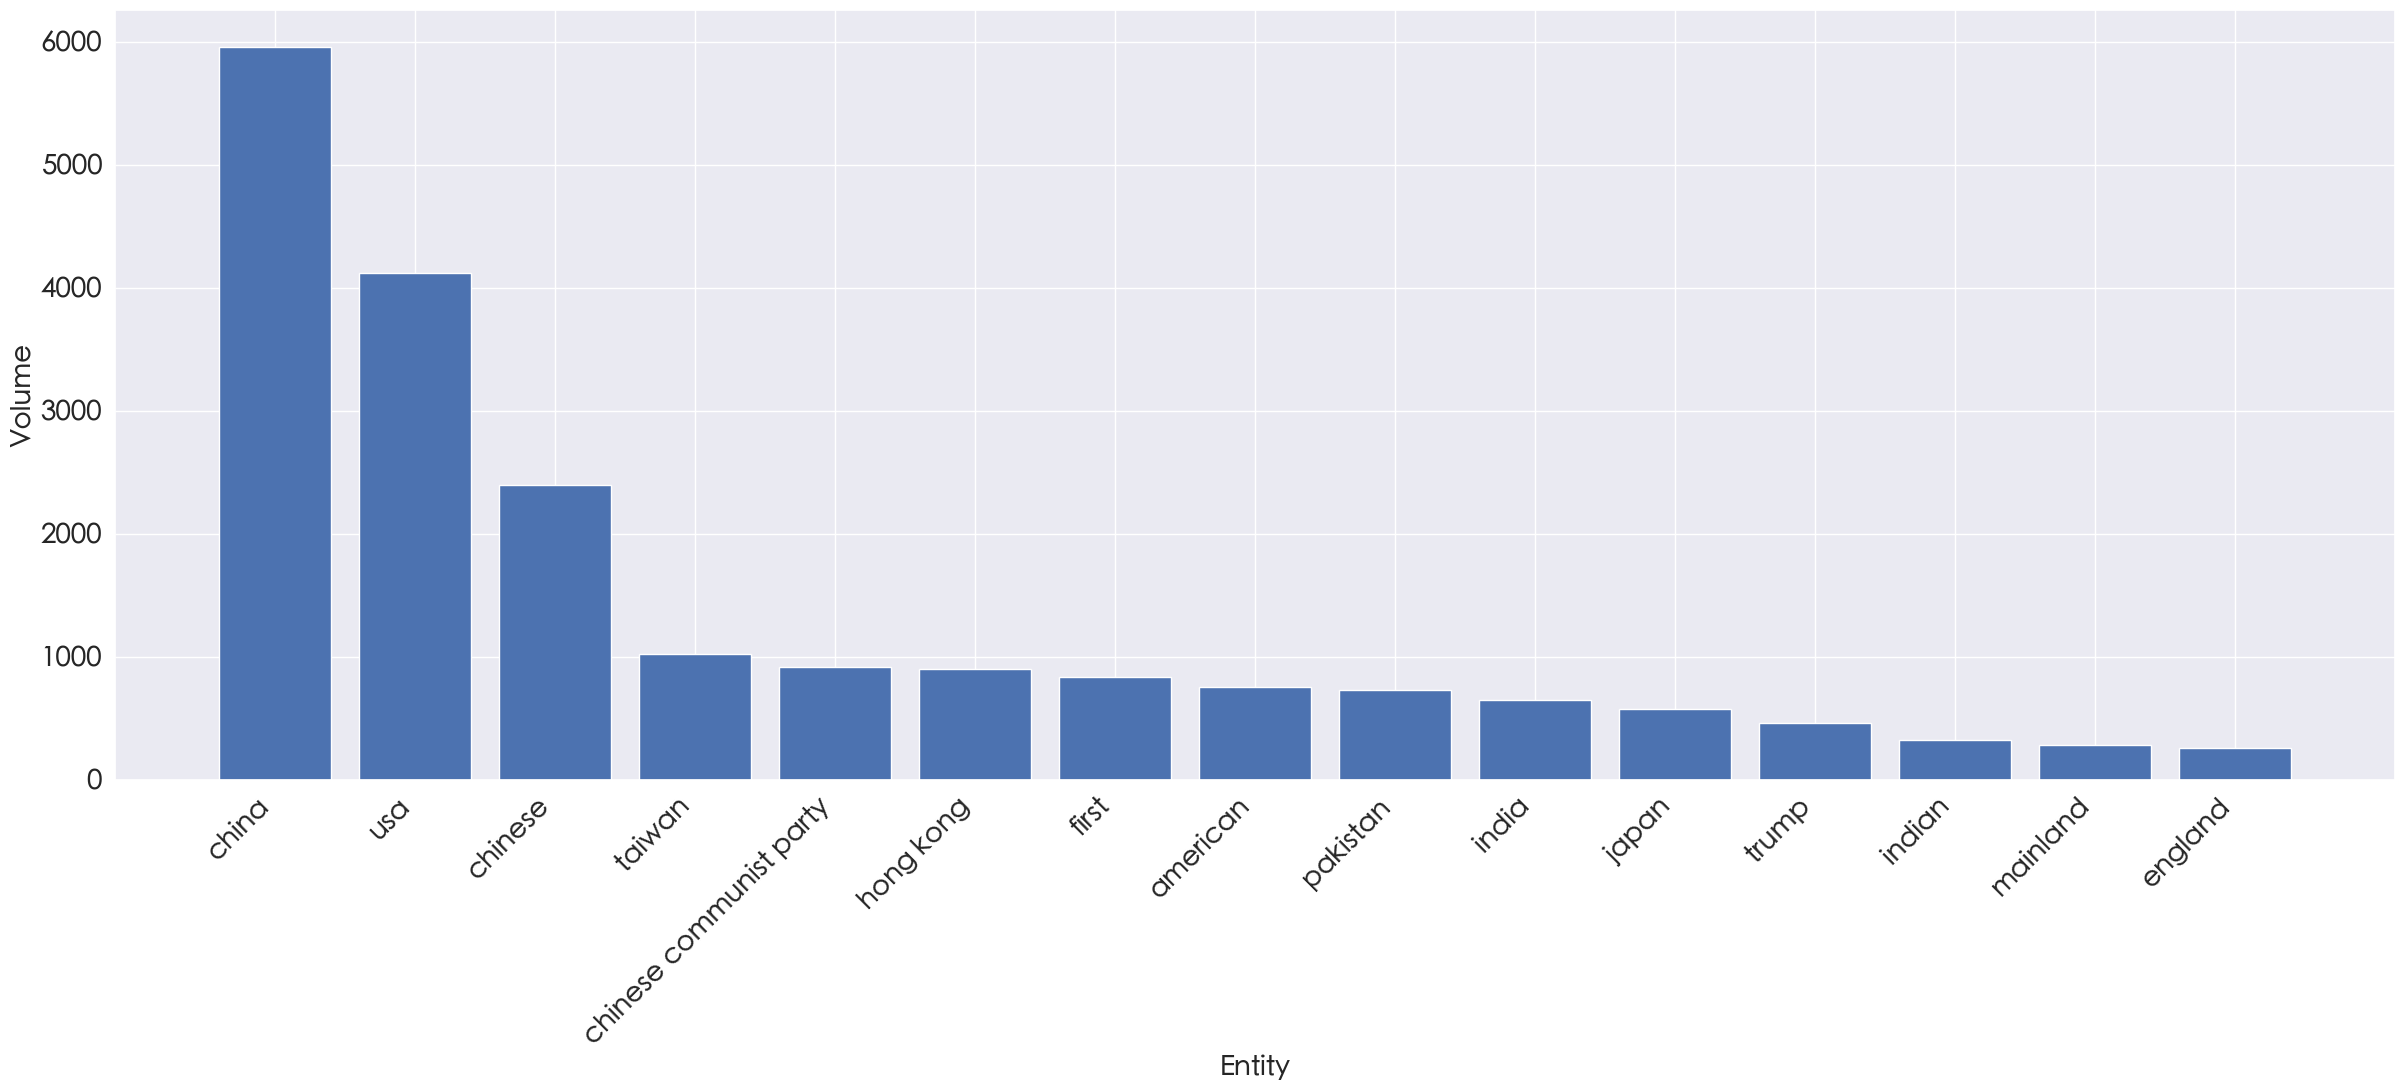

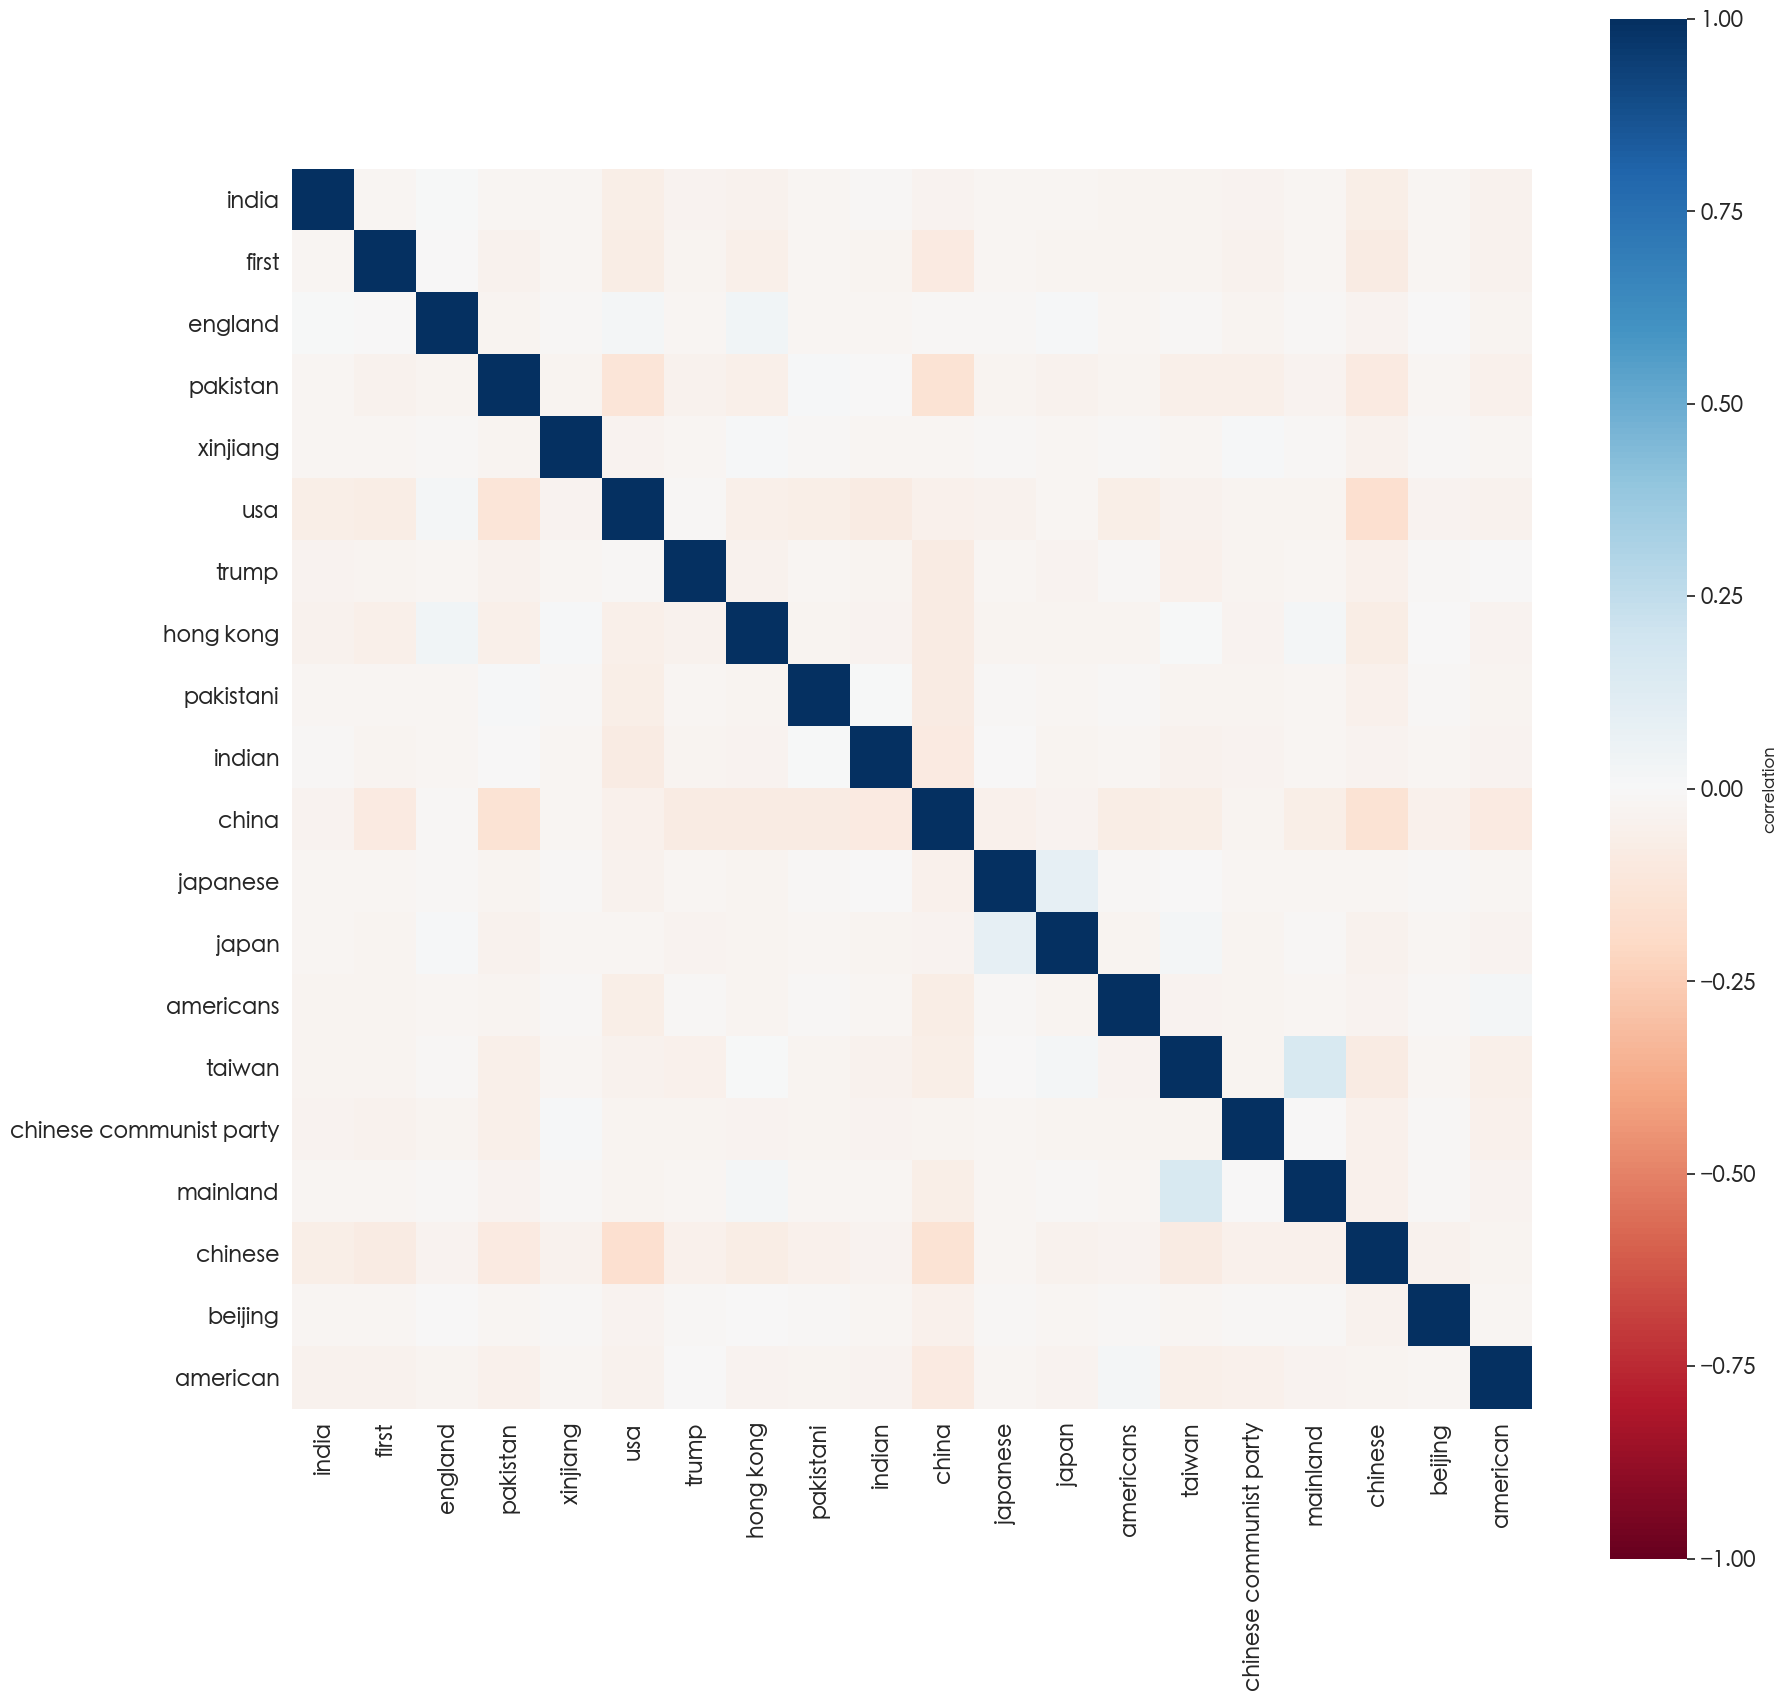

In [153]:
start_time = time.time()

top_entities_corr(df3_ns, output_path_not_suspended, inc_cols)

print("--- %s seconds ---" % (time.time() - start_time))

# Ran in 1.36 seconds on 460 rows original dataset
# Ran i 4.2 seconds on the larger 43,154 row dataset

In [154]:
inc_cols.remove('GPE')
inc_cols.remove('NORP')
inc_cols.remove('ORDINAL')
inc_cols.remove('LANGUAGE')

--- 13.11991000175476 seconds ---


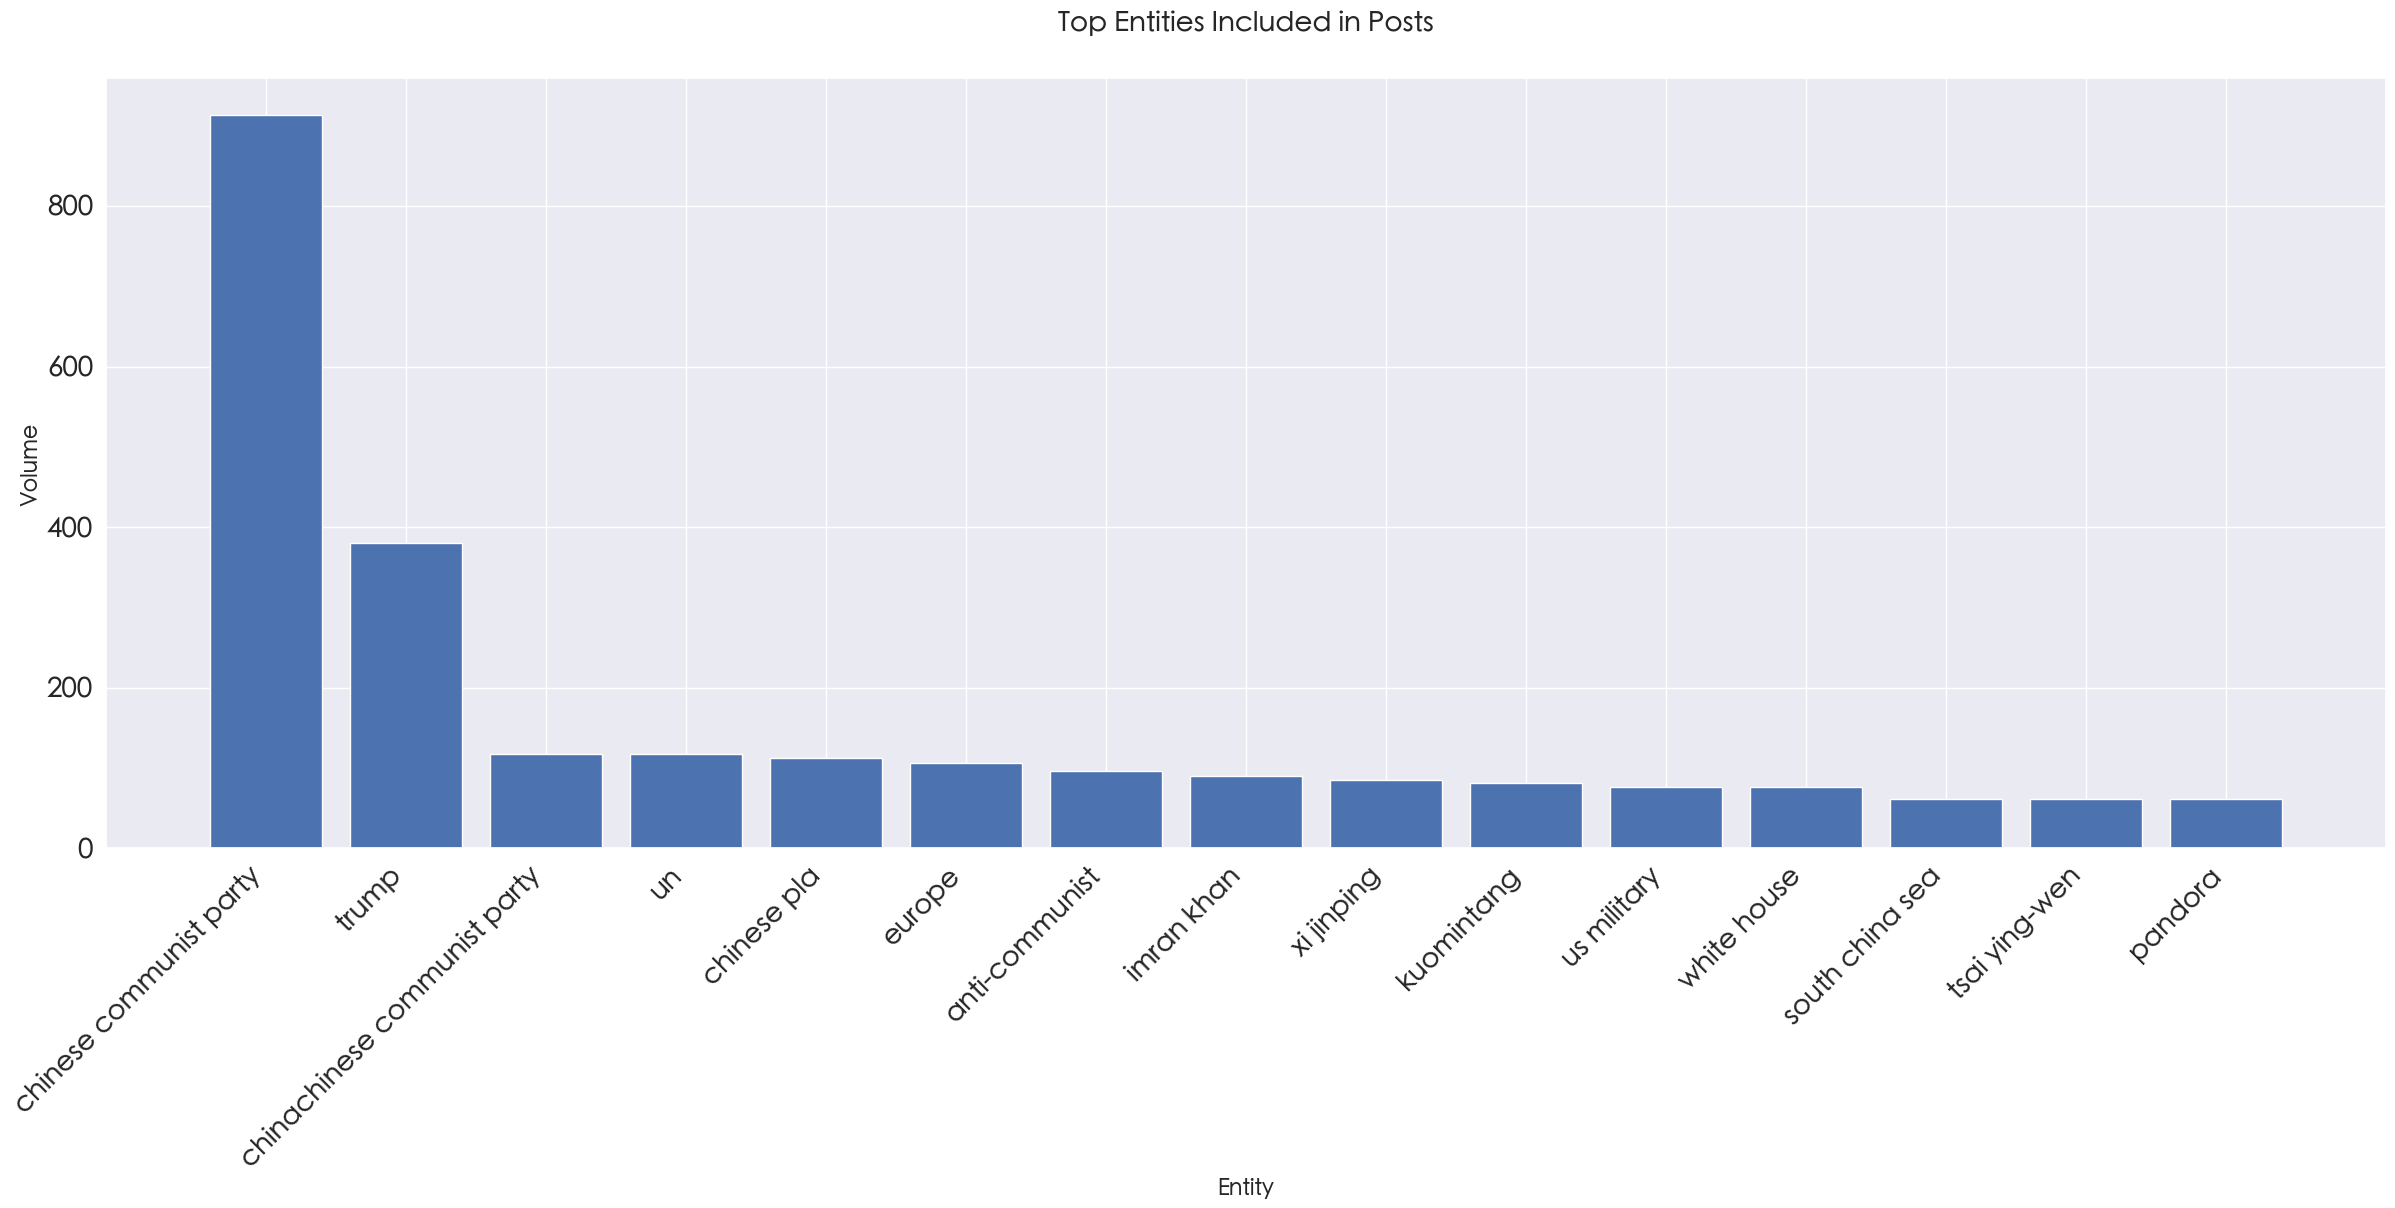

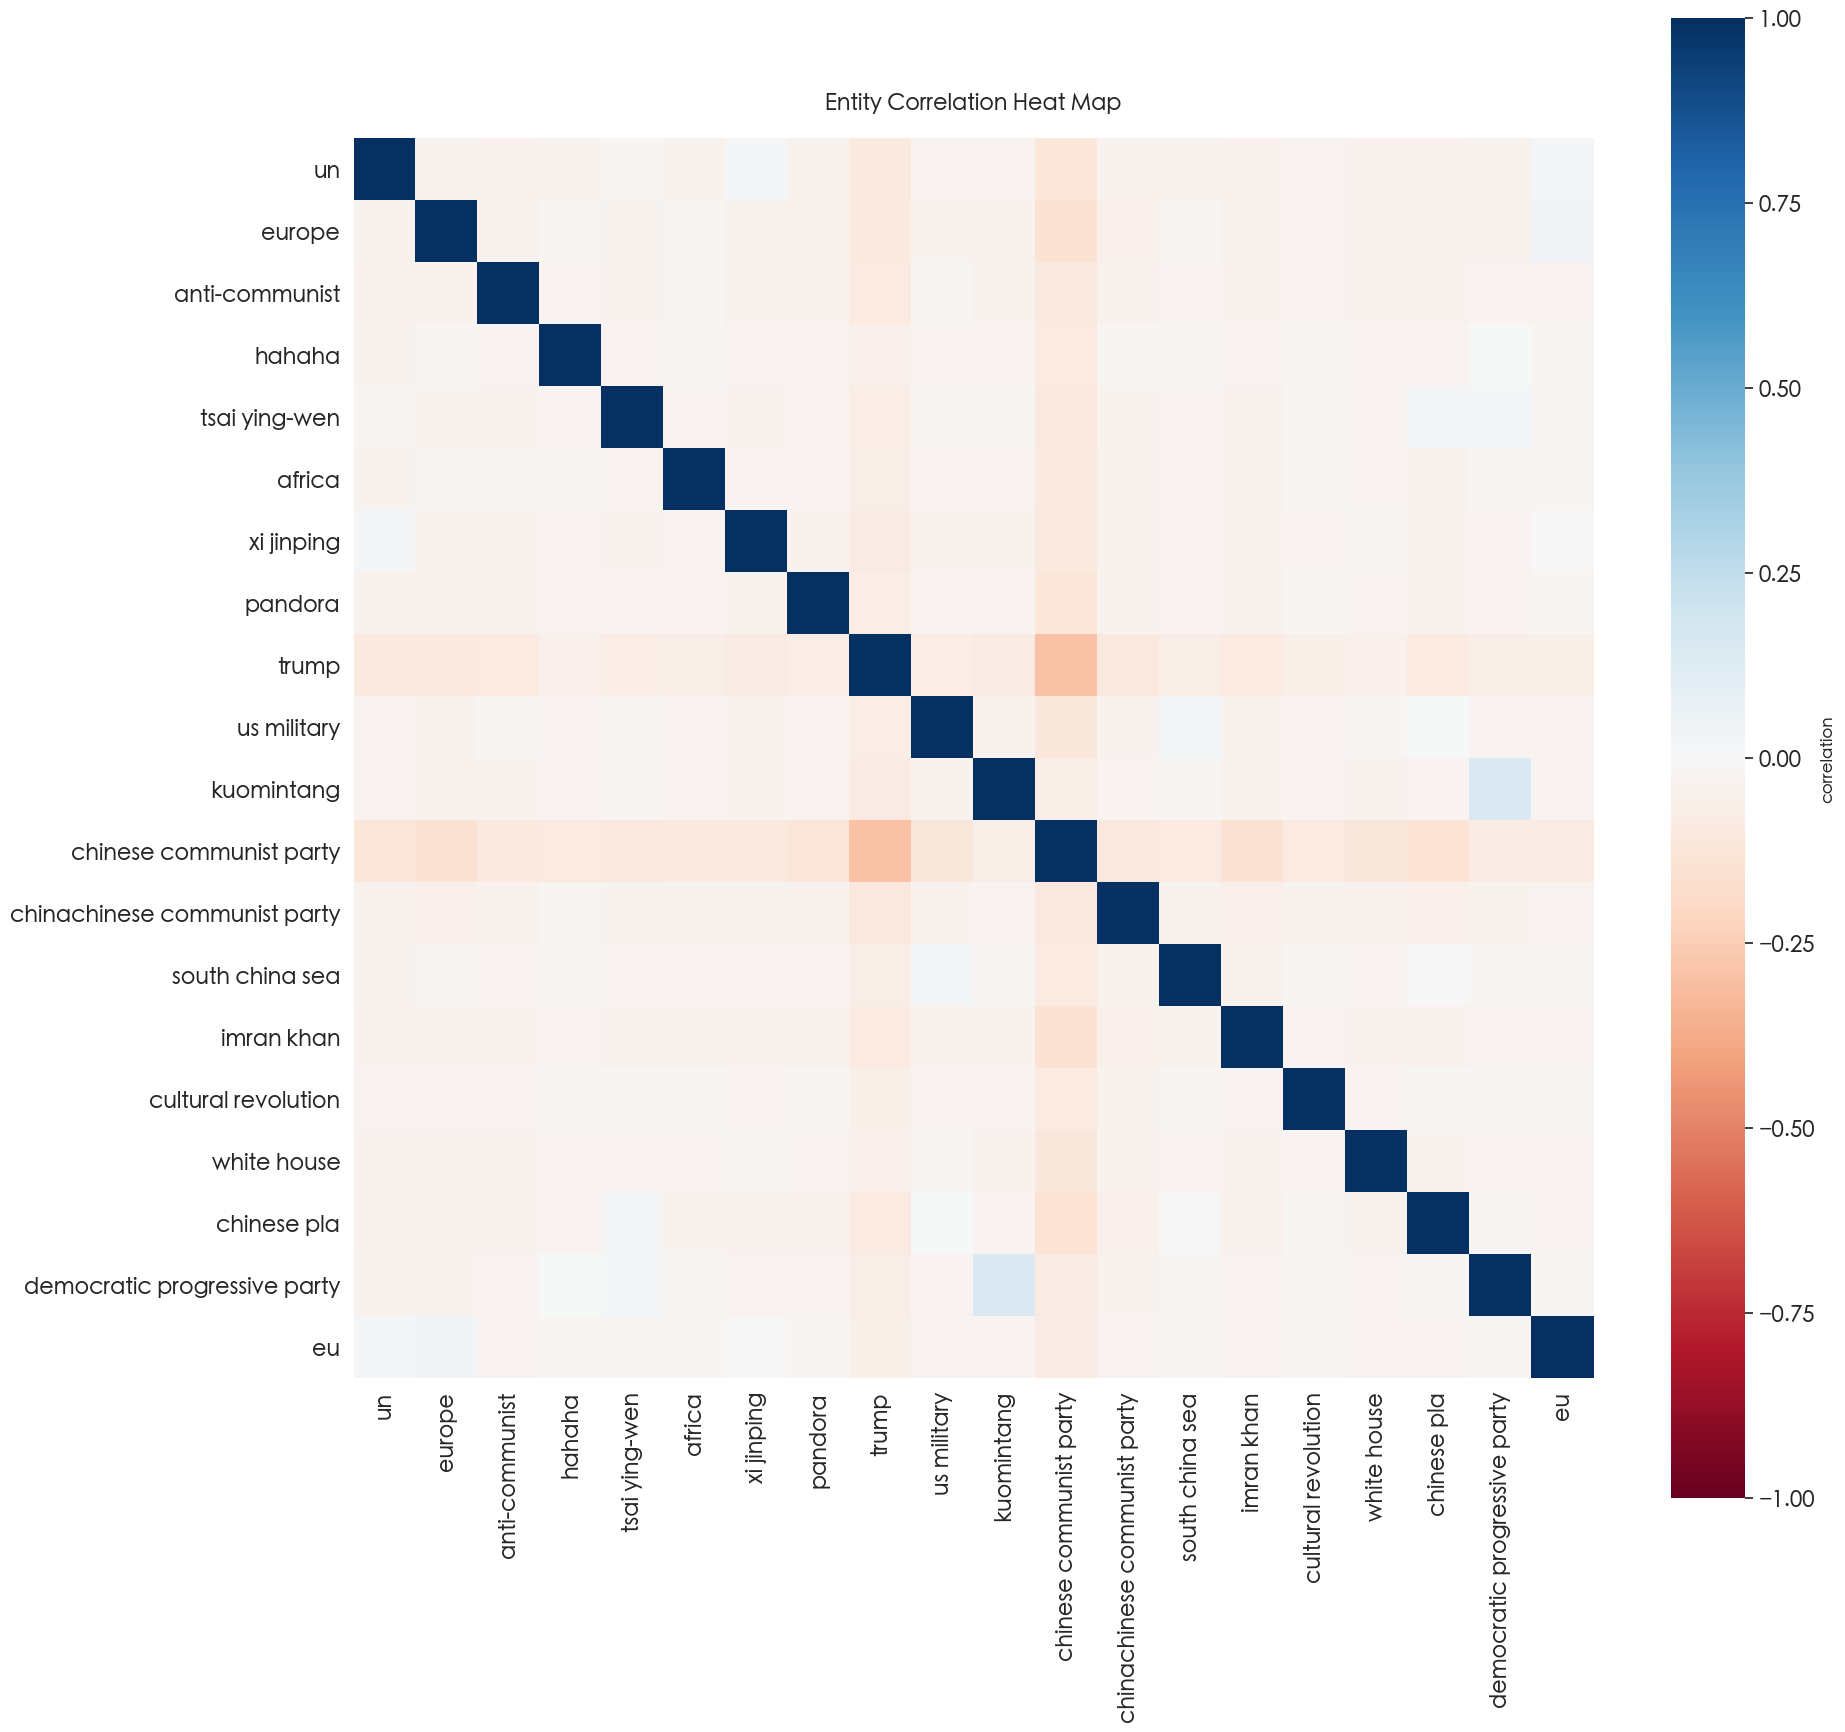

In [158]:
start_time = time.time()

top_entities_corr_noGPE(df3_ns, output_path_not_suspended, inc_cols)

print("--- %s seconds ---" % (time.time() - start_time))

# Ran in 1.5 seconds on 460 rows 
# Ran in 5.02 seconsds on larger 43,154 row dataset

Suspended last tweet 

In [161]:
df_flat_suspended_last_tweet = last_tweets.groupby(['cleantext', 'langdetected']).size()\
                    .reset_index(name='counts')\
                    .sort_values('counts', ascending=False)\
                    .reset_index(drop=True)
df_flat_suspended_last_tweet.head()

,cleantext,langdetected,counts
0,awsl,en,1
1,必须欢庆,zh,1
2,就冲着你跑到美国找靠山去了这一点，就是一个端起碗吃肉，放下碗骂娘的主。,zh,1
3,寻找所有人的匿名问题！ 最近回答的提问 ● how do u think 问题框 寻找匿名问题,zh,1
4,对,zh,1


In [162]:
df_flat_suspended_last_tweet['cleantext'] = df_flat_suspended_last_tweet['cleantext'].apply(lambda x: emoji.demojize(x, delimiters=("", " ")) if pd.notnull(x) else x)
df_flat_suspended_last_tweet.head()

,cleantext,langdetected,counts
0,awsl,en,1
1,必须欢庆,zh,1
2,就冲着你跑到美国找靠山去了这一点，就是一个端起碗吃肉，放下碗骂娘的主。,zh,1
3,寻找所有人的匿名问题！ 最近回答的提问 ● how do u think 问题框 寻找匿名问题,zh,1
4,对,zh,1


In [163]:
start_time = time.time()

df3_ns_lt = ner_loop_multi_lang(df_flat_suspended_last_tweet)

print("--- %s seconds ---" % (time.time() - start_time))

# 460 rows in 2.9 seconds | Down to 108 rows and 2.5 seconds when collapsing to counts | 121 and 1.22 seconds when using fasttext (Winner)
# 40,823 rows in 538 seconds (8.9 min) - Full dataset was 43,154, so 5% without entities | 
    # Down to 10960 rows and 214 seconds when collapsing to counts (3.5 min)
    # Down to 11530 rows and 98 seconds when collapsing to counts and using fasttext (1.63 min) [Seems to range btwn 98 and 158 seconds]

--- 3.1551270484924316 seconds ---


In [164]:
print(df3_ns_lt.columns)

Index(['text', 'count', 'NORP', 'PERSON', 'LANGUAGE', 'GPE', 'DATE', 'ORG',
       'CARDINAL', 'EVENT', 'LOC', 'TIME', 'FAC', 'TITLE_AFFIX'],
      dtype='object')


In [177]:
inc_cols = ['NORP', 'ORG', 'PERSON', 'LANGUAGE', 'GPE', 'EVENT', 'LOC', 'FAC']

--- 1.5752179622650146 seconds ---


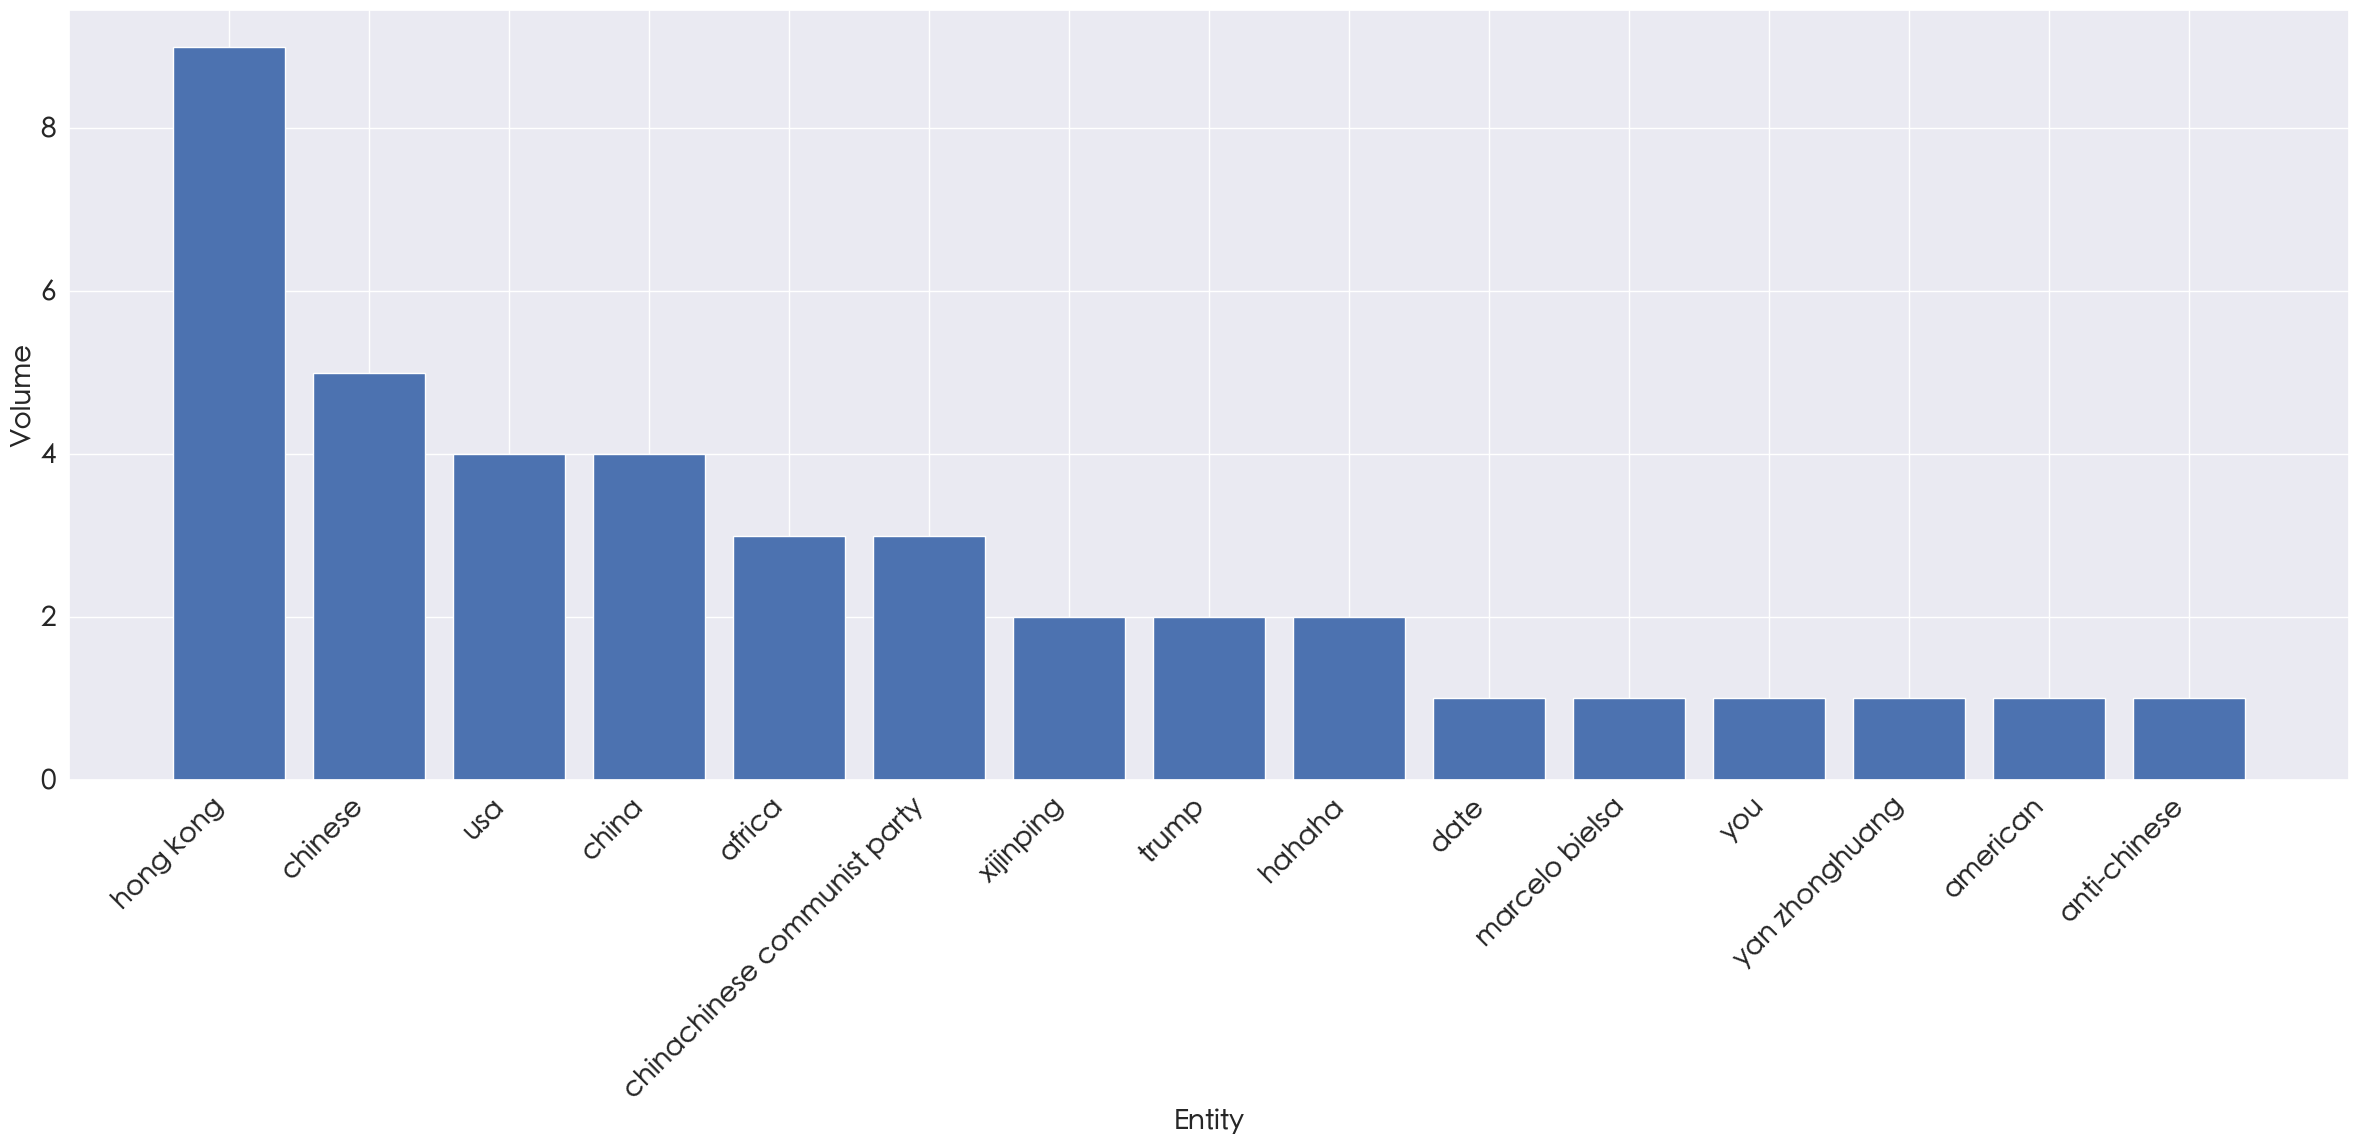

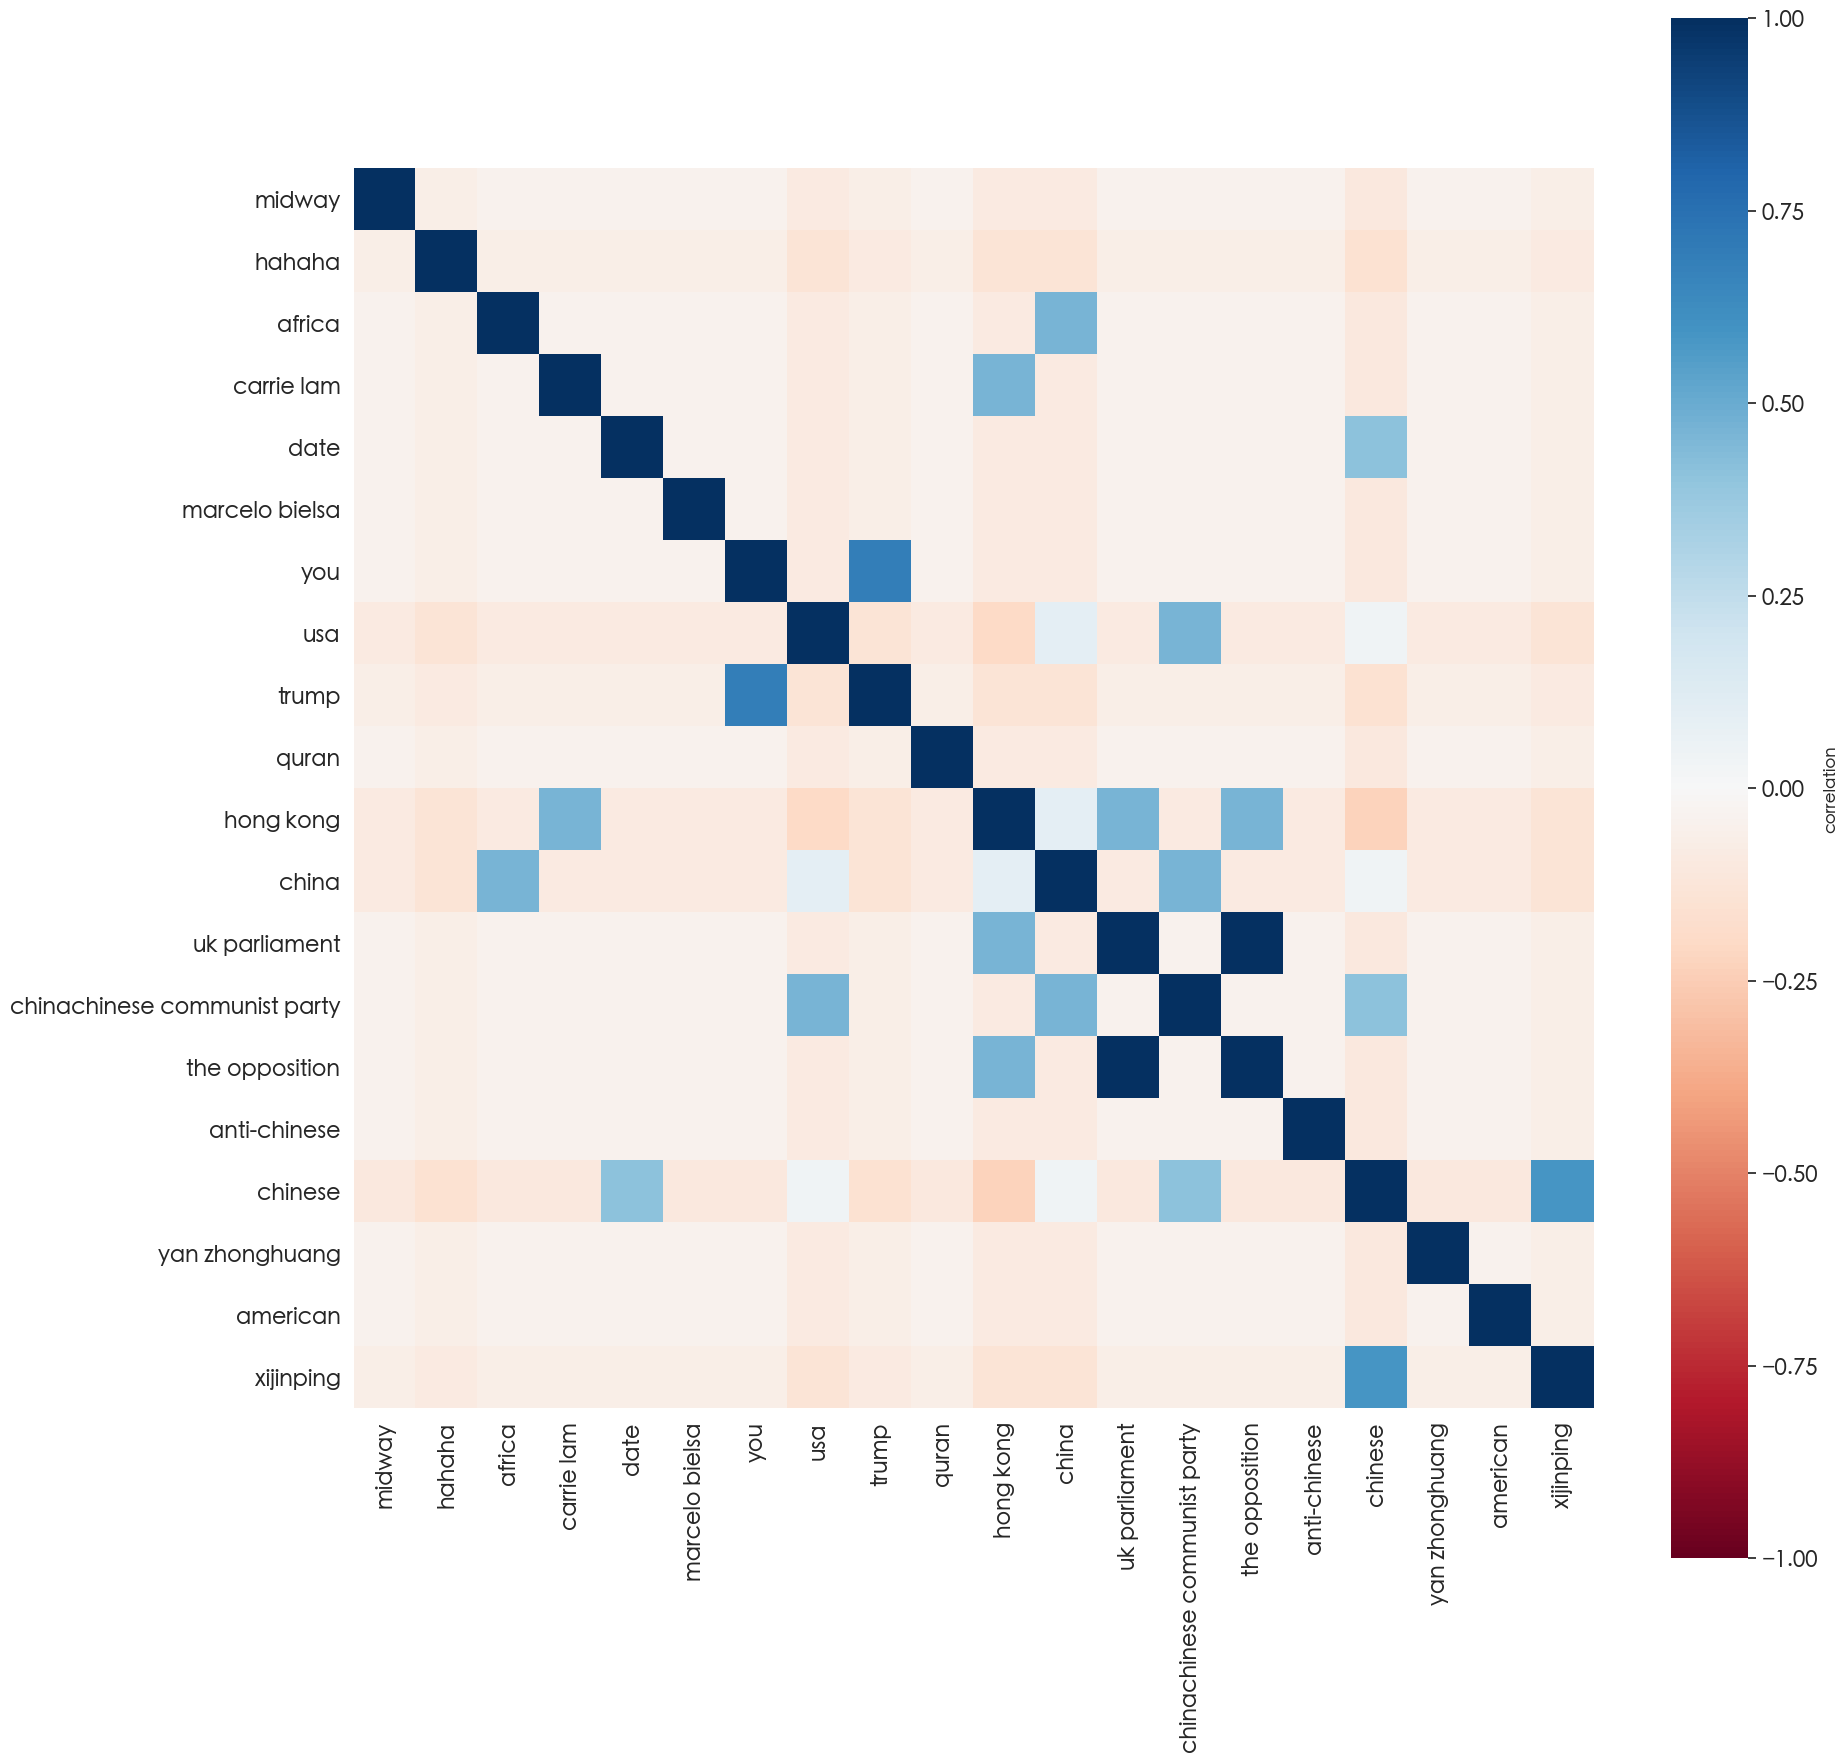

In [184]:
start_time = time.time()

top_entities_corr(df3_ns_lt, output_path_suspended_last_tweet, inc_cols)

print("--- %s seconds ---" % (time.time() - start_time))

# Ran in 1.36 seconds on 460 rows original dataset
# Ran i 4.2 seconds on the larger 43,154 row dataset

In [185]:
inc_cols.remove('GPE')
inc_cols.remove('NORP')
inc_cols.remove('LANGUAGE')

--- 1.7543680667877197 seconds ---


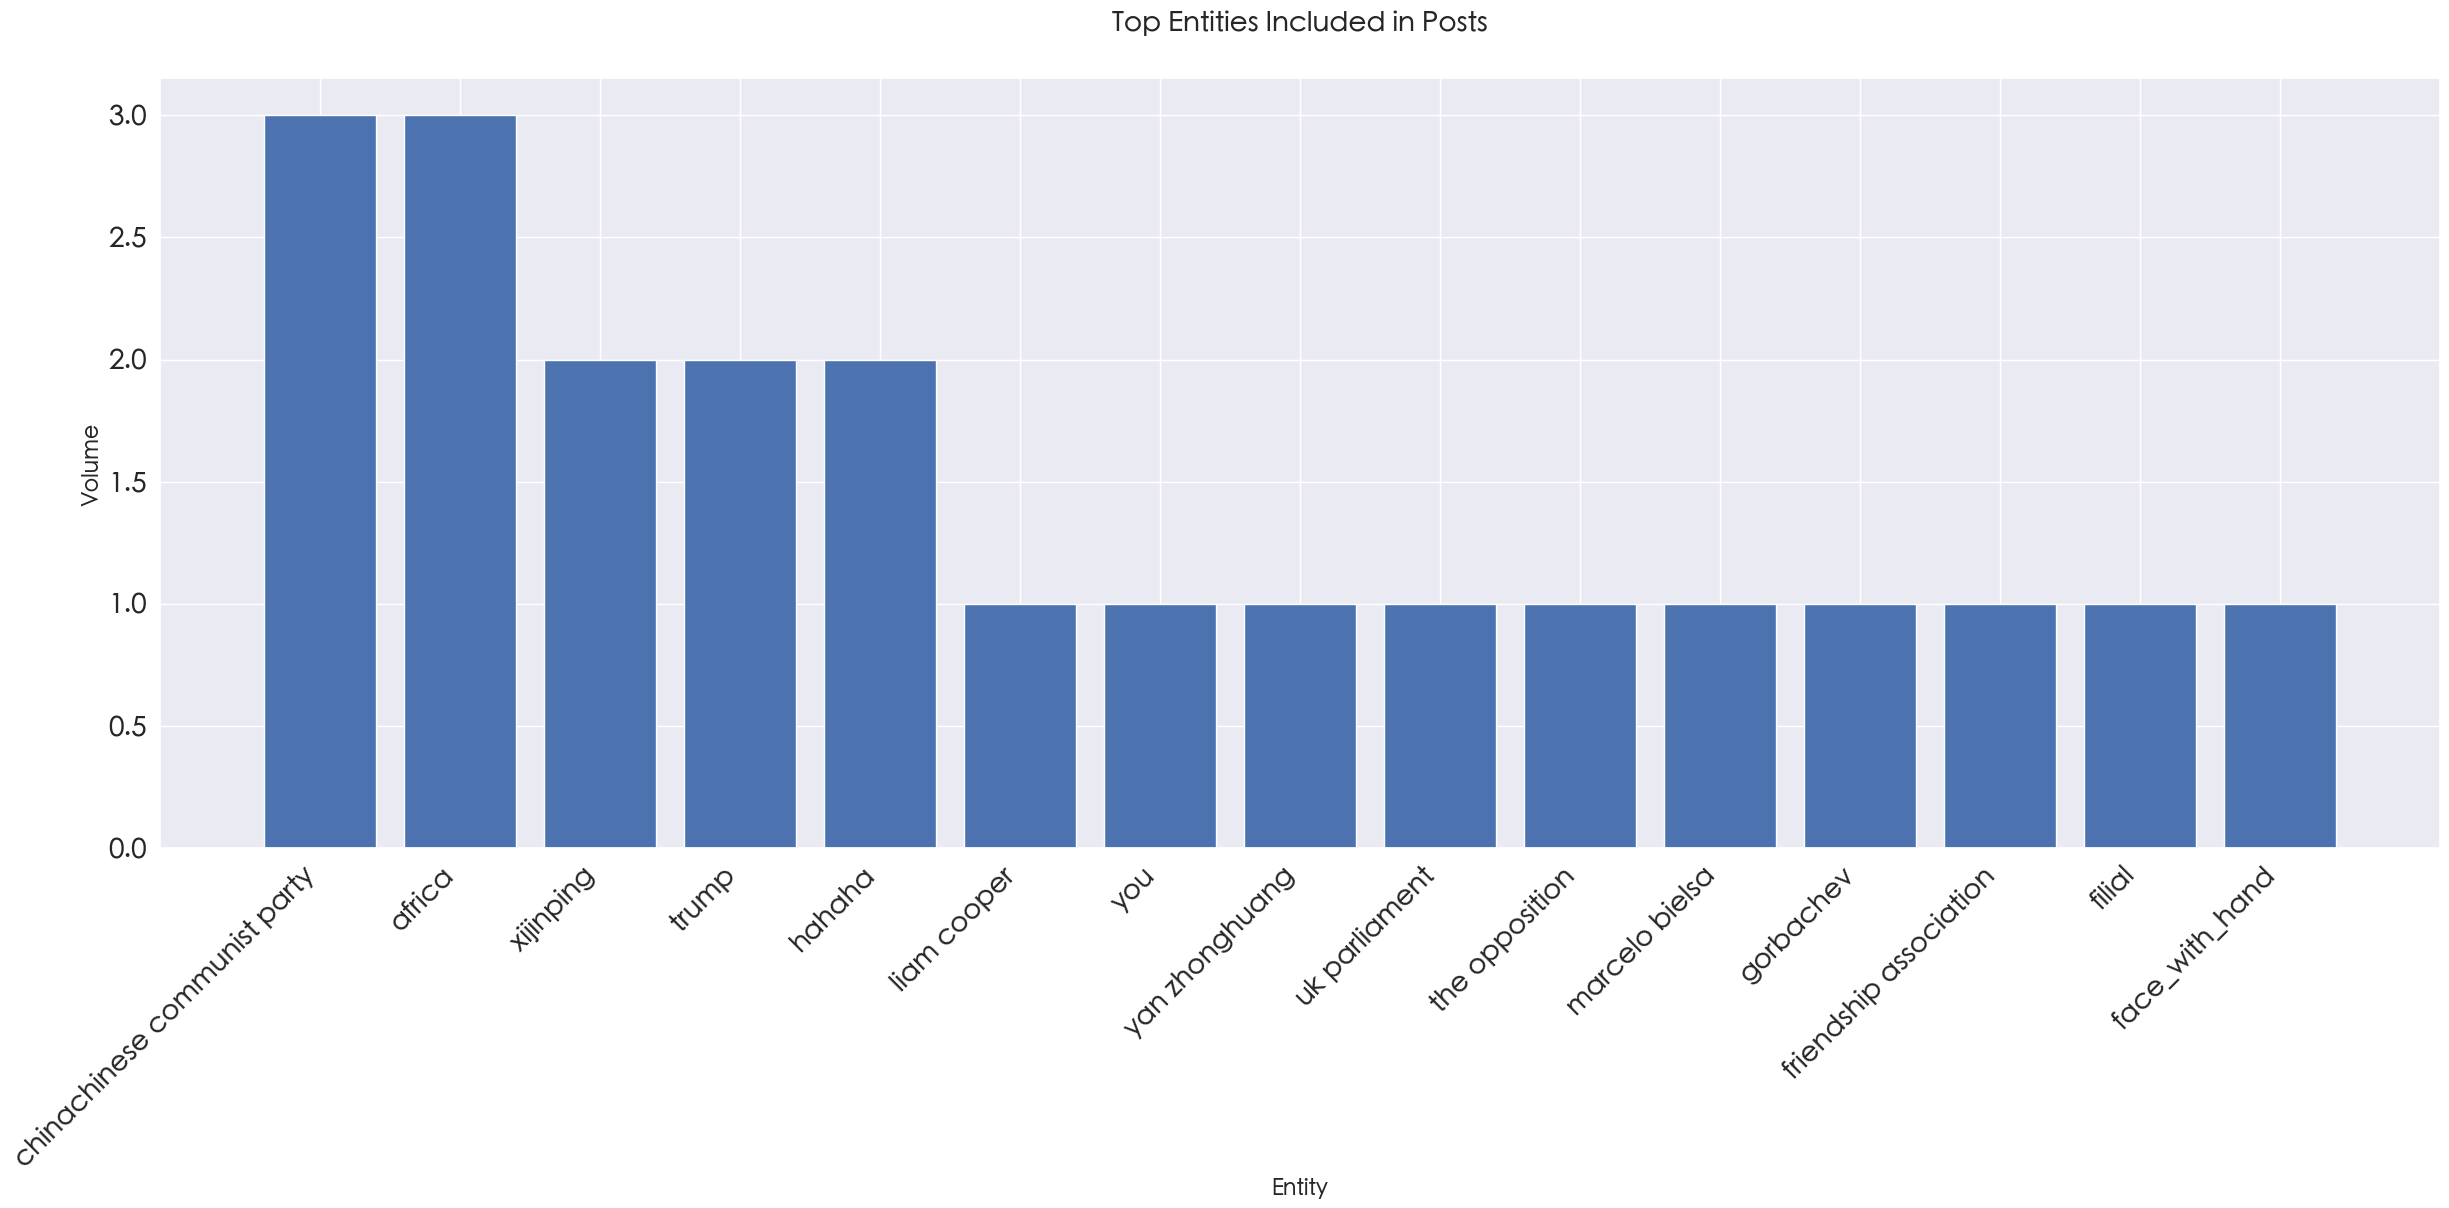

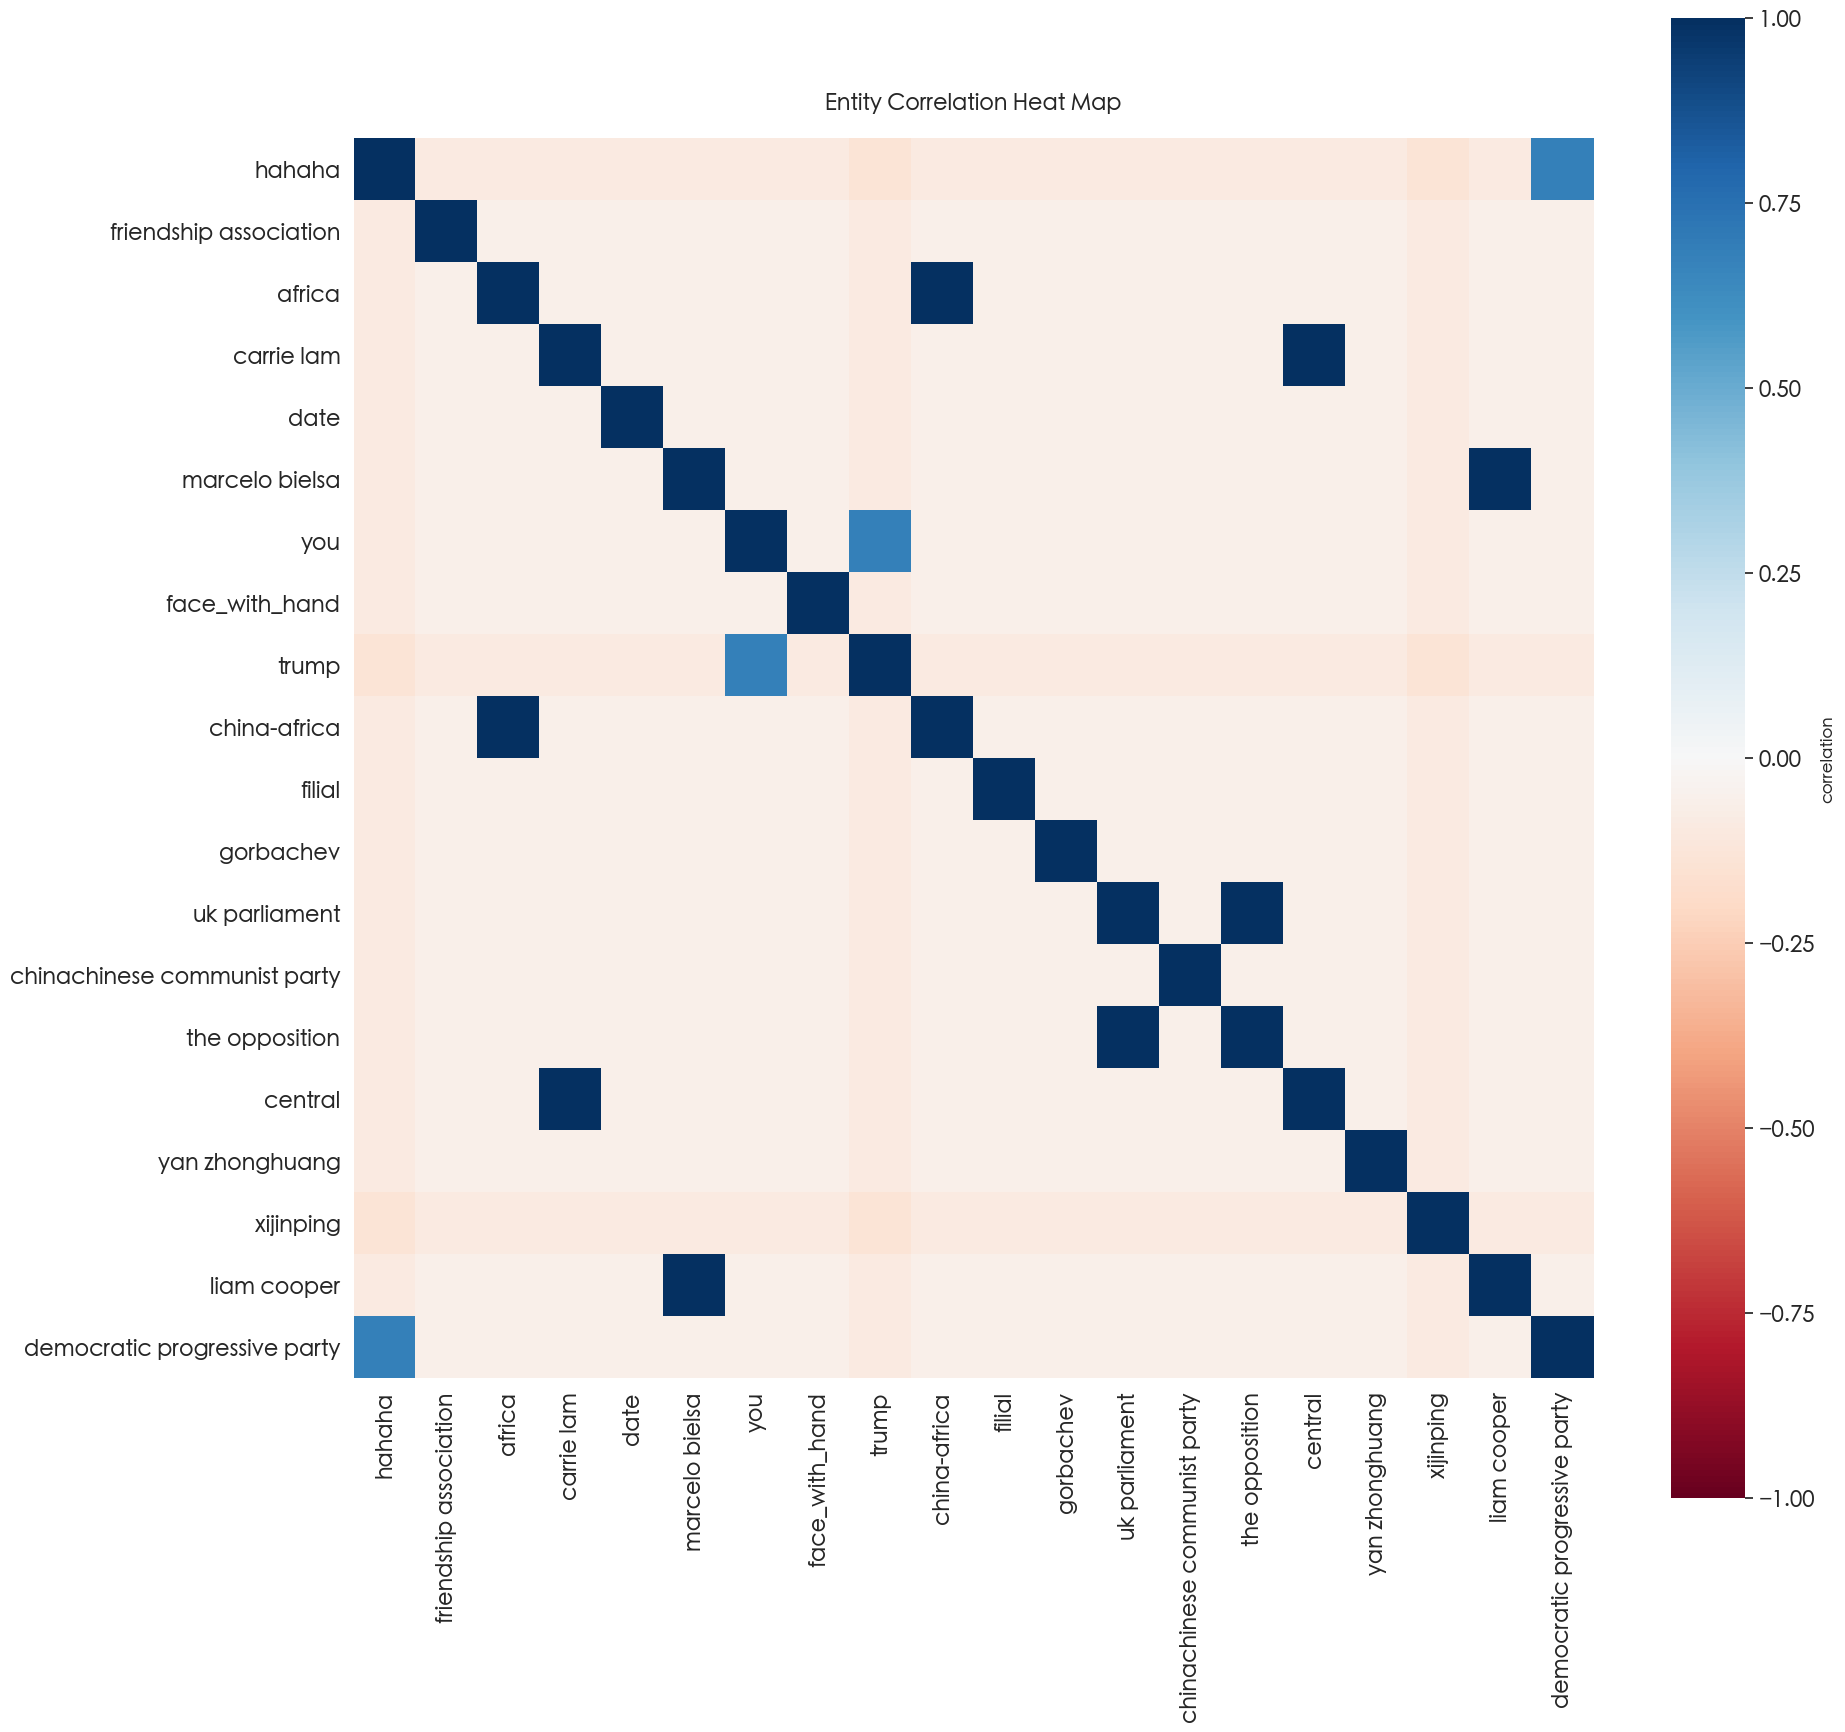

In [186]:
start_time = time.time()

top_entities_corr_noGPE(df3_ns_lt, output_path_suspended_last_tweet, inc_cols)

print("--- %s seconds ---" % (time.time() - start_time))

# Ran in 1.5 seconds on 460 rows 
# Ran in 5.02 seconsds on larger 43,154 row dataset

## Hashtag Analysis 

Not Suspended

In [187]:
P = df_train[df_train['suspended'] == 0].text.str.extractall(r'(\#\w+)')[0].value_counts().rename_axis('hashtag').reset_index(name='counts')
P.head(10)

,hashtag,counts
0,#China,369
1,#logo,264
2,#Pakistan,236
3,#fiverr,230
4,#US,184
5,#ناقابل_تسخیر_افواج_پاکستان,179
6,#graphicdesigner,159
7,#COVID19,158
8,#HongKong,140
9,#Creative,118


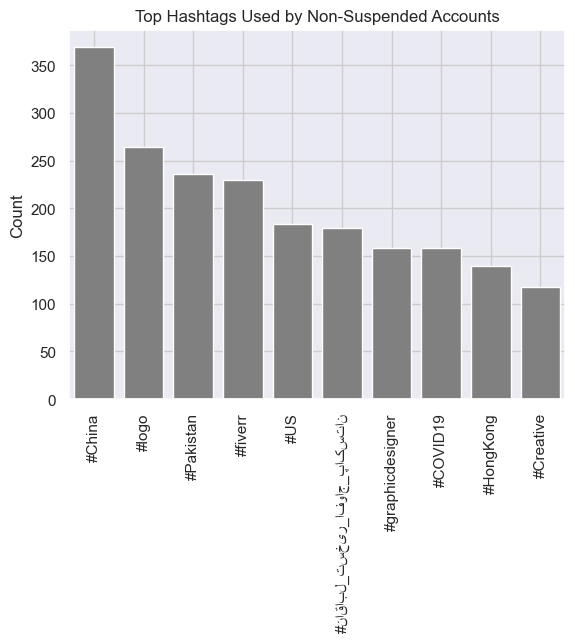

In [188]:
# Some boilerplate to initialise things
sns.set()
plt.figure()

# This is where the actual plot gets made
ax = sns.barplot(data=P[:10], x="hashtag", y="counts", palette=['blue'], saturation=0)

# Customise some display properties
ax.set_title('Top Hashtags Used by Non-Suspended Accounts')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel(None)
ax.set_xticklabels(P[:10]["hashtag"].unique().astype(str), rotation='vertical')

# Ask Matplotlib to show it
plt.savefig(results_bucket+'top_hashtags_non_suspended accounts.png', bbox_inches='tight')
plt.show()

Suspended

In [209]:
P = df_train[df_train['suspended'] == 1].text.str.extractall(r'(\#\w+)')[0].value_counts().rename_axis('hashtag').reset_index(name='counts')
P.head(10)

,hashtag,counts
0,#MyPakistan,181
1,#کھپ_ناڈالو_رسیدیں_نکالو,85
2,#Kashmir,35
3,#Balochistan,19
4,#Pakistan,18
5,#China,15
6,#KashmiriLivesMatter,15
7,#PLA,15
8,#CPEC,13
9,#ComsatsReduceFee,11


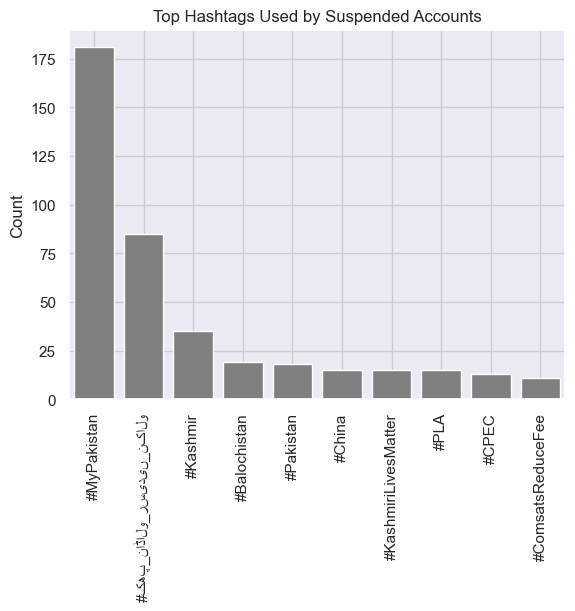

In [190]:
# Some boilerplate to initialise things
sns.set()
plt.figure()

# This is where the actual plot gets made
ax = sns.barplot(data=P[:10], x="hashtag", y="counts", palette=['blue'], saturation=0)

# Customise some display properties
ax.set_title('Top Hashtags Used by Suspended Accounts')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel(None)
ax.set_xticklabels(P[:10]["hashtag"].unique().astype(str), rotation='vertical')

# Ask Matplotlib to show it
plt.savefig(results_bucket+'top_hashtags_suspended accounts.png', bbox_inches='tight')
plt.show()

Suspended Last Tweet

In [95]:
pd.to_datetime(df_train['created_at'], format='%Y-%m-%d %H:%M:%S.%f')
my_datetime = dt.datetime(1970,1,1) 
good_dt = pytz.timezone('UTC').localize(my_datetime)
good_dt

datetime.datetime(1970, 1, 1, 0, 0, tzinfo=<UTC>)

In [96]:
df_train["created_at"] = pd.to_datetime(df_train["created_at"], format='%Y-%m-%d %H:%M:%S').dt.tz_localize('UTC')
df_train['created_at'] = pd.to_datetime(df_train['created_at'], format='%Y-%m-%d %H:%M:%S.%f')
my_datetime = dt.datetime(1970,1,1) 
good_dt = pytz.timezone('UTC').localize(my_datetime)
df_train['created_at'] = (df_train['created_at'] - good_dt).dt.total_seconds()

In [191]:
last_tweets = df_train.loc[df_train.groupby('user.id').created_at.idxmax()]

In [192]:
P = last_tweets.text.str.extractall(r'(\#\w+)')[0].value_counts().rename_axis('hashtag').reset_index(name='counts')
P.head(10)

,hashtag,counts
0,#NewProfilePic,8
1,#新头像,8
2,#Huawei,3
3,#LAKERSWIN,3
4,#NationalDay,3
5,#COVID19,3
6,#XiJinping,2
7,#KarachiRain,2
8,#China,2
9,#kungfupanda,2


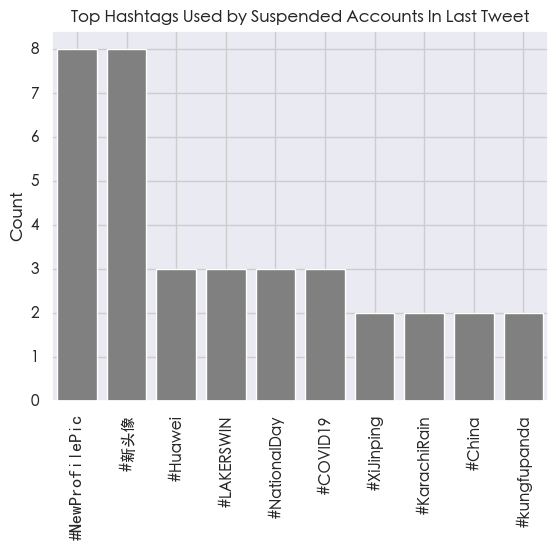

In [202]:
# Some boilerplate to initialise things
sns.set()
plt.figure()
matplotlib.rcParams['font.family'] = ['Heiti TC']

# This is where the actual plot gets made
ax = sns.barplot(data=P[:10], x="hashtag", y="counts", palette=['blue'], saturation=0)

# Customise some display properties
ax.set_title('Top Hashtags Used by Suspended Accounts In Last Tweet')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel(None)
ax.set_xticklabels(P[:10]["hashtag"].unique().astype(str), rotation='vertical', fontproperties=fontprop)

# Ask Matplotlib to show it
plt.savefig(results_bucket+'top_hashtags_non_suspended_lasttweets_accounts.png', bbox_inches='tight')
plt.show()


# Follow this if not seeing Chinese characters: https://hoishing.medium.com/using-chinese-characters-in-matplotlib-5c49dbb6a2f7

## Account Mentions Analysis

Not Suspended 

In [203]:
P = df_train[df_train['suspended'] == 0].text.str.extractall(r'@([A-Za-z0-9_]+)')[0].value_counts().rename_axis('hashtag').reset_index(name='counts')
P.head(10)

,hashtag,counts
0,SpokespersonCHN,2367
1,VOAChinese,1925
2,HuXijin_GT,1822
3,globaltimesnews,1626
4,realDonaldTrump,1476
5,PDChinese,1422
6,USA_China_Talk,1373
7,dw_chinese,1132
8,iingwen,992
9,ImranKhanPTI,973


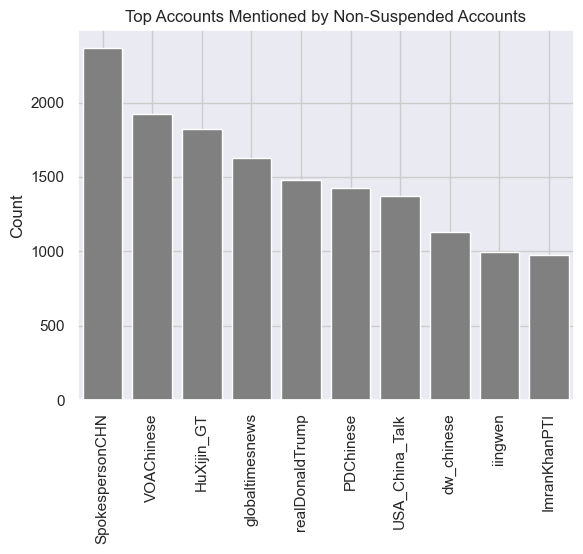

In [204]:
# Some boilerplate to initialise things
sns.set()
plt.figure()

# This is where the actual plot gets made
ax = sns.barplot(data=P[:10], x="hashtag", y="counts", palette=['blue'], saturation=0)

# Customise some display properties
ax.set_title('Top Accounts Mentioned by Non-Suspended Accounts')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel(None)
ax.set_xticklabels(P[:10]["hashtag"].unique().astype(str), rotation='vertical')

# Ask Matplotlib to show it
plt.savefig(results_bucket+'non_suspended_accounts_mentions.png', bbox_inches='tight')
plt.show()

Suspended

In [205]:
P = df_train[df_train['suspended'] == 1].text.str.extractall(r'@([A-Za-z0-9_]+)')[0].value_counts().rename_axis('hashtag').reset_index(name='counts')
P.head(10)

,hashtag,counts
0,globaltimesnews,318
1,VOAChinese,254
2,HuXijin_GT,216
3,realDonaldTrump,209
4,SecPompeo,139
5,jackson29436870,130
6,_Siddiqui__,127
7,USA_China_Talk,126
8,zhanglifan,115
9,Jiba1573,113


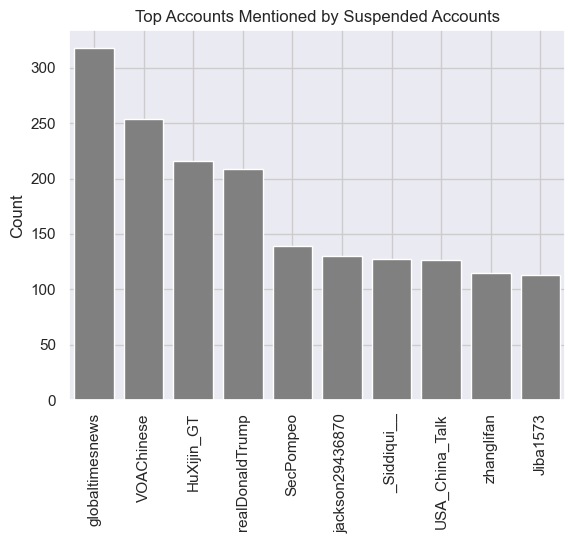

In [206]:
# Some boilerplate to initialise things
sns.set()
plt.figure()

# This is where the actual plot gets made
ax = sns.barplot(data=P[:10], x="hashtag", y="counts", palette=['blue'], saturation=0)

# Customise some display properties
ax.set_title('Top Accounts Mentioned by Suspended Accounts')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel(None)
ax.set_xticklabels(P[:10]["hashtag"].unique().astype(str), rotation='vertical')

# Ask Matplotlib to show it
plt.savefig(results_bucket+'suspended_accounts_mentions.png', bbox_inches='tight')
plt.show()

Suspended Last Tweet

In [207]:
P = last_tweets.text.str.extractall(r'@([A-Za-z0-9_]+)')[0].value_counts().rename_axis('hashtag').reset_index(name='counts')
P.head(10)

,hashtag,counts
0,SpokespersonCHN,68
1,realDonaldTrump,64
2,zlj517,29
3,HuXijin_GT,26
4,VOAChinese,23
5,PDChinese,23
6,iingwen,22
7,USA_China_Talk,19
8,bbcchinese,18
9,ImranKhanPTI,12


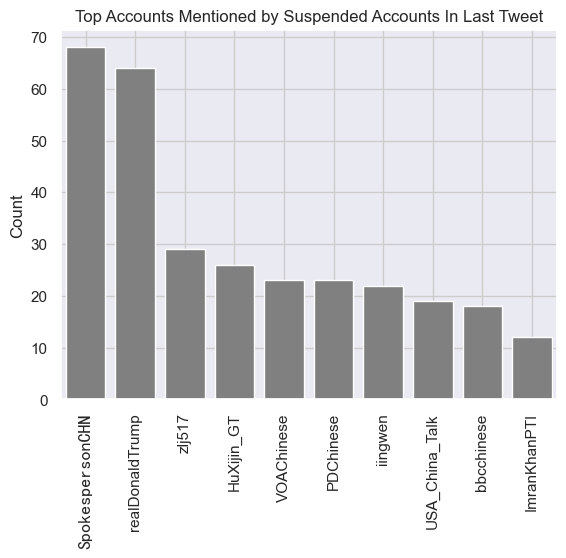

In [208]:
# Some boilerplate to initialise things
sns.set()
plt.figure()

# This is where the actual plot gets made
ax = sns.barplot(data=P[:10], x="hashtag", y="counts", palette=['blue'], saturation=0)

# Customise some display properties
ax.set_title('Top Accounts Mentioned by Suspended Accounts In Last Tweet')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel(None)
ax.set_xticklabels(P[:10]["hashtag"].unique().astype(str), rotation='vertical', fontproperties=fontprop)

# Ask Matplotlib to show it
plt.savefig(results_bucket+'lasttweets_suspended_accounts_mentions.png', bbox_inches='tight')
plt.show()


# Follow this if not seeing Chinese characters: https://hoishing.medium.com/using-chinese-characters-in-matplotlib-5c49dbb6a2f7

## Supplementary with Full Text

In [232]:
pd.set_option('display.max_colwidth', -1)
df_train[df_train['id'].isin(for_susp_text['id'])]

,id,created_at,text,retweet_count,favorite_count,quoted_status_id,user.id,user.created_at,user.description,user.favourites_count,user.followers_count,user.friends_count,user.listed_count,user.location,user.name,user.screen_name,user.statuses_count,quoted_status.user.followers_count,quoted_status.user.friends_count,retweeted_status.user.followers_count,retweeted_status.user.friends_count,user_age,tweets_per_day,since_last_tweet_mins,since_last_tweet_mins_min,since_last_tweet_mins_max,since_last_tweet_mins_mean,avg_tweets_per_hr,avg_tweets_per_day,no_hashtags,no_mentions,no_urls,tw_len,followers_per_followees,containsURL,user.urls_per_tweet,no_hashtags_per_tweet,no_mentions_per_tweet,no_urls_per_tweet,user.followers_countdailychange,user.friends_countdailychange,user.friend_rate,user.followers_rate,user.has_url,user.has_location,user.screen_name.digit_length,user.screen_name.length,is_reply,suspended,split,source_ Round Year Fun!,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ 「モンストからツイート」,source_Affinitweet.com,source_BIGO LIVE,source_Blog2Social APP,source_CallApp,source_Etsy,source_Instagram,source_Joinfsocial,source_Mobile Web (M2),source_Nintendo Switch Share,source_Paper.li,source_Peing,source_SocialPilot.co,source_TeamSight Publisher,source_TweetDeck,source_Twibbon,source_Twitter Web App,source_Twitter Web Client,source_Twitter for Android,source_Twitter for Mac,source_Twitter for iPad,source_Twitter for iPhone,source_WShare,source_WordPress.com,source_漫威超級戰爭（MARVEL Super War）,lang_False,lang_am,lang_ar,lang_bg,lang_bn,lang_bo,lang_ca,lang_ckb,lang_cs,lang_cy,lang_da,lang_de,lang_el,lang_en,lang_es,lang_et,lang_eu,lang_fa,lang_fi,lang_fr,lang_gu,lang_hi,lang_ht,lang_hu,lang_hy,lang_in,lang_is,lang_it,lang_iw,lang_ja,lang_km,lang_ko,lang_lt,lang_lv,lang_ml,lang_mr,lang_my,lang_ne,lang_nl,lang_no,lang_pl,lang_ps,lang_pt,lang_ro,lang_ru,lang_sd,lang_si,lang_sl,lang_sr,lang_sv,lang_ta,lang_th,lang_tl,lang_tr,lang_uk,lang_und,lang_ur,lang_vi,lang_zh,withheld_in_countries_['DE'],withheld_in_countries_['IN'],withheld_in_countries_['TR'],place.country_Finland,place.country_Hong Kong,place.country_India,place.country_Indonesia,place.country_Italy,place.country_Mongolia,place.country_Pakistan,place.country_People's Republic of China,place.country_Portugal,place.country_Republic of Korea,place.country_Russia,place.country_Singapore,place.country_Sri Lanka,place.country_United Arab Emirates,place.country_United States,user.geo_enabled_False,user.geo_enabled_True,user.verified_False,user.has_extended_profile_False,user.has_extended_profile_True,user.protected_False,user.verified_False.1,user.default_profile_True,is_quote_status_False,is_quote_status_True,follower_diffs,created_at_dmy,friend_diffs
8946,'1.2877048072605573e+18',1.000000e-09,香港疫情已几乎稳定，但反对派不顾市民生命安全，为了政治私利，将香港疫情推到风口浪尖上，连续三天确诊人数破百，且确诊总数、本地感染及不明源头都创新高。香港特首林郑月娥已向中央发出求助，如果香港疫情持续恶化本地医务系统不堪重负，希望中… https://t.co/0LKz7JdwMk,3.0,13.0,0,1.278492e+18,1.593651e+09,坦坦荡荡做人，简简单单生活！！China,53.0,42.0,100.0,0.0,NaN,坦坦荡荡,wXzBIjr7Ep5RRre,62.0,0.0,0.0,0.0,0.0,25,2.480000,511.050000,0.0,1387.550000,63.322629,8.857143,13.777778,0,0,1,140,0.420000,1,0.838710,0.403226,0.790323,0.838710,0.0,0.0,4.000000,1.680000,0,0,2,15,0,1,train,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,1,1,0,0.0,Jul 27 2020,0.0
20230,'1.2877901700459889e+18',1.000000e-09,@jobss7732 @Rustompavri20 @thepointwithlx The United States never thought of saving China. It was the Chinese to re… https://t.co/yxogoquaop,0.0,0.0,0,1.279003e+18,1.593773e+09,据说美国给港独台独份子钱让他们造谣生事，破坏中国团结，可惜你们斗不过有理智的明白人，就像传销一样没有自我意识很容易被骗进去从而成为他们的帮凶，你们可以继续散播谣言，明白人不会理会。,370.0,17.0,29.0,0.0,NaN,Opening lightning stroke,cWvY7EfOwNTdjea,1130.0,0.0,0.0,0.0,0.0,24,47.083333,66.083333,0.0,704.583333,8.937093,16.666667,133.333333,0,3,1,140,

In [130]:
df_train_text = df_train.copy()

In [131]:
def lang_trans(text):
    try:
        p = Language.get(text).display_name()
    except:
        p = "Unkown language"
    return p
        

In [132]:
df_train_text['lang'] = df_train_text['lang'].apply(lambda x: lang_trans(x))
P = df_train_text[df_train_text['suspended'] == 1].groupby(['lang'])['id'].count().reset_index().sort_values(by=['id'], ascending=False)

P['prop'] = ((P['id']/sum(P['id'])) * 100).round(2)
P = P.rename(columns = {'lang':'Language','id':'Count', 'prop':'Proportion'})

P.to_csv(results_bucket+'susp_lang_dist.csv', index=False, encoding = "utf_8_sig")
P.head(10)

,Language,Count,Proportion
4,Chinese,3412,38.35
7,English,2676,30.08
32,Urdu,916,10.30
31,Unknown language,725,8.15
18,Japanese,542,6.09
13,Hindi,246,2.77
16,Indonesian,168,1.89
9,Filipino,84,0.94
30,Turkish,19,0.21
8,Estonian,18,0.20


In [133]:
P = df_train_text[df_train_text['suspended'] == 0].groupby(['lang'])['id'].count().reset_index().sort_values(by=['id'], ascending=False)

P['prop'] = ((P['id']/sum(P['id'])) * 100).round(2)
P = P.rename(columns = {'lang':'Language','id':'Count', 'prop':'Proportion'})

P.to_csv(results_bucket+'non_susp_lang_dist.csv', index=False, encoding = "utf_8_sig")
P.head(10)

,Language,Count,Proportion
13,English,38040,35.59
9,Chinese,28457,26.63
54,Urdu,14133,13.22
53,Unknown language,9306,8.71
28,Japanese,4736,4.43
23,Hindi,2421,2.27
0,Amharic,1718,1.61
26,Indonesian,1327,1.24
1,Arabic,1201,1.12
41,Russian,739,0.69


#### Number of Mentions, Hashtags, and URLs per 

In [134]:
P = df_train_accounts.groupby(
   ['suspended_mean'], as_index=False
).agg(
    { 
         'no_urls_per_tweet_mean': 'mean', 
         'no_hashtags_per_tweet_mean': 'mean',
         'no_mentions_per_tweet_mean': 'mean',
    }
)
P['no_urls_per_tweet_mean'] = (P['no_urls_per_tweet_mean'] * 100).round(2)
P['no_hashtags_per_tweet_mean'] = (P['no_hashtags_per_tweet_mean'] * 100).round(2)
P['no_mentions_per_tweet_mean'] = (P['no_mentions_per_tweet_mean'] * 100).round(2)

P = P.rename(columns = {'suspended_mean':'Suspended','no_urls_per_tweet_mean':'Average URLs Per Tweet', 
                        'no_hashtags_per_tweet_mean':'Average Hashtag Per Tweet', 'no_mentions_per_tweet_mean':'Average Mentions Per Tweet'})

P.to_csv(results_bucket+'url_hashtag_mentions_diff.csv', index=False, encoding = "utf_8_sig")
P

,Suspended,Average URLs Per Tweet,Average Hashtag Per Tweet,Average Mentions Per Tweet
0,Not Suspended,35.48,14.79,111.66
1,Suspended,36.15,13.33,104.81
